## Hyperparameter Optimization

In [2]:
# Library time 
import pandas as pd
import numpy as np
import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp
from atomsci.ddm.pipeline import perf_data
from atomsci.ddm.pipeline import compare_models as cm


import os, json, sys, glob, pickle
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

2021-11-19 00:21:07.597997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/spack/brown/apps/proj/5.2.0-gcc-4.8.5-usib7od/lib:/apps/spack/brown/apps/geos/3.7.2-gcc-4.8.5-3vanyva/lib:/apps/spack/brown/apps/gdal/2.4.2-gcc-4.8.5-uj736h3/lib:/apps/spack/brown/apps/netcdf/4.5.0-gcc-6.3.0-d6fczmr/lib:/apps/spack/brown/apps/libtiff/4.0.10-gcc-6.3.0-6p5trqs/lib:/apps/spack/brown/apps/hdf5/1.8.16-gcc-6.3.0-7q7ndrz/lib:/apps/spack/brown/apps/hdf/4.2.14-gcc-6.3.0-2xg7pyg/lib:/scratch/brown/kamstut/tdm/apps/jupyter/kernels/llnl/.venv/lib:/apps/spack/brown/apps/r/4.0.0-gcc-6.3.0-hrvmcqp/rlib/R/lib:/apps/spack/brown/apps/openblas/0.3.7-gcc-6.3.0-qk24sho/lib:/apps/spack/brown/apps/tk/8.6.8-gcc-6.3.0-6qaesqb/lib:/apps/spack/brown/apps/tcl/8.6.8-gcc-6.3.0-n6mxabo/lib:/apps/spack/brown/apps/zlib/1.2.11-gcc-4.8.5-pkmj6e7/lib:/app

## Training a RF Model Using RDKit_raw descriptors 

In [2]:
split_uuid = '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72'
response_col = "target_OPRM1_standard_value"
train_file = '/home/rwilfong/OPRM1/mod_OPRM1.csv'
compound_id = "compound_id"
smiles_col = "SMILES"

params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "prediction_type": "regression",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "descriptor_type": "rdkit_raw", # modred_filtered
        "model_type": "RF", # different model type 
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "/home/rwilfong/RF/rdkit-raw/"
    }

In [4]:
rd_param = parse.wrapper(params)
rd = mp.ModelPipeline(rd_param)
rd.train_model()

2021-11-18 18:47:44,838 Attempting to load featurized dataset
2021-11-18 18:47:45,070 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:47:45,073 Featurized dataset not previously saved for dataset mod_OPRM1, creating new
2021-11-18 18:47:45,200 Featurizing sample 0
2021-11-18 18:47:48,595 Featurizing sample 1000
2021-11-18 18:47:51,928 Featurizing sample 2000
2021-11-18 18:47:55,274 Featurizing sample 3000
2021-11-18 18:47:58,639 Featurizing sample 4000
2021-11-18 18:48:02,030 Featurizing sample 5000
2021-11-18 18:48:05,410 Featurizing sample 6000
2021-11-18 18:48:08,904 Featurizing sample 7000
2021-11-18 18:48:12,334 Featurizing sample 8000
2021-11-18 18:48:15,595 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 18:48

number of features: 1024


2021-11-18 18:48:21,613 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_4437d297-068f-447e-905f-18ec64242252.csv
2021-11-18 18:48:21,761 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/9e12bc91-be44-4937-a3d1-2ec7c9e37dba/transformers.pkl
2021-11-18 18:48:21,764 Transforming response data
2021-11-18 18:48:21,869 Transforming response data
2021-11-18 18:48:21,891 Transforming response data
2021-11-18 18:48:21,924 Fitting random forest model
2021-11-18 18:48:48,709 Fold 0: training r2_score = 0.940, validation r2_score = 0.452, test r2_score = -0.284
2021-11-18 18:48:53,941 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_9e12bc91-be44-4937-a3d1-2ec7c9e37dba.tar.gz


## Grid Search to find best parameters

In [5]:
# in general, what we are doing is taking a grid search approach to evaluate hyperparameters 

rfe_choices = [16, 32, 64, 128] # setting the options for our parameters 
rfd_choices = [16, 32, 64, 128]
rff_choices = [16, 32, 64, 128]


rfe_list = [] # estimators
rfd_list = [] # depth
rff_list = [] # features 
valid_r2_list = [] # creating a list for the valid r2 scores 
for rf_estimator in rfe_choices:
    for rf_depth in rfd_choices:
        for rf_feature in rff_choices:
            params["rf_estimators"] = rf_estimator # choosing an estimator from our parameter list (param_choice) 
            params["rf_max_depth"] = rf_depth # choosing depth for the max depth
            params["rf_max_features"] = rf_feature # choosing a number for the max features 
            rfe_list.append(rf_estimator) # appending the chosen estimator to our estimator list
            rfd_list.append(rf_depth) # appending the chosen depth to our depth list
            rff_list.append(rf_feature) # appending the chosen feature to our feature list 
            tp = parse.wrapper(params) # wrapping using ATOM function
            pl = mp.ModelPipeline(tp) # running through the model pipeline [from ATOM]
            pl.train_model() # training our models based on these parameters 
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best") # grabbing best model
            pred_results = pred_data.get_prediction_results() # predicting results from the best model
            valid_r2 = pred_results['r2_score'] # extracting the r2 validation score from the best model
            valid_r2_list.append(valid_r2) # appending the r2 score to our list 
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}") # printing out the used estiamtors, depth, and features and the resulting r2 score 

2021-11-18 18:53:29,876 Attempting to load featurized dataset
2021-11-18 18:53:29,914 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:53:29,918 Featurized dataset not previously saved for dataset mod_OPRM1, creating new
2021-11-18 18:53:29,962 Featurizing sample 0
2021-11-18 18:53:33,256 Featurizing sample 1000
2021-11-18 18:53:36,577 Featurizing sample 2000
2021-11-18 18:53:39,907 Featurizing sample 3000
2021-11-18 18:53:43,267 Featurizing sample 4000
2021-11-18 18:53:46,627 Featurizing sample 5000
2021-11-18 18:53:49,988 Featurizing sample 6000
2021-11-18 18:53:53,496 Featurizing sample 7000
2021-11-18 18:53:56,909 Featurizing sample 8000
2021-11-18 18:53:59,980 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 18:53

number of features: 1024


2021-11-18 18:54:05,734 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_60229631-6bf3-473d-8a8b-be90e9a2cea6.csv
2021-11-18 18:54:05,870 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/185b6d1e-41d0-4885-b324-852ca811ae54/transformers.pkl
2021-11-18 18:54:05,872 Transforming response data
2021-11-18 18:54:05,970 Transforming response data
2021-11-18 18:54:05,991 Transforming response data
2021-11-18 18:54:06,028 Fitting random forest model
2021-11-18 18:54:06,548 Fold 0: training r2_score = 0.610, validation r2_score = 0.300, test r2_score = -0.449
2021-11-18 18:54:06,629 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_185b6d1e-41d0-4885-b324-852ca811ae54.tar.gz
2021-11-18 18:54:06,643 Attempting to load featurized dataset
2021-11-18 18:54:06,661 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:54:06,664 Featurized 

rf_estimators: 16, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.3003146038014253


2021-11-18 18:54:09,961 Featurizing sample 1000
2021-11-18 18:54:13,283 Featurizing sample 2000
2021-11-18 18:54:16,621 Featurizing sample 3000
2021-11-18 18:54:19,970 Featurizing sample 4000
2021-11-18 18:54:23,321 Featurizing sample 5000
2021-11-18 18:54:26,657 Featurizing sample 6000
2021-11-18 18:54:30,139 Featurizing sample 7000
2021-11-18 18:54:33,560 Featurizing sample 8000
2021-11-18 18:54:36,665 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 18:54:36,669 Splitting data by scaffold


number of features: 1024


2021-11-18 18:54:42,490 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_cf7875d3-6cea-4e8e-bc69-f3d97ab44733.csv
2021-11-18 18:54:42,626 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/7fe72ebf-e0ba-4c67-8cf8-95dd9efc544f/transformers.pkl
2021-11-18 18:54:42,628 Transforming response data
2021-11-18 18:54:42,727 Transforming response data
2021-11-18 18:54:42,748 Transforming response data
2021-11-18 18:54:42,784 Fitting random forest model
2021-11-18 18:54:43,423 Fold 0: training r2_score = 0.672, validation r2_score = 0.337, test r2_score = -0.438
2021-11-18 18:54:43,494 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_7fe72ebf-e0ba-4c67-8cf8-95dd9efc544f.tar.gz
2021-11-18 18:54:43,509 Attempting to load featurized dataset
2021-11-18 18:54:43,528 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:54:43,529 Featurized 

rf_estimators: 16, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3369222079665559


2021-11-18 18:54:46,837 Featurizing sample 1000
2021-11-18 18:54:50,157 Featurizing sample 2000
2021-11-18 18:54:53,508 Featurizing sample 3000
2021-11-18 18:54:56,865 Featurizing sample 4000
2021-11-18 18:55:00,220 Featurizing sample 5000
2021-11-18 18:55:03,584 Featurizing sample 6000
2021-11-18 18:55:07,076 Featurizing sample 7000
2021-11-18 18:55:10,496 Featurizing sample 8000
2021-11-18 18:55:13,568 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 18:55:13,570 Splitting data by scaffold


number of features: 1024


2021-11-18 18:55:19,320 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_f9aede47-29da-470d-b43d-9fd019d7b992.csv
2021-11-18 18:55:19,450 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/f44f47d9-752d-489f-9353-a8635e2d6a33/transformers.pkl
2021-11-18 18:55:19,452 Transforming response data
2021-11-18 18:55:19,553 Transforming response data
2021-11-18 18:55:19,569 Transforming response data
2021-11-18 18:55:19,604 Fitting random forest model
2021-11-18 18:55:20,483 Fold 0: training r2_score = 0.724, validation r2_score = 0.363, test r2_score = -0.381
2021-11-18 18:55:20,556 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_f44f47d9-752d-489f-9353-a8635e2d6a33.tar.gz
2021-11-18 18:55:20,571 Attempting to load featurized dataset
2021-11-18 18:55:20,590 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:55:20,592 Featurized 

rf_estimators: 16, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.36328590912166325


2021-11-18 18:55:23,907 Featurizing sample 1000
2021-11-18 18:55:27,229 Featurizing sample 2000
2021-11-18 18:55:30,563 Featurizing sample 3000
2021-11-18 18:55:33,898 Featurizing sample 4000
2021-11-18 18:55:37,240 Featurizing sample 5000
2021-11-18 18:55:40,582 Featurizing sample 6000
2021-11-18 18:55:44,056 Featurizing sample 7000
2021-11-18 18:55:47,483 Featurizing sample 8000
2021-11-18 18:55:50,549 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 18:55:50,551 Splitting data by scaffold


number of features: 1024


2021-11-18 18:55:56,293 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_122d20f6-9750-491e-96d3-76b966c9230e.csv
2021-11-18 18:55:56,436 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/9dd813f8-0267-44fc-baf2-1346ffde50c2/transformers.pkl
2021-11-18 18:55:56,439 Transforming response data
2021-11-18 18:55:56,538 Transforming response data
2021-11-18 18:55:56,556 Transforming response data
2021-11-18 18:55:56,587 Fitting random forest model
2021-11-18 18:55:57,899 Fold 0: training r2_score = 0.732, validation r2_score = 0.329, test r2_score = -0.515
2021-11-18 18:55:57,964 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_9dd813f8-0267-44fc-baf2-1346ffde50c2.tar.gz
2021-11-18 18:55:57,980 Attempting to load featurized dataset
2021-11-18 18:55:58,008 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:55:58,010 Featurized 

rf_estimators: 16, rf_max_depth: 16, rf_max_features: 128, valid_r2: 0.3294392171889432


2021-11-18 18:56:01,304 Featurizing sample 1000
2021-11-18 18:56:04,653 Featurizing sample 2000
2021-11-18 18:56:07,993 Featurizing sample 3000
2021-11-18 18:56:11,337 Featurizing sample 4000
2021-11-18 18:56:14,681 Featurizing sample 5000
2021-11-18 18:56:18,029 Featurizing sample 6000
2021-11-18 18:56:21,515 Featurizing sample 7000
2021-11-18 18:56:24,947 Featurizing sample 8000
2021-11-18 18:56:28,017 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 18:56:28,019 Splitting data by scaffold


number of features: 1024


2021-11-18 18:56:33,973 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_2632c61f-e3d0-4da2-8b6e-70cf157f413c.csv
2021-11-18 18:56:34,175 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/354bca80-9d82-4507-a108-6b71fd441f79/transformers.pkl
2021-11-18 18:56:34,178 Transforming response data
2021-11-18 18:56:34,429 Transforming response data
2021-11-18 18:56:34,453 Transforming response data
2021-11-18 18:56:34,493 Fitting random forest model
2021-11-18 18:56:35,294 Fold 0: training r2_score = 0.878, validation r2_score = 0.363, test r2_score = -0.346
2021-11-18 18:56:35,447 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_354bca80-9d82-4507-a108-6b71fd441f79.tar.gz
2021-11-18 18:56:35,463 Attempting to load featurized dataset
2021-11-18 18:56:35,484 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:56:35,486 Featurized 

rf_estimators: 16, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.36260196993373905


2021-11-18 18:56:38,772 Featurizing sample 1000
2021-11-18 18:56:42,097 Featurizing sample 2000
2021-11-18 18:56:45,444 Featurizing sample 3000
2021-11-18 18:56:48,807 Featurizing sample 4000
2021-11-18 18:56:52,158 Featurizing sample 5000
2021-11-18 18:56:55,515 Featurizing sample 6000
2021-11-18 18:56:59,001 Featurizing sample 7000
2021-11-18 18:57:02,416 Featurizing sample 8000
2021-11-18 18:57:05,490 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 18:57:05,492 Splitting data by scaffold


number of features: 1024


2021-11-18 18:57:11,420 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_d6e80935-e7c7-40c3-b710-24bed36f8d57.csv
2021-11-18 18:57:11,598 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/7ffd20df-89c8-4278-a7c5-0eba849f1029/transformers.pkl
2021-11-18 18:57:11,601 Transforming response data
2021-11-18 18:57:11,699 Transforming response data
2021-11-18 18:57:11,722 Transforming response data
2021-11-18 18:57:11,758 Fitting random forest model
2021-11-18 18:57:12,717 Fold 0: training r2_score = 0.896, validation r2_score = 0.438, test r2_score = -0.382
2021-11-18 18:57:12,865 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_7ffd20df-89c8-4278-a7c5-0eba849f1029.tar.gz
2021-11-18 18:57:12,884 Attempting to load featurized dataset
2021-11-18 18:57:12,905 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:57:12,907 Featurized 

rf_estimators: 16, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4378805726491307


2021-11-18 18:57:16,212 Featurizing sample 1000
2021-11-18 18:57:19,541 Featurizing sample 2000
2021-11-18 18:57:22,885 Featurizing sample 3000
2021-11-18 18:57:26,263 Featurizing sample 4000
2021-11-18 18:57:29,622 Featurizing sample 5000
2021-11-18 18:57:32,969 Featurizing sample 6000
2021-11-18 18:57:36,479 Featurizing sample 7000
2021-11-18 18:57:39,898 Featurizing sample 8000
2021-11-18 18:57:42,983 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 18:57:42,985 Splitting data by scaffold


number of features: 1024


2021-11-18 18:57:48,884 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_71e976e8-fa38-4222-b5ba-8b2650cd5a6f.csv
2021-11-18 18:57:49,060 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/e9725443-c9d4-49ac-9337-503acd506698/transformers.pkl
2021-11-18 18:57:49,063 Transforming response data
2021-11-18 18:57:49,160 Transforming response data
2021-11-18 18:57:49,182 Transforming response data
2021-11-18 18:57:49,218 Fitting random forest model
2021-11-18 18:57:50,458 Fold 0: training r2_score = 0.909, validation r2_score = 0.397, test r2_score = -0.426
2021-11-18 18:57:50,620 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_e9725443-c9d4-49ac-9337-503acd506698.tar.gz
2021-11-18 18:57:50,635 Attempting to load featurized dataset
2021-11-18 18:57:50,653 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:57:50,655 Featurized 

rf_estimators: 16, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.3974950229849993


2021-11-18 18:57:53,959 Featurizing sample 1000
2021-11-18 18:57:57,288 Featurizing sample 2000
2021-11-18 18:58:00,625 Featurizing sample 3000
2021-11-18 18:58:04,015 Featurizing sample 4000
2021-11-18 18:58:07,370 Featurizing sample 5000
2021-11-18 18:58:10,717 Featurizing sample 6000
2021-11-18 18:58:14,216 Featurizing sample 7000
2021-11-18 18:58:17,641 Featurizing sample 8000
2021-11-18 18:58:20,712 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 18:58:20,715 Splitting data by scaffold


number of features: 1024


2021-11-18 18:58:26,615 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_68da18db-216d-4b69-807f-a4b62202d04d.csv
2021-11-18 18:58:26,790 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/af6484a1-a9d5-444e-91f0-47bcc1b67b84/transformers.pkl
2021-11-18 18:58:26,794 Transforming response data
2021-11-18 18:58:26,892 Transforming response data
2021-11-18 18:58:26,914 Transforming response data
2021-11-18 18:58:26,950 Fitting random forest model
2021-11-18 18:58:28,742 Fold 0: training r2_score = 0.911, validation r2_score = 0.377, test r2_score = -0.530
2021-11-18 18:58:28,889 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_af6484a1-a9d5-444e-91f0-47bcc1b67b84.tar.gz
2021-11-18 18:58:28,904 Attempting to load featurized dataset
2021-11-18 18:58:28,925 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:58:28,927 Featurized 

rf_estimators: 16, rf_max_depth: 32, rf_max_features: 128, valid_r2: 0.37682585877827557


2021-11-18 18:58:32,217 Featurizing sample 1000
2021-11-18 18:58:35,534 Featurizing sample 2000
2021-11-18 18:58:38,877 Featurizing sample 3000
2021-11-18 18:58:42,232 Featurizing sample 4000
2021-11-18 18:58:45,599 Featurizing sample 5000
2021-11-18 18:58:48,971 Featurizing sample 6000
2021-11-18 18:58:52,464 Featurizing sample 7000
2021-11-18 18:58:55,893 Featurizing sample 8000
2021-11-18 18:58:58,968 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 18:58:58,970 Splitting data by scaffold


number of features: 1024


2021-11-18 18:59:04,859 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_2d5bf1c0-14c4-420f-838d-eda3b14fa400.csv
2021-11-18 18:59:05,041 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/93c309e2-0765-4069-82f2-6a4729f36507/transformers.pkl
2021-11-18 18:59:05,044 Transforming response data
2021-11-18 18:59:05,145 Transforming response data
2021-11-18 18:59:05,165 Transforming response data
2021-11-18 18:59:05,205 Fitting random forest model
2021-11-18 18:59:06,121 Fold 0: training r2_score = 0.926, validation r2_score = 0.391, test r2_score = -0.483
2021-11-18 18:59:06,308 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_93c309e2-0765-4069-82f2-6a4729f36507.tar.gz
2021-11-18 18:59:06,327 Attempting to load featurized dataset
2021-11-18 18:59:06,349 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:59:06,352 Featurized 

rf_estimators: 16, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.39135878430637316


2021-11-18 18:59:09,649 Featurizing sample 1000
2021-11-18 18:59:12,969 Featurizing sample 2000
2021-11-18 18:59:16,312 Featurizing sample 3000
2021-11-18 18:59:19,661 Featurizing sample 4000
2021-11-18 18:59:23,015 Featurizing sample 5000
2021-11-18 18:59:26,367 Featurizing sample 6000
2021-11-18 18:59:29,866 Featurizing sample 7000
2021-11-18 18:59:33,280 Featurizing sample 8000
2021-11-18 18:59:36,357 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 18:59:36,360 Splitting data by scaffold


number of features: 1024


2021-11-18 18:59:42,248 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_8abc0ec7-0c9e-4558-af24-9ef73f5d2c4c.csv
2021-11-18 18:59:42,427 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/8974da60-b995-41ff-b727-c0dafe2a075d/transformers.pkl
2021-11-18 18:59:42,429 Transforming response data
2021-11-18 18:59:42,527 Transforming response data
2021-11-18 18:59:42,549 Transforming response data
2021-11-18 18:59:42,582 Fitting random forest model
2021-11-18 18:59:43,645 Fold 0: training r2_score = 0.928, validation r2_score = 0.353, test r2_score = -0.496
2021-11-18 18:59:43,846 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_8974da60-b995-41ff-b727-c0dafe2a075d.tar.gz
2021-11-18 18:59:43,860 Attempting to load featurized dataset
2021-11-18 18:59:43,878 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 18:59:43,880 Featurized 

rf_estimators: 16, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.3533163503561463


2021-11-18 18:59:47,192 Featurizing sample 1000
2021-11-18 18:59:50,517 Featurizing sample 2000
2021-11-18 18:59:53,849 Featurizing sample 3000
2021-11-18 18:59:57,218 Featurizing sample 4000
2021-11-18 19:00:00,568 Featurizing sample 5000
2021-11-18 19:00:03,947 Featurizing sample 6000
2021-11-18 19:00:07,428 Featurizing sample 7000
2021-11-18 19:00:10,844 Featurizing sample 8000
2021-11-18 19:00:13,907 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:00:13,910 Splitting data by scaffold


number of features: 1024


2021-11-18 19:00:19,795 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_a06fce52-54ff-4140-97bd-bab0a795fa1d.csv
2021-11-18 19:00:19,971 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/f4ecbc85-04d7-4c97-8d66-ae0f1af76446/transformers.pkl
2021-11-18 19:00:19,974 Transforming response data
2021-11-18 19:00:20,076 Transforming response data
2021-11-18 19:00:20,093 Transforming response data
2021-11-18 19:00:20,134 Fitting random forest model
2021-11-18 19:00:21,500 Fold 0: training r2_score = 0.929, validation r2_score = 0.375, test r2_score = -0.412
2021-11-18 19:00:21,755 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_f4ecbc85-04d7-4c97-8d66-ae0f1af76446.tar.gz
2021-11-18 19:00:21,772 Attempting to load featurized dataset
2021-11-18 19:00:21,793 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:00:21,795 Featurized 

rf_estimators: 16, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.3748559867666841


2021-11-18 19:00:25,102 Featurizing sample 1000
2021-11-18 19:00:28,422 Featurizing sample 2000
2021-11-18 19:00:31,759 Featurizing sample 3000
2021-11-18 19:00:35,115 Featurizing sample 4000
2021-11-18 19:00:38,467 Featurizing sample 5000
2021-11-18 19:00:41,810 Featurizing sample 6000
2021-11-18 19:00:45,298 Featurizing sample 7000
2021-11-18 19:00:48,720 Featurizing sample 8000
2021-11-18 19:00:51,782 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:00:51,784 Splitting data by scaffold


number of features: 1024


2021-11-18 19:00:57,697 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_8259906d-9360-43e6-a81a-b39309110200.csv
2021-11-18 19:00:57,884 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/8d6ed6ed-246a-491a-9cf2-b3ffbc1bbf26/transformers.pkl
2021-11-18 19:00:57,887 Transforming response data
2021-11-18 19:00:57,988 Transforming response data
2021-11-18 19:00:58,007 Transforming response data
2021-11-18 19:00:58,047 Fitting random forest model
2021-11-18 19:01:00,003 Fold 0: training r2_score = 0.930, validation r2_score = 0.388, test r2_score = -0.578
2021-11-18 19:01:00,176 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_8d6ed6ed-246a-491a-9cf2-b3ffbc1bbf26.tar.gz
2021-11-18 19:01:00,190 Attempting to load featurized dataset
2021-11-18 19:01:00,214 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:01:00,216 Featurized 

rf_estimators: 16, rf_max_depth: 64, rf_max_features: 128, valid_r2: 0.3876491881265307


2021-11-18 19:01:03,515 Featurizing sample 1000
2021-11-18 19:01:06,828 Featurizing sample 2000
2021-11-18 19:01:10,168 Featurizing sample 3000
2021-11-18 19:01:13,527 Featurizing sample 4000
2021-11-18 19:01:16,888 Featurizing sample 5000
2021-11-18 19:01:20,238 Featurizing sample 6000
2021-11-18 19:01:23,730 Featurizing sample 7000
2021-11-18 19:01:27,161 Featurizing sample 8000
2021-11-18 19:01:30,237 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:01:30,239 Splitting data by scaffold


number of features: 1024


2021-11-18 19:01:36,405 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_6d29609e-f4aa-4502-90af-6a6cde7f08d5.csv
2021-11-18 19:01:36,585 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/060a8e96-a76d-4626-b75c-a049080e1e9b/transformers.pkl
2021-11-18 19:01:36,587 Transforming response data
2021-11-18 19:01:36,688 Transforming response data
2021-11-18 19:01:36,704 Transforming response data
2021-11-18 19:01:36,740 Fitting random forest model
2021-11-18 19:01:37,655 Fold 0: training r2_score = 0.927, validation r2_score = 0.372, test r2_score = -0.497
2021-11-18 19:01:37,847 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_060a8e96-a76d-4626-b75c-a049080e1e9b.tar.gz
2021-11-18 19:01:37,862 Attempting to load featurized dataset
2021-11-18 19:01:37,882 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:01:37,885 Featurized 

rf_estimators: 16, rf_max_depth: 128, rf_max_features: 16, valid_r2: 0.3724585075121726


2021-11-18 19:01:41,186 Featurizing sample 1000
2021-11-18 19:01:44,508 Featurizing sample 2000
2021-11-18 19:01:47,861 Featurizing sample 3000
2021-11-18 19:01:51,212 Featurizing sample 4000
2021-11-18 19:01:54,554 Featurizing sample 5000
2021-11-18 19:01:57,895 Featurizing sample 6000
2021-11-18 19:02:01,387 Featurizing sample 7000
2021-11-18 19:02:04,854 Featurizing sample 8000
2021-11-18 19:02:07,914 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:02:07,917 Splitting data by scaffold


number of features: 1024


2021-11-18 19:02:13,813 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_261b00b2-2422-4901-9774-7bd05e19eb0e.csv
2021-11-18 19:02:13,990 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/b282d5cf-6482-4fe0-b429-895189018ffc/transformers.pkl
2021-11-18 19:02:13,992 Transforming response data
2021-11-18 19:02:14,092 Transforming response data
2021-11-18 19:02:14,110 Transforming response data
2021-11-18 19:02:14,145 Fitting random forest model
2021-11-18 19:02:15,207 Fold 0: training r2_score = 0.929, validation r2_score = 0.344, test r2_score = -0.618
2021-11-18 19:02:15,394 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_b282d5cf-6482-4fe0-b429-895189018ffc.tar.gz
2021-11-18 19:02:15,409 Attempting to load featurized dataset
2021-11-18 19:02:15,427 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:02:15,429 Featurized 

rf_estimators: 16, rf_max_depth: 128, rf_max_features: 32, valid_r2: 0.34391575699635857


2021-11-18 19:02:18,738 Featurizing sample 1000
2021-11-18 19:02:22,055 Featurizing sample 2000
2021-11-18 19:02:25,400 Featurizing sample 3000
2021-11-18 19:02:28,745 Featurizing sample 4000
2021-11-18 19:02:32,099 Featurizing sample 5000
2021-11-18 19:02:35,440 Featurizing sample 6000
2021-11-18 19:02:38,926 Featurizing sample 7000
2021-11-18 19:02:42,333 Featurizing sample 8000
2021-11-18 19:02:45,403 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:02:45,405 Splitting data by scaffold


number of features: 1024


2021-11-18 19:02:51,301 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_db3f5947-8e64-495c-b7e5-b64c63645b12.csv
2021-11-18 19:02:51,476 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/00064656-f62c-44b8-bd1c-5cfdf720f98e/transformers.pkl
2021-11-18 19:02:51,478 Transforming response data
2021-11-18 19:02:51,578 Transforming response data
2021-11-18 19:02:51,596 Transforming response data
2021-11-18 19:02:51,627 Fitting random forest model
2021-11-18 19:02:52,989 Fold 0: training r2_score = 0.930, validation r2_score = 0.412, test r2_score = -0.398
2021-11-18 19:02:53,218 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_00064656-f62c-44b8-bd1c-5cfdf720f98e.tar.gz
2021-11-18 19:02:53,234 Attempting to load featurized dataset
2021-11-18 19:02:53,256 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:02:53,258 Featurized 

rf_estimators: 16, rf_max_depth: 128, rf_max_features: 64, valid_r2: 0.41162518610797516


2021-11-18 19:02:56,569 Featurizing sample 1000
2021-11-18 19:02:59,895 Featurizing sample 2000
2021-11-18 19:03:03,221 Featurizing sample 3000
2021-11-18 19:03:06,590 Featurizing sample 4000
2021-11-18 19:03:09,941 Featurizing sample 5000
2021-11-18 19:03:13,271 Featurizing sample 6000
2021-11-18 19:03:16,771 Featurizing sample 7000
2021-11-18 19:03:20,182 Featurizing sample 8000
2021-11-18 19:03:23,253 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:03:23,256 Splitting data by scaffold


number of features: 1024


2021-11-18 19:03:29,142 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_c43cab34-57a0-4f22-a74d-ec61e42aeeaa.csv
2021-11-18 19:03:29,320 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/1f60d9c1-bebf-4258-877d-d52ac56dc53c/transformers.pkl
2021-11-18 19:03:29,322 Transforming response data
2021-11-18 19:03:29,421 Transforming response data
2021-11-18 19:03:29,530 Transforming response data
2021-11-18 19:03:29,593 Fitting random forest model
2021-11-18 19:03:31,565 Fold 0: training r2_score = 0.930, validation r2_score = 0.382, test r2_score = -0.556
2021-11-18 19:03:31,739 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_1f60d9c1-bebf-4258-877d-d52ac56dc53c.tar.gz
2021-11-18 19:03:31,757 Attempting to load featurized dataset
2021-11-18 19:03:31,778 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:03:31,780 Featurized 

rf_estimators: 16, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.38236967736774896


2021-11-18 19:03:35,075 Featurizing sample 1000
2021-11-18 19:03:38,393 Featurizing sample 2000
2021-11-18 19:03:41,732 Featurizing sample 3000
2021-11-18 19:03:45,085 Featurizing sample 4000
2021-11-18 19:03:48,445 Featurizing sample 5000
2021-11-18 19:03:51,789 Featurizing sample 6000
2021-11-18 19:03:55,276 Featurizing sample 7000
2021-11-18 19:03:58,698 Featurizing sample 8000
2021-11-18 19:04:01,755 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:04:01,757 Splitting data by scaffold


number of features: 1024


2021-11-18 19:04:08,078 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_2b97ae0f-0bff-49db-85c9-a92a210600f8.csv
2021-11-18 19:04:08,252 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/b254ebca-6ff3-4c40-9196-1e659dbd2b94/transformers.pkl
2021-11-18 19:04:08,254 Transforming response data
2021-11-18 19:04:08,355 Transforming response data
2021-11-18 19:04:08,371 Transforming response data
2021-11-18 19:04:08,409 Fitting random forest model
2021-11-18 19:04:09,237 Fold 0: training r2_score = 0.604, validation r2_score = 0.309, test r2_score = -0.432
2021-11-18 19:04:09,347 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_b254ebca-6ff3-4c40-9196-1e659dbd2b94.tar.gz
2021-11-18 19:04:09,363 Attempting to load featurized dataset
2021-11-18 19:04:09,383 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:04:09,385 Featurized 

rf_estimators: 32, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.3092985985338963


2021-11-18 19:04:12,694 Featurizing sample 1000
2021-11-18 19:04:16,018 Featurizing sample 2000
2021-11-18 19:04:19,372 Featurizing sample 3000
2021-11-18 19:04:22,734 Featurizing sample 4000
2021-11-18 19:04:26,083 Featurizing sample 5000
2021-11-18 19:04:29,451 Featurizing sample 6000
2021-11-18 19:04:32,954 Featurizing sample 7000
2021-11-18 19:04:36,377 Featurizing sample 8000
2021-11-18 19:04:39,442 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:04:39,444 Splitting data by scaffold


number of features: 1024


2021-11-18 19:04:45,321 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_c3831bfd-a14e-4b44-ba85-60d14eaec76e.csv
2021-11-18 19:04:45,498 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/7a01abe3-d781-4665-8f4d-a2df9c1e4874/transformers.pkl
2021-11-18 19:04:45,500 Transforming response data
2021-11-18 19:04:45,600 Transforming response data
2021-11-18 19:04:45,622 Transforming response data
2021-11-18 19:04:45,660 Fitting random forest model
2021-11-18 19:04:46,761 Fold 0: training r2_score = 0.680, validation r2_score = 0.353, test r2_score = -0.403
2021-11-18 19:04:46,878 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_7a01abe3-d781-4665-8f4d-a2df9c1e4874.tar.gz
2021-11-18 19:04:46,898 Attempting to load featurized dataset
2021-11-18 19:04:46,917 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:04:46,920 Featurized 

rf_estimators: 32, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3530162425572797


2021-11-18 19:04:50,226 Featurizing sample 1000
2021-11-18 19:04:53,545 Featurizing sample 2000
2021-11-18 19:04:56,873 Featurizing sample 3000
2021-11-18 19:05:00,216 Featurizing sample 4000
2021-11-18 19:05:03,553 Featurizing sample 5000
2021-11-18 19:05:06,883 Featurizing sample 6000
2021-11-18 19:05:10,375 Featurizing sample 7000
2021-11-18 19:05:13,785 Featurizing sample 8000
2021-11-18 19:05:16,835 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:05:16,837 Splitting data by scaffold


number of features: 1024


2021-11-18 19:05:22,740 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_0628bd08-422d-40b0-b3e1-7c2448f51cb1.csv
2021-11-18 19:05:22,916 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/afc57501-1ddd-4888-a8ab-a3a1bca29142/transformers.pkl
2021-11-18 19:05:22,918 Transforming response data
2021-11-18 19:05:23,020 Transforming response data
2021-11-18 19:05:23,036 Transforming response data
2021-11-18 19:05:23,071 Fitting random forest model
2021-11-18 19:05:24,604 Fold 0: training r2_score = 0.729, validation r2_score = 0.375, test r2_score = -0.368
2021-11-18 19:05:24,722 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_afc57501-1ddd-4888-a8ab-a3a1bca29142.tar.gz
2021-11-18 19:05:24,737 Attempting to load featurized dataset
2021-11-18 19:05:24,757 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:05:24,759 Featurized 

rf_estimators: 32, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.3748455046142952


2021-11-18 19:05:28,068 Featurizing sample 1000
2021-11-18 19:05:31,386 Featurizing sample 2000
2021-11-18 19:05:34,717 Featurizing sample 3000
2021-11-18 19:05:38,074 Featurizing sample 4000
2021-11-18 19:05:41,414 Featurizing sample 5000
2021-11-18 19:05:44,757 Featurizing sample 6000
2021-11-18 19:05:48,261 Featurizing sample 7000
2021-11-18 19:05:51,667 Featurizing sample 8000
2021-11-18 19:05:54,737 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:05:54,739 Splitting data by scaffold


number of features: 1024


2021-11-18 19:06:00,630 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_c7d2c450-4919-4076-9cb3-f716da599dbe.csv
2021-11-18 19:06:00,809 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/715dd726-cdce-4633-9b44-701e99d66aed/transformers.pkl
2021-11-18 19:06:00,811 Transforming response data
2021-11-18 19:06:00,910 Transforming response data
2021-11-18 19:06:00,930 Transforming response data
2021-11-18 19:06:00,962 Fitting random forest model
2021-11-18 19:06:03,344 Fold 0: training r2_score = 0.750, validation r2_score = 0.375, test r2_score = -0.439
2021-11-18 19:06:03,463 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_715dd726-cdce-4633-9b44-701e99d66aed.tar.gz
2021-11-18 19:06:03,478 Attempting to load featurized dataset
2021-11-18 19:06:03,498 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:06:03,500 Featurized 

rf_estimators: 32, rf_max_depth: 16, rf_max_features: 128, valid_r2: 0.37531860856924604


2021-11-18 19:06:06,861 Featurizing sample 1000
2021-11-18 19:06:10,187 Featurizing sample 2000
2021-11-18 19:06:13,529 Featurizing sample 3000
2021-11-18 19:06:16,883 Featurizing sample 4000
2021-11-18 19:06:20,246 Featurizing sample 5000
2021-11-18 19:06:23,593 Featurizing sample 6000
2021-11-18 19:06:27,075 Featurizing sample 7000
2021-11-18 19:06:30,512 Featurizing sample 8000
2021-11-18 19:06:33,579 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:06:33,581 Splitting data by scaffold


number of features: 1024


2021-11-18 19:06:39,485 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_90bafb01-5a6b-4c05-92b7-33f64a0b1db4.csv
2021-11-18 19:06:39,663 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/458c0c7b-f1c9-4b3a-8031-a674c3d39774/transformers.pkl
2021-11-18 19:06:39,667 Transforming response data
2021-11-18 19:06:39,764 Transforming response data
2021-11-18 19:06:39,786 Transforming response data
2021-11-18 19:06:39,818 Fitting random forest model
2021-11-18 19:06:41,119 Fold 0: training r2_score = 0.880, validation r2_score = 0.397, test r2_score = -0.312
2021-11-18 19:06:41,400 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_458c0c7b-f1c9-4b3a-8031-a674c3d39774.tar.gz
2021-11-18 19:06:41,416 Attempting to load featurized dataset
2021-11-18 19:06:41,436 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:06:41,438 Featurized 

rf_estimators: 32, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.3974567915401821


2021-11-18 19:06:44,745 Featurizing sample 1000
2021-11-18 19:06:48,064 Featurizing sample 2000
2021-11-18 19:06:51,403 Featurizing sample 3000
2021-11-18 19:06:54,755 Featurizing sample 4000
2021-11-18 19:06:58,102 Featurizing sample 5000
2021-11-18 19:07:01,454 Featurizing sample 6000
2021-11-18 19:07:04,941 Featurizing sample 7000
2021-11-18 19:07:08,361 Featurizing sample 8000
2021-11-18 19:07:11,437 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:07:11,440 Splitting data by scaffold


number of features: 1024


2021-11-18 19:07:17,331 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_15aef571-293f-4ea9-a4e1-670ba61d66df.csv
2021-11-18 19:07:17,511 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/f68df199-ec52-42c4-b430-0bd5380f2dbe/transformers.pkl
2021-11-18 19:07:17,513 Transforming response data
2021-11-18 19:07:17,610 Transforming response data
2021-11-18 19:07:17,629 Transforming response data
2021-11-18 19:07:17,660 Fitting random forest model
2021-11-18 19:07:19,335 Fold 0: training r2_score = 0.904, validation r2_score = 0.438, test r2_score = -0.331
2021-11-18 19:07:19,638 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_f68df199-ec52-42c4-b430-0bd5380f2dbe.tar.gz
2021-11-18 19:07:19,656 Attempting to load featurized dataset
2021-11-18 19:07:19,676 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:07:19,678 Featurized 

rf_estimators: 32, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4375592484247328


2021-11-18 19:07:22,967 Featurizing sample 1000
2021-11-18 19:07:26,292 Featurizing sample 2000
2021-11-18 19:07:29,619 Featurizing sample 3000
2021-11-18 19:07:32,978 Featurizing sample 4000
2021-11-18 19:07:36,328 Featurizing sample 5000
2021-11-18 19:07:39,678 Featurizing sample 6000
2021-11-18 19:07:43,167 Featurizing sample 7000
2021-11-18 19:07:46,584 Featurizing sample 8000
2021-11-18 19:07:49,658 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:07:49,660 Splitting data by scaffold


number of features: 1024


2021-11-18 19:07:55,543 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_1631e4bc-3020-4677-976e-11598d0f2bcd.csv
2021-11-18 19:07:55,719 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/7d8fb824-04f7-402f-b1e5-9db56359bc4c/transformers.pkl
2021-11-18 19:07:55,721 Transforming response data
2021-11-18 19:07:55,821 Transforming response data
2021-11-18 19:07:55,841 Transforming response data
2021-11-18 19:07:55,878 Fitting random forest model
2021-11-18 19:07:58,096 Fold 0: training r2_score = 0.914, validation r2_score = 0.414, test r2_score = -0.384
2021-11-18 19:07:58,363 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_7d8fb824-04f7-402f-b1e5-9db56359bc4c.tar.gz
2021-11-18 19:07:58,381 Attempting to load featurized dataset
2021-11-18 19:07:58,403 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:07:58,406 Featurized 

rf_estimators: 32, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.41449969686407884


2021-11-18 19:08:01,709 Featurizing sample 1000
2021-11-18 19:08:05,018 Featurizing sample 2000
2021-11-18 19:08:08,408 Featurizing sample 3000
2021-11-18 19:08:11,766 Featurizing sample 4000
2021-11-18 19:08:15,126 Featurizing sample 5000
2021-11-18 19:08:18,475 Featurizing sample 6000
2021-11-18 19:08:21,953 Featurizing sample 7000
2021-11-18 19:08:25,370 Featurizing sample 8000
2021-11-18 19:08:28,427 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:08:28,430 Splitting data by scaffold


number of features: 1024


2021-11-18 19:08:34,317 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_a2708c8c-39a9-418a-93cb-b48d9cfbca53.csv
2021-11-18 19:08:34,502 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/4e79844f-3c39-4c6c-8d12-823df2692fd6/transformers.pkl
2021-11-18 19:08:34,506 Transforming response data
2021-11-18 19:08:34,602 Transforming response data
2021-11-18 19:08:34,622 Transforming response data
2021-11-18 19:08:34,654 Fitting random forest model
2021-11-18 19:08:37,939 Fold 0: training r2_score = 0.917, validation r2_score = 0.414, test r2_score = -0.427
2021-11-18 19:08:38,193 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_4e79844f-3c39-4c6c-8d12-823df2692fd6.tar.gz
2021-11-18 19:08:38,208 Attempting to load featurized dataset
2021-11-18 19:08:38,226 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:08:38,227 Featurized 

rf_estimators: 32, rf_max_depth: 32, rf_max_features: 128, valid_r2: 0.4140502334556828


2021-11-18 19:08:41,531 Featurizing sample 1000
2021-11-18 19:08:44,849 Featurizing sample 2000
2021-11-18 19:08:48,183 Featurizing sample 3000
2021-11-18 19:08:51,542 Featurizing sample 4000
2021-11-18 19:08:54,897 Featurizing sample 5000
2021-11-18 19:08:58,236 Featurizing sample 6000
2021-11-18 19:09:01,732 Featurizing sample 7000
2021-11-18 19:09:05,143 Featurizing sample 8000
2021-11-18 19:09:08,206 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:09:08,208 Splitting data by scaffold


number of features: 1024


2021-11-18 19:09:14,100 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_46d556d9-c973-4db3-a092-3bacda17c77d.csv
2021-11-18 19:09:14,276 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/27d95f4f-1f9b-43ac-b2ef-2f85ec91128c/transformers.pkl
2021-11-18 19:09:14,278 Transforming response data
2021-11-18 19:09:14,378 Transforming response data
2021-11-18 19:09:14,395 Transforming response data
2021-11-18 19:09:14,429 Fitting random forest model
2021-11-18 19:09:16,008 Fold 0: training r2_score = 0.933, validation r2_score = 0.425, test r2_score = -0.352
2021-11-18 19:09:16,353 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_27d95f4f-1f9b-43ac-b2ef-2f85ec91128c.tar.gz
2021-11-18 19:09:16,369 Attempting to load featurized dataset
2021-11-18 19:09:16,391 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:09:16,395 Featurized 

rf_estimators: 32, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.42546500554887723


2021-11-18 19:09:19,698 Featurizing sample 1000
2021-11-18 19:09:23,018 Featurizing sample 2000
2021-11-18 19:09:26,356 Featurizing sample 3000
2021-11-18 19:09:29,706 Featurizing sample 4000
2021-11-18 19:09:33,073 Featurizing sample 5000
2021-11-18 19:09:36,424 Featurizing sample 6000
2021-11-18 19:09:39,910 Featurizing sample 7000
2021-11-18 19:09:43,338 Featurizing sample 8000
2021-11-18 19:09:46,403 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:09:46,405 Splitting data by scaffold


number of features: 1024


2021-11-18 19:09:52,295 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_2df5c164-c2df-4e3c-9883-3b07354fd8c8.csv
2021-11-18 19:09:52,475 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/09440167-2e0f-46c9-8a69-96a3a520c78c/transformers.pkl
2021-11-18 19:09:52,477 Transforming response data
2021-11-18 19:09:52,577 Transforming response data
2021-11-18 19:09:52,594 Transforming response data
2021-11-18 19:09:52,627 Fitting random forest model
2021-11-18 19:09:54,474 Fold 0: training r2_score = 0.935, validation r2_score = 0.403, test r2_score = -0.342
2021-11-18 19:09:54,815 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_09440167-2e0f-46c9-8a69-96a3a520c78c.tar.gz
2021-11-18 19:09:54,829 Attempting to load featurized dataset
2021-11-18 19:09:54,851 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:09:54,853 Featurized 

rf_estimators: 32, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.40305682146497535


2021-11-18 19:09:58,155 Featurizing sample 1000
2021-11-18 19:10:01,479 Featurizing sample 2000
2021-11-18 19:10:04,815 Featurizing sample 3000
2021-11-18 19:10:08,175 Featurizing sample 4000
2021-11-18 19:10:11,589 Featurizing sample 5000
2021-11-18 19:10:14,929 Featurizing sample 6000
2021-11-18 19:10:18,420 Featurizing sample 7000
2021-11-18 19:10:21,843 Featurizing sample 8000


number of features: 1024


2021-11-18 19:10:25,091 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:10:25,094 Splitting data by scaffold
2021-11-18 19:10:31,017 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_98f29fa4-3656-44bc-8736-e63e8156730e.csv
2021-11-18 19:10:31,197 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/bc090762-4def-47e5-ab54-a4801227636e/transformers.pkl
2021-11-18 19:10:31,199 Transforming response data
2021-11-18 19:10:31,298 Transforming response data
2021-11-18 19:10:31,315 Transforming response data
2021-11-18 19:10:31,348 Fitting random forest model
2021-11-18 19:10:33,811 Fold 0: training r2_score = 0.935, validation r2_score = 0.405, test r2_score = -0.372
2021-11-18 19:10:34,199 Wrote model tarball to /home/rwilf

rf_estimators: 32, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.40461898479065916


2021-11-18 19:10:37,532 Featurizing sample 1000
2021-11-18 19:10:40,859 Featurizing sample 2000
2021-11-18 19:10:44,194 Featurizing sample 3000
2021-11-18 19:10:47,558 Featurizing sample 4000
2021-11-18 19:10:50,906 Featurizing sample 5000
2021-11-18 19:10:54,255 Featurizing sample 6000
2021-11-18 19:10:57,752 Featurizing sample 7000
2021-11-18 19:11:01,169 Featurizing sample 8000
2021-11-18 19:11:04,224 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:11:04,226 Splitting data by scaffold


number of features: 1024


2021-11-18 19:11:10,116 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_acb6dd29-9573-465f-93e0-70bcd7952cbf.csv
2021-11-18 19:11:10,292 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/04fc3d52-77d9-47d3-82af-b44bf250982c/transformers.pkl
2021-11-18 19:11:10,294 Transforming response data
2021-11-18 19:11:10,396 Transforming response data
2021-11-18 19:11:10,412 Transforming response data
2021-11-18 19:11:10,447 Fitting random forest model
2021-11-18 19:11:14,125 Fold 0: training r2_score = 0.935, validation r2_score = 0.420, test r2_score = -0.501
2021-11-18 19:11:14,444 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_04fc3d52-77d9-47d3-82af-b44bf250982c.tar.gz
2021-11-18 19:11:14,461 Attempting to load featurized dataset
2021-11-18 19:11:14,484 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:11:14,487 Featurized 

rf_estimators: 32, rf_max_depth: 64, rf_max_features: 128, valid_r2: 0.41990179068322486


2021-11-18 19:11:17,805 Featurizing sample 1000
2021-11-18 19:11:21,132 Featurizing sample 2000
2021-11-18 19:11:24,476 Featurizing sample 3000
2021-11-18 19:11:27,830 Featurizing sample 4000
2021-11-18 19:11:31,189 Featurizing sample 5000
2021-11-18 19:11:34,541 Featurizing sample 6000
2021-11-18 19:11:38,036 Featurizing sample 7000
2021-11-18 19:11:41,451 Featurizing sample 8000
2021-11-18 19:11:44,522 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:11:44,524 Splitting data by scaffold


number of features: 1024


2021-11-18 19:11:50,428 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_1e51768a-1d23-43ba-91be-412c574ffe1f.csv
2021-11-18 19:11:50,601 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/790f2eac-18f8-44c0-9cdc-45818759a6b5/transformers.pkl
2021-11-18 19:11:50,603 Transforming response data
2021-11-18 19:11:50,705 Transforming response data
2021-11-18 19:11:50,722 Transforming response data
2021-11-18 19:11:50,757 Fitting random forest model
2021-11-18 19:11:52,349 Fold 0: training r2_score = 0.933, validation r2_score = 0.409, test r2_score = -0.386
2021-11-18 19:11:52,731 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_790f2eac-18f8-44c0-9cdc-45818759a6b5.tar.gz
2021-11-18 19:11:52,747 Attempting to load featurized dataset
2021-11-18 19:11:52,767 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:11:52,769 Featurized 

rf_estimators: 32, rf_max_depth: 128, rf_max_features: 16, valid_r2: 0.4090023821549358


2021-11-18 19:11:56,066 Featurizing sample 1000
2021-11-18 19:11:59,392 Featurizing sample 2000
2021-11-18 19:12:02,721 Featurizing sample 3000
2021-11-18 19:12:06,057 Featurizing sample 4000
2021-11-18 19:12:09,403 Featurizing sample 5000
2021-11-18 19:12:12,813 Featurizing sample 6000
2021-11-18 19:12:16,300 Featurizing sample 7000
2021-11-18 19:12:19,709 Featurizing sample 8000
2021-11-18 19:12:22,774 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:12:22,777 Splitting data by scaffold


number of features: 1024


2021-11-18 19:12:28,665 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_cd18caf6-f558-443e-b342-b4997650458b.csv
2021-11-18 19:12:28,839 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/a9ad442e-4a86-4863-95bc-a1551a38aebf/transformers.pkl
2021-11-18 19:12:28,841 Transforming response data
2021-11-18 19:12:28,943 Transforming response data
2021-11-18 19:12:28,960 Transforming response data
2021-11-18 19:12:28,996 Fitting random forest model
2021-11-18 19:12:30,885 Fold 0: training r2_score = 0.936, validation r2_score = 0.393, test r2_score = -0.413
2021-11-18 19:12:31,231 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_a9ad442e-4a86-4863-95bc-a1551a38aebf.tar.gz
2021-11-18 19:12:31,246 Attempting to load featurized dataset
2021-11-18 19:12:31,265 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:12:31,267 Featurized 

rf_estimators: 32, rf_max_depth: 128, rf_max_features: 32, valid_r2: 0.3929568553368379


2021-11-18 19:12:34,565 Featurizing sample 1000
2021-11-18 19:12:37,889 Featurizing sample 2000
2021-11-18 19:12:41,223 Featurizing sample 3000
2021-11-18 19:12:44,564 Featurizing sample 4000
2021-11-18 19:12:47,915 Featurizing sample 5000
2021-11-18 19:12:51,271 Featurizing sample 6000
2021-11-18 19:12:54,759 Featurizing sample 7000
2021-11-18 19:12:58,173 Featurizing sample 8000
2021-11-18 19:13:01,251 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:13:01,255 Splitting data by scaffold


number of features: 1024


2021-11-18 19:13:07,126 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_d26e51ef-2b2c-4042-a63d-16c2cc916145.csv
2021-11-18 19:13:07,302 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/3fcd6c9d-54cd-401c-be49-43fb85ea067b/transformers.pkl
2021-11-18 19:13:07,304 Transforming response data
2021-11-18 19:13:07,406 Transforming response data
2021-11-18 19:13:07,423 Transforming response data
2021-11-18 19:13:07,461 Fitting random forest model
2021-11-18 19:13:09,983 Fold 0: training r2_score = 0.936, validation r2_score = 0.433, test r2_score = -0.350
2021-11-18 19:13:10,320 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_3fcd6c9d-54cd-401c-be49-43fb85ea067b.tar.gz
2021-11-18 19:13:10,339 Attempting to load featurized dataset
2021-11-18 19:13:10,359 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:13:10,362 Featurized 

rf_estimators: 32, rf_max_depth: 128, rf_max_features: 64, valid_r2: 0.43295946178889844


2021-11-18 19:13:13,670 Featurizing sample 1000
2021-11-18 19:13:16,997 Featurizing sample 2000
2021-11-18 19:13:20,335 Featurizing sample 3000
2021-11-18 19:13:23,688 Featurizing sample 4000
2021-11-18 19:13:27,043 Featurizing sample 5000
2021-11-18 19:13:30,393 Featurizing sample 6000
2021-11-18 19:13:33,884 Featurizing sample 7000
2021-11-18 19:13:37,297 Featurizing sample 8000
2021-11-18 19:13:40,373 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:13:40,375 Splitting data by scaffold


number of features: 1024


2021-11-18 19:13:46,278 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_e33f7240-c050-4eab-9b7e-f6f190ab9820.csv
2021-11-18 19:13:46,454 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/4f0d2dcd-6d4f-42ea-955c-35c2183cd243/transformers.pkl
2021-11-18 19:13:46,456 Transforming response data
2021-11-18 19:13:46,558 Transforming response data
2021-11-18 19:13:46,574 Transforming response data
2021-11-18 19:13:46,612 Fitting random forest model
2021-11-18 19:13:50,263 Fold 0: training r2_score = 0.936, validation r2_score = 0.406, test r2_score = -0.487
2021-11-18 19:13:50,718 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_4f0d2dcd-6d4f-42ea-955c-35c2183cd243.tar.gz
2021-11-18 19:13:50,741 Attempting to load featurized dataset
2021-11-18 19:13:50,769 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:13:50,771 Featurized 

rf_estimators: 32, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4063532344680554


2021-11-18 19:13:54,078 Featurizing sample 1000
2021-11-18 19:13:57,380 Featurizing sample 2000
2021-11-18 19:14:00,708 Featurizing sample 3000
2021-11-18 19:14:04,060 Featurizing sample 4000
2021-11-18 19:14:07,410 Featurizing sample 5000
2021-11-18 19:14:10,831 Featurizing sample 6000
2021-11-18 19:14:14,303 Featurizing sample 7000
2021-11-18 19:14:17,727 Featurizing sample 8000
2021-11-18 19:14:20,797 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:14:20,799 Splitting data by scaffold


number of features: 1024


2021-11-18 19:14:26,687 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_23b60e9b-dde6-4c4f-bd1b-75509c1d110d.csv
2021-11-18 19:14:26,864 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/f2627282-2f40-47c0-922a-7221f74f4049/transformers.pkl
2021-11-18 19:14:26,867 Transforming response data
2021-11-18 19:14:26,963 Transforming response data
2021-11-18 19:14:26,983 Transforming response data
2021-11-18 19:14:27,014 Fitting random forest model
2021-11-18 19:14:28,429 Fold 0: training r2_score = 0.613, validation r2_score = 0.325, test r2_score = -0.402
2021-11-18 19:14:28,622 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_f2627282-2f40-47c0-922a-7221f74f4049.tar.gz
2021-11-18 19:14:28,637 Attempting to load featurized dataset
2021-11-18 19:14:28,658 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:14:28,661 Featurized 

rf_estimators: 64, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.32532904681369434


2021-11-18 19:14:31,976 Featurizing sample 1000
2021-11-18 19:14:35,300 Featurizing sample 2000
2021-11-18 19:14:38,645 Featurizing sample 3000
2021-11-18 19:14:42,008 Featurizing sample 4000
2021-11-18 19:14:45,361 Featurizing sample 5000
2021-11-18 19:14:48,719 Featurizing sample 6000
2021-11-18 19:14:52,217 Featurizing sample 7000
2021-11-18 19:14:55,641 Featurizing sample 8000
2021-11-18 19:14:58,706 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:14:58,708 Splitting data by scaffold


number of features: 1024


2021-11-18 19:15:06,204 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_92ee067b-c5bf-4cba-841a-3685c81b3cd2.csv
2021-11-18 19:15:06,385 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/e9f67d1c-952d-42ba-ad65-cfa8e9d08697/transformers.pkl
2021-11-18 19:15:06,387 Transforming response data
2021-11-18 19:15:06,485 Transforming response data
2021-11-18 19:15:06,504 Transforming response data
2021-11-18 19:15:06,536 Fitting random forest model
2021-11-18 19:15:08,463 Fold 0: training r2_score = 0.684, validation r2_score = 0.365, test r2_score = -0.384
2021-11-18 19:15:08,758 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_e9f67d1c-952d-42ba-ad65-cfa8e9d08697.tar.gz
2021-11-18 19:15:08,785 Attempting to load featurized dataset
2021-11-18 19:15:08,816 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:15:08,819 Featurized 

rf_estimators: 64, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3651280215971978


2021-11-18 19:15:12,144 Featurizing sample 1000
2021-11-18 19:15:15,477 Featurizing sample 2000
2021-11-18 19:15:18,816 Featurizing sample 3000
2021-11-18 19:15:22,181 Featurizing sample 4000
2021-11-18 19:15:25,524 Featurizing sample 5000
2021-11-18 19:15:28,864 Featurizing sample 6000
2021-11-18 19:15:32,349 Featurizing sample 7000
2021-11-18 19:15:35,757 Featurizing sample 8000
2021-11-18 19:15:38,810 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:15:38,812 Splitting data by scaffold


number of features: 1024


2021-11-18 19:15:44,720 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_dfc4e8d6-f86d-4efb-ba76-0a265969ad77.csv
2021-11-18 19:15:44,900 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/d1e39b0a-6281-4c37-8516-2ea1da32a301/transformers.pkl
2021-11-18 19:15:44,902 Transforming response data
2021-11-18 19:15:45,003 Transforming response data
2021-11-18 19:15:45,025 Transforming response data
2021-11-18 19:15:45,061 Fitting random forest model
2021-11-18 19:15:47,903 Fold 0: training r2_score = 0.727, validation r2_score = 0.398, test r2_score = -0.333
2021-11-18 19:15:48,105 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_d1e39b0a-6281-4c37-8516-2ea1da32a301.tar.gz
2021-11-18 19:15:48,123 Attempting to load featurized dataset
2021-11-18 19:15:48,145 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:15:48,147 Featurized 

rf_estimators: 64, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.39780105620182926


2021-11-18 19:15:51,433 Featurizing sample 1000
2021-11-18 19:15:54,764 Featurizing sample 2000
2021-11-18 19:15:58,074 Featurizing sample 3000
2021-11-18 19:16:01,416 Featurizing sample 4000
2021-11-18 19:16:04,761 Featurizing sample 5000
2021-11-18 19:16:08,083 Featurizing sample 6000
2021-11-18 19:16:11,620 Featurizing sample 7000
2021-11-18 19:16:15,023 Featurizing sample 8000
2021-11-18 19:16:18,067 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:16:18,069 Splitting data by scaffold


number of features: 1024


2021-11-18 19:16:23,931 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_34ec0264-3642-404d-8dd5-aa5b46721640.csv
2021-11-18 19:16:24,112 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/1a32433a-437e-4021-8f47-418d260463ce/transformers.pkl
2021-11-18 19:16:24,114 Transforming response data
2021-11-18 19:16:24,210 Transforming response data
2021-11-18 19:16:24,228 Transforming response data
2021-11-18 19:16:24,260 Fitting random forest model
2021-11-18 19:16:28,776 Fold 0: training r2_score = 0.755, validation r2_score = 0.396, test r2_score = -0.377
2021-11-18 19:16:29,000 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_1a32433a-437e-4021-8f47-418d260463ce.tar.gz
2021-11-18 19:16:29,014 Attempting to load featurized dataset
2021-11-18 19:16:29,036 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:16:29,038 Featurized 

rf_estimators: 64, rf_max_depth: 16, rf_max_features: 128, valid_r2: 0.39563345635189684


2021-11-18 19:16:32,315 Featurizing sample 1000
2021-11-18 19:16:35,618 Featurizing sample 2000
2021-11-18 19:16:38,922 Featurizing sample 3000
2021-11-18 19:16:42,243 Featurizing sample 4000
2021-11-18 19:16:45,576 Featurizing sample 5000
2021-11-18 19:16:48,897 Featurizing sample 6000
2021-11-18 19:16:52,349 Featurizing sample 7000
2021-11-18 19:16:55,749 Featurizing sample 8000
2021-11-18 19:16:58,787 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:16:58,789 Splitting data by scaffold


number of features: 1024


2021-11-18 19:17:04,642 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_fd9e6b03-a09b-40df-bb22-8bbfe3760937.csv
2021-11-18 19:17:04,821 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/b768685e-f103-4c65-83df-9ae8e4cc20bf/transformers.pkl
2021-11-18 19:17:04,823 Transforming response data
2021-11-18 19:17:04,923 Transforming response data
2021-11-18 19:17:04,945 Transforming response data
2021-11-18 19:17:04,981 Fitting random forest model
2021-11-18 19:17:07,381 Fold 0: training r2_score = 0.883, validation r2_score = 0.423, test r2_score = -0.269
2021-11-18 19:17:07,983 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_b768685e-f103-4c65-83df-9ae8e4cc20bf.tar.gz
2021-11-18 19:17:07,998 Attempting to load featurized dataset
2021-11-18 19:17:08,016 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:17:08,018 Featurized 

rf_estimators: 64, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.4232488462492777


2021-11-18 19:17:11,300 Featurizing sample 1000
2021-11-18 19:17:14,614 Featurizing sample 2000
2021-11-18 19:17:17,935 Featurizing sample 3000
2021-11-18 19:17:21,264 Featurizing sample 4000
2021-11-18 19:17:24,598 Featurizing sample 5000
2021-11-18 19:17:27,905 Featurizing sample 6000
2021-11-18 19:17:31,349 Featurizing sample 7000
2021-11-18 19:17:34,745 Featurizing sample 8000
2021-11-18 19:17:37,771 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:17:37,773 Splitting data by scaffold


number of features: 1024


2021-11-18 19:17:43,632 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_88a869f1-b88e-4adb-8d9f-ddcd10c2a2cb.csv
2021-11-18 19:17:43,811 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/e3d37ea5-570d-4537-934c-3d57661ba38c/transformers.pkl
2021-11-18 19:17:43,813 Transforming response data
2021-11-18 19:17:43,910 Transforming response data
2021-11-18 19:17:43,929 Transforming response data
2021-11-18 19:17:43,960 Fitting random forest model
2021-11-18 19:17:47,023 Fold 0: training r2_score = 0.905, validation r2_score = 0.448, test r2_score = -0.294
2021-11-18 19:17:47,770 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_e3d37ea5-570d-4537-934c-3d57661ba38c.tar.gz
2021-11-18 19:17:47,791 Attempting to load featurized dataset
2021-11-18 19:17:47,812 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:17:47,814 Featurized 

rf_estimators: 64, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4477424059687738


2021-11-18 19:17:51,084 Featurizing sample 1000
2021-11-18 19:17:54,367 Featurizing sample 2000
2021-11-18 19:17:57,673 Featurizing sample 3000
2021-11-18 19:18:00,987 Featurizing sample 4000
2021-11-18 19:18:04,311 Featurizing sample 5000
2021-11-18 19:18:07,627 Featurizing sample 6000
2021-11-18 19:18:11,080 Featurizing sample 7000
2021-11-18 19:18:14,541 Featurizing sample 8000
2021-11-18 19:18:17,585 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:18:17,587 Splitting data by scaffold


number of features: 1024


2021-11-18 19:18:23,445 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_75a3eb94-7224-43f6-a289-c18946a64cb8.csv
2021-11-18 19:18:23,626 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/55b8c59b-7c86-4fde-b7a1-3ba3757b7c99/transformers.pkl
2021-11-18 19:18:23,628 Transforming response data
2021-11-18 19:18:23,723 Transforming response data
2021-11-18 19:18:23,744 Transforming response data
2021-11-18 19:18:23,777 Fitting random forest model
2021-11-18 19:18:27,894 Fold 0: training r2_score = 0.916, validation r2_score = 0.431, test r2_score = -0.384
2021-11-18 19:18:28,387 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_55b8c59b-7c86-4fde-b7a1-3ba3757b7c99.tar.gz
2021-11-18 19:18:28,402 Attempting to load featurized dataset
2021-11-18 19:18:28,423 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:18:28,425 Featurized 

rf_estimators: 64, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.43113643998699547


2021-11-18 19:18:31,704 Featurizing sample 1000
2021-11-18 19:18:34,983 Featurizing sample 2000
2021-11-18 19:18:38,280 Featurizing sample 3000
2021-11-18 19:18:41,591 Featurizing sample 4000
2021-11-18 19:18:44,897 Featurizing sample 5000
2021-11-18 19:18:48,209 Featurizing sample 6000
2021-11-18 19:18:51,647 Featurizing sample 7000
2021-11-18 19:18:55,020 Featurizing sample 8000
2021-11-18 19:18:58,037 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:18:58,039 Splitting data by scaffold


number of features: 1024


2021-11-18 19:19:03,894 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_6976c468-dd05-4e0a-83cd-2457de3b50ef.csv
2021-11-18 19:19:04,078 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/648a4679-8003-4b16-80a7-1075c6799793/transformers.pkl
2021-11-18 19:19:04,080 Transforming response data
2021-11-18 19:19:04,179 Transforming response data
2021-11-18 19:19:04,198 Transforming response data
2021-11-18 19:19:04,244 Fitting random forest model
2021-11-18 19:19:10,627 Fold 0: training r2_score = 0.919, validation r2_score = 0.433, test r2_score = -0.367
2021-11-18 19:19:11,107 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_648a4679-8003-4b16-80a7-1075c6799793.tar.gz
2021-11-18 19:19:11,121 Attempting to load featurized dataset
2021-11-18 19:19:11,140 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:19:11,142 Featurized 

rf_estimators: 64, rf_max_depth: 32, rf_max_features: 128, valid_r2: 0.4332231231171434


2021-11-18 19:19:14,425 Featurizing sample 1000
2021-11-18 19:19:17,730 Featurizing sample 2000
2021-11-18 19:19:21,045 Featurizing sample 3000
2021-11-18 19:19:24,369 Featurizing sample 4000
2021-11-18 19:19:27,688 Featurizing sample 5000
2021-11-18 19:19:31,012 Featurizing sample 6000
2021-11-18 19:19:34,460 Featurizing sample 7000
2021-11-18 19:19:37,843 Featurizing sample 8000
2021-11-18 19:19:40,870 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:19:40,872 Splitting data by scaffold


number of features: 1024


2021-11-18 19:19:46,740 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_81fbd83c-e544-48ca-a271-fb051dd42608.csv
2021-11-18 19:19:46,919 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/2fdbc1dd-aec4-499c-8258-95248f57b29c/transformers.pkl
2021-11-18 19:19:46,922 Transforming response data
2021-11-18 19:19:47,020 Transforming response data
2021-11-18 19:19:47,039 Transforming response data
2021-11-18 19:19:47,071 Fitting random forest model
2021-11-18 19:19:49,926 Fold 0: training r2_score = 0.936, validation r2_score = 0.440, test r2_score = -0.247
2021-11-18 19:19:50,618 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_2fdbc1dd-aec4-499c-8258-95248f57b29c.tar.gz
2021-11-18 19:19:50,633 Attempting to load featurized dataset
2021-11-18 19:19:50,651 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:19:50,654 Featurized 

rf_estimators: 64, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.4403229826849183


2021-11-18 19:19:53,933 Featurizing sample 1000
2021-11-18 19:19:57,215 Featurizing sample 2000
2021-11-18 19:20:00,510 Featurizing sample 3000
2021-11-18 19:20:03,828 Featurizing sample 4000
2021-11-18 19:20:07,145 Featurizing sample 5000
2021-11-18 19:20:10,462 Featurizing sample 6000
2021-11-18 19:20:13,998 Featurizing sample 7000
2021-11-18 19:20:17,396 Featurizing sample 8000
2021-11-18 19:20:20,433 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:20:20,435 Splitting data by scaffold


number of features: 1024


2021-11-18 19:20:26,288 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_106ce2ae-542a-4616-ae70-b5e6fd7a72ee.csv
2021-11-18 19:20:26,465 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/6fc9f2d0-f9ba-43ce-938e-34229f3165c1/transformers.pkl
2021-11-18 19:20:26,468 Transforming response data
2021-11-18 19:20:26,567 Transforming response data
2021-11-18 19:20:26,589 Transforming response data
2021-11-18 19:20:26,624 Fitting random forest model
2021-11-18 19:20:30,102 Fold 0: training r2_score = 0.938, validation r2_score = 0.435, test r2_score = -0.311
2021-11-18 19:20:30,761 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_6fc9f2d0-f9ba-43ce-938e-34229f3165c1.tar.gz
2021-11-18 19:20:30,776 Attempting to load featurized dataset
2021-11-18 19:20:30,795 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:20:30,797 Featurized 

rf_estimators: 64, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.43514638501539016


2021-11-18 19:20:34,063 Featurizing sample 1000
2021-11-18 19:20:37,354 Featurizing sample 2000
2021-11-18 19:20:40,666 Featurizing sample 3000
2021-11-18 19:20:43,987 Featurizing sample 4000
2021-11-18 19:20:47,313 Featurizing sample 5000
2021-11-18 19:20:50,629 Featurizing sample 6000
2021-11-18 19:20:54,075 Featurizing sample 7000
2021-11-18 19:20:57,454 Featurizing sample 8000
2021-11-18 19:21:00,486 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:21:00,488 Splitting data by scaffold


number of features: 1024


2021-11-18 19:21:06,339 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_8dd39122-2ac4-4929-bb59-6fd65b249506.csv
2021-11-18 19:21:06,517 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/1db8e059-cb2e-41d4-89a4-aadaf1c6ce97/transformers.pkl
2021-11-18 19:21:06,519 Transforming response data
2021-11-18 19:21:06,622 Transforming response data
2021-11-18 19:21:06,641 Transforming response data
2021-11-18 19:21:06,681 Fitting random forest model
2021-11-18 19:21:11,342 Fold 0: training r2_score = 0.938, validation r2_score = 0.415, test r2_score = -0.357
2021-11-18 19:21:11,979 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_1db8e059-cb2e-41d4-89a4-aadaf1c6ce97.tar.gz
2021-11-18 19:21:11,995 Attempting to load featurized dataset
2021-11-18 19:21:12,014 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:21:12,016 Featurized 

rf_estimators: 64, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.41457257841478645


2021-11-18 19:21:15,299 Featurizing sample 1000
2021-11-18 19:21:18,598 Featurizing sample 2000
2021-11-18 19:21:21,902 Featurizing sample 3000
2021-11-18 19:21:25,227 Featurizing sample 4000
2021-11-18 19:21:28,553 Featurizing sample 5000
2021-11-18 19:21:31,860 Featurizing sample 6000
2021-11-18 19:21:35,315 Featurizing sample 7000
2021-11-18 19:21:38,686 Featurizing sample 8000
2021-11-18 19:21:41,718 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:21:41,720 Splitting data by scaffold


number of features: 1024


2021-11-18 19:21:47,573 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_7056ebc4-970f-4866-9f85-775bf61830a9.csv
2021-11-18 19:21:47,751 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/e97695f4-f4db-4999-8d3a-72eab0ca0827/transformers.pkl
2021-11-18 19:21:47,753 Transforming response data
2021-11-18 19:21:47,853 Transforming response data
2021-11-18 19:21:47,876 Transforming response data
2021-11-18 19:21:47,911 Fitting random forest model
2021-11-18 19:21:54,916 Fold 0: training r2_score = 0.938, validation r2_score = 0.435, test r2_score = -0.394
2021-11-18 19:21:55,686 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_e97695f4-f4db-4999-8d3a-72eab0ca0827.tar.gz
2021-11-18 19:21:55,703 Attempting to load featurized dataset
2021-11-18 19:21:55,723 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:21:55,724 Featurized 

rf_estimators: 64, rf_max_depth: 64, rf_max_features: 128, valid_r2: 0.43462763799256987


2021-11-18 19:21:58,985 Featurizing sample 1000
2021-11-18 19:22:02,269 Featurizing sample 2000
2021-11-18 19:22:05,565 Featurizing sample 3000
2021-11-18 19:22:08,871 Featurizing sample 4000
2021-11-18 19:22:12,188 Featurizing sample 5000
2021-11-18 19:22:15,572 Featurizing sample 6000
2021-11-18 19:22:19,035 Featurizing sample 7000
2021-11-18 19:22:22,408 Featurizing sample 8000
2021-11-18 19:22:25,425 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:22:25,427 Splitting data by scaffold


number of features: 1024


2021-11-18 19:22:31,275 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_5e36d44d-a847-4dce-b9b8-62e7be164cfd.csv
2021-11-18 19:22:31,458 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/96d19efa-d169-4405-a35b-8e26597f216a/transformers.pkl
2021-11-18 19:22:31,460 Transforming response data
2021-11-18 19:22:31,558 Transforming response data
2021-11-18 19:22:31,576 Transforming response data
2021-11-18 19:22:31,607 Fitting random forest model
2021-11-18 19:22:34,484 Fold 0: training r2_score = 0.937, validation r2_score = 0.439, test r2_score = -0.297
2021-11-18 19:22:35,164 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_96d19efa-d169-4405-a35b-8e26597f216a.tar.gz
2021-11-18 19:22:35,178 Attempting to load featurized dataset
2021-11-18 19:22:35,200 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:22:35,202 Featurized 

rf_estimators: 64, rf_max_depth: 128, rf_max_features: 16, valid_r2: 0.4394419356528435


2021-11-18 19:22:38,484 Featurizing sample 1000
2021-11-18 19:22:41,781 Featurizing sample 2000
2021-11-18 19:22:45,083 Featurizing sample 3000
2021-11-18 19:22:48,409 Featurizing sample 4000
2021-11-18 19:22:51,725 Featurizing sample 5000
2021-11-18 19:22:55,039 Featurizing sample 6000
2021-11-18 19:22:58,493 Featurizing sample 7000
2021-11-18 19:23:01,885 Featurizing sample 8000
2021-11-18 19:23:04,919 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:23:04,921 Splitting data by scaffold


number of features: 1024


2021-11-18 19:23:10,770 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_24491fb8-9362-4111-82cf-d1a8508300e7.csv
2021-11-18 19:23:10,950 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/c9b6dac7-6663-4415-b463-d7a4efa81498/transformers.pkl
2021-11-18 19:23:10,953 Transforming response data
2021-11-18 19:23:11,051 Transforming response data
2021-11-18 19:23:11,069 Transforming response data
2021-11-18 19:23:11,100 Fitting random forest model
2021-11-18 19:23:14,546 Fold 0: training r2_score = 0.938, validation r2_score = 0.431, test r2_score = -0.334
2021-11-18 19:23:15,259 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_c9b6dac7-6663-4415-b463-d7a4efa81498.tar.gz
2021-11-18 19:23:15,282 Attempting to load featurized dataset
2021-11-18 19:23:15,307 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:23:15,310 Featurized 

rf_estimators: 64, rf_max_depth: 128, rf_max_features: 32, valid_r2: 0.4313393253500549


2021-11-18 19:23:18,599 Featurizing sample 1000
2021-11-18 19:23:21,887 Featurizing sample 2000
2021-11-18 19:23:25,188 Featurizing sample 3000
2021-11-18 19:23:28,499 Featurizing sample 4000
2021-11-18 19:23:31,812 Featurizing sample 5000
2021-11-18 19:23:35,123 Featurizing sample 6000
2021-11-18 19:23:38,569 Featurizing sample 7000
2021-11-18 19:23:41,952 Featurizing sample 8000
2021-11-18 19:23:44,972 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:23:44,974 Splitting data by scaffold


number of features: 1024


2021-11-18 19:23:50,841 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_d85838d3-44c4-4077-aca3-e4b4a61097bb.csv
2021-11-18 19:23:51,024 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/fa3353c3-1ec0-4b36-8386-a6cddd14734e/transformers.pkl
2021-11-18 19:23:51,026 Transforming response data
2021-11-18 19:23:51,124 Transforming response data
2021-11-18 19:23:51,141 Transforming response data
2021-11-18 19:23:51,172 Fitting random forest model
2021-11-18 19:23:55,837 Fold 0: training r2_score = 0.938, validation r2_score = 0.434, test r2_score = -0.347
2021-11-18 19:23:56,513 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_fa3353c3-1ec0-4b36-8386-a6cddd14734e.tar.gz
2021-11-18 19:23:56,534 Attempting to load featurized dataset
2021-11-18 19:23:56,560 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:23:56,563 Featurized 

rf_estimators: 64, rf_max_depth: 128, rf_max_features: 64, valid_r2: 0.4336282501808969


2021-11-18 19:23:59,852 Featurizing sample 1000
2021-11-18 19:24:03,131 Featurizing sample 2000
2021-11-18 19:24:06,434 Featurizing sample 3000
2021-11-18 19:24:09,737 Featurizing sample 4000
2021-11-18 19:24:13,043 Featurizing sample 5000
2021-11-18 19:24:16,448 Featurizing sample 6000
2021-11-18 19:24:19,894 Featurizing sample 7000
2021-11-18 19:24:23,263 Featurizing sample 8000
2021-11-18 19:24:26,285 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:24:26,287 Splitting data by scaffold


number of features: 1024


2021-11-18 19:24:32,144 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_185031b0-bd2d-4532-bba8-df9852a63709.csv
2021-11-18 19:24:32,323 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/fe3f5940-53ae-4248-9e16-deccbf7a9c60/transformers.pkl
2021-11-18 19:24:32,325 Transforming response data
2021-11-18 19:24:32,425 Transforming response data
2021-11-18 19:24:32,446 Transforming response data
2021-11-18 19:24:32,481 Fitting random forest model
2021-11-18 19:24:39,500 Fold 0: training r2_score = 0.939, validation r2_score = 0.427, test r2_score = -0.371
2021-11-18 19:24:40,120 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_fe3f5940-53ae-4248-9e16-deccbf7a9c60.tar.gz
2021-11-18 19:24:40,139 Attempting to load featurized dataset
2021-11-18 19:24:40,160 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:24:40,162 Featurized 

rf_estimators: 64, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4267833001673297


2021-11-18 19:24:43,423 Featurizing sample 1000
2021-11-18 19:24:46,726 Featurizing sample 2000
2021-11-18 19:24:50,027 Featurizing sample 3000
2021-11-18 19:24:53,351 Featurizing sample 4000
2021-11-18 19:24:56,672 Featurizing sample 5000
2021-11-18 19:24:59,989 Featurizing sample 6000
2021-11-18 19:25:03,445 Featurizing sample 7000
2021-11-18 19:25:06,832 Featurizing sample 8000
2021-11-18 19:25:09,868 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:25:09,870 Splitting data by scaffold


number of features: 1024


2021-11-18 19:25:16,815 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_585a64a7-679c-45a8-8f35-29c9bd5c6b0e.csv
2021-11-18 19:25:16,995 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/45760763-c5d6-4a3c-bdda-5a50ffb44159/transformers.pkl
2021-11-18 19:25:16,997 Transforming response data
2021-11-18 19:25:17,097 Transforming response data
2021-11-18 19:25:17,116 Transforming response data
2021-11-18 19:25:17,148 Fitting random forest model
2021-11-18 19:25:19,705 Fold 0: training r2_score = 0.610, validation r2_score = 0.331, test r2_score = -0.397
2021-11-18 19:25:20,049 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_45760763-c5d6-4a3c-bdda-5a50ffb44159.tar.gz
2021-11-18 19:25:20,065 Attempting to load featurized dataset
2021-11-18 19:25:20,086 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:25:20,089 Featurized 

rf_estimators: 128, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.3307824360349638


2021-11-18 19:25:23,361 Featurizing sample 1000
2021-11-18 19:25:26,644 Featurizing sample 2000
2021-11-18 19:25:29,940 Featurizing sample 3000
2021-11-18 19:25:33,254 Featurizing sample 4000
2021-11-18 19:25:36,562 Featurizing sample 5000
2021-11-18 19:25:39,872 Featurizing sample 6000
2021-11-18 19:25:43,315 Featurizing sample 7000
2021-11-18 19:25:46,694 Featurizing sample 8000
2021-11-18 19:25:49,732 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:25:49,734 Splitting data by scaffold


number of features: 1024


2021-11-18 19:25:55,590 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_01a1ff1d-879b-4c21-a726-6ef333276046.csv
2021-11-18 19:25:55,766 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/5377d4d3-33c9-4a21-9be9-662fd7bac347/transformers.pkl
2021-11-18 19:25:55,768 Transforming response data
2021-11-18 19:25:55,870 Transforming response data
2021-11-18 19:25:55,886 Transforming response data
2021-11-18 19:25:55,921 Fitting random forest model
2021-11-18 19:25:59,511 Fold 0: training r2_score = 0.682, validation r2_score = 0.370, test r2_score = -0.344
2021-11-18 19:25:59,884 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_5377d4d3-33c9-4a21-9be9-662fd7bac347.tar.gz
2021-11-18 19:25:59,899 Attempting to load featurized dataset
2021-11-18 19:25:59,917 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:25:59,919 Featurized 

rf_estimators: 128, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.37027966066737195


2021-11-18 19:26:03,198 Featurizing sample 1000
2021-11-18 19:26:06,486 Featurizing sample 2000
2021-11-18 19:26:09,788 Featurizing sample 3000
2021-11-18 19:26:13,106 Featurizing sample 4000
2021-11-18 19:26:16,509 Featurizing sample 5000
2021-11-18 19:26:19,825 Featurizing sample 6000
2021-11-18 19:26:23,279 Featurizing sample 7000
2021-11-18 19:26:26,657 Featurizing sample 8000
2021-11-18 19:26:29,688 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:26:29,690 Splitting data by scaffold


number of features: 1024


2021-11-18 19:26:35,543 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_45cfeb8a-3211-4fb3-9644-d01bc185edde.csv
2021-11-18 19:26:35,720 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/6c6fc431-62c9-4aea-b42b-da66af996000/transformers.pkl
2021-11-18 19:26:35,722 Transforming response data
2021-11-18 19:26:35,822 Transforming response data
2021-11-18 19:26:35,838 Transforming response data
2021-11-18 19:26:35,871 Fitting random forest model
2021-11-18 19:26:41,306 Fold 0: training r2_score = 0.726, validation r2_score = 0.404, test r2_score = -0.327
2021-11-18 19:26:41,704 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_6c6fc431-62c9-4aea-b42b-da66af996000.tar.gz
2021-11-18 19:26:41,719 Attempting to load featurized dataset
2021-11-18 19:26:41,740 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:26:41,742 Featurized 

rf_estimators: 128, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.4044302681146036


2021-11-18 19:26:45,008 Featurizing sample 1000
2021-11-18 19:26:48,302 Featurizing sample 2000
2021-11-18 19:26:51,609 Featurizing sample 3000
2021-11-18 19:26:54,919 Featurizing sample 4000
2021-11-18 19:26:58,223 Featurizing sample 5000
2021-11-18 19:27:01,541 Featurizing sample 6000
2021-11-18 19:27:04,986 Featurizing sample 7000
2021-11-18 19:27:08,357 Featurizing sample 8000
2021-11-18 19:27:11,384 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:27:11,386 Splitting data by scaffold


number of features: 1024


2021-11-18 19:27:17,241 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_cd0df64c-b668-4a3e-b1a0-b2860fa4ac87.csv
2021-11-18 19:27:17,418 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/1101b8de-8b5d-4fef-987d-d15da4174089/transformers.pkl
2021-11-18 19:27:17,420 Transforming response data
2021-11-18 19:27:17,521 Transforming response data
2021-11-18 19:27:17,538 Transforming response data
2021-11-18 19:27:17,572 Fitting random forest model
2021-11-18 19:27:26,296 Fold 0: training r2_score = 0.757, validation r2_score = 0.407, test r2_score = -0.347
2021-11-18 19:27:26,698 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_1101b8de-8b5d-4fef-987d-d15da4174089.tar.gz
2021-11-18 19:27:26,714 Attempting to load featurized dataset
2021-11-18 19:27:26,734 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:27:26,736 Featurized 

rf_estimators: 128, rf_max_depth: 16, rf_max_features: 128, valid_r2: 0.4074877850661087


2021-11-18 19:27:30,014 Featurizing sample 1000
2021-11-18 19:27:33,295 Featurizing sample 2000
2021-11-18 19:27:36,592 Featurizing sample 3000
2021-11-18 19:27:39,830 Featurizing sample 4000
2021-11-18 19:27:43,146 Featurizing sample 5000
2021-11-18 19:27:46,456 Featurizing sample 6000
2021-11-18 19:27:49,910 Featurizing sample 7000
2021-11-18 19:27:53,280 Featurizing sample 8000
2021-11-18 19:27:56,311 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:27:56,313 Splitting data by scaffold


number of features: 1024


2021-11-18 19:28:02,157 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_a3054f1e-f9ba-4725-bf42-5aba92c2c74a.csv
2021-11-18 19:28:02,335 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/136c4ad8-cb57-44ef-9434-bbfa282e41c0/transformers.pkl
2021-11-18 19:28:02,337 Transforming response data
2021-11-18 19:28:02,439 Transforming response data
2021-11-18 19:28:02,455 Transforming response data
2021-11-18 19:28:02,492 Fitting random forest model
2021-11-18 19:28:07,040 Fold 0: training r2_score = 0.884, validation r2_score = 0.440, test r2_score = -0.235
2021-11-18 19:28:08,033 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_136c4ad8-cb57-44ef-9434-bbfa282e41c0.tar.gz
2021-11-18 19:28:08,049 Attempting to load featurized dataset
2021-11-18 19:28:08,068 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:28:08,070 Featurized 

rf_estimators: 128, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.43959322550355096


2021-11-18 19:28:11,346 Featurizing sample 1000
2021-11-18 19:28:14,625 Featurizing sample 2000
2021-11-18 19:28:18,034 Featurizing sample 3000
2021-11-18 19:28:21,355 Featurizing sample 4000
2021-11-18 19:28:24,669 Featurizing sample 5000
2021-11-18 19:28:27,983 Featurizing sample 6000
2021-11-18 19:28:31,439 Featurizing sample 7000
2021-11-18 19:28:34,819 Featurizing sample 8000
2021-11-18 19:28:37,853 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:28:37,855 Splitting data by scaffold


number of features: 1024


2021-11-18 19:28:43,705 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_eb44d9be-9f98-4809-9bc4-c302bd92b446.csv
2021-11-18 19:28:43,882 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/1d106e39-ec5c-4fd5-aa67-74750f5351ea/transformers.pkl
2021-11-18 19:28:43,884 Transforming response data
2021-11-18 19:28:43,984 Transforming response data
2021-11-18 19:28:44,000 Transforming response data
2021-11-18 19:28:44,034 Fitting random forest model
2021-11-18 19:28:49,852 Fold 0: training r2_score = 0.904, validation r2_score = 0.450, test r2_score = -0.263
2021-11-18 19:28:50,940 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_1d106e39-ec5c-4fd5-aa67-74750f5351ea.tar.gz
2021-11-18 19:28:50,961 Attempting to load featurized dataset
2021-11-18 19:28:50,988 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:28:50,990 Featurized 

rf_estimators: 128, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4503932506830255


2021-11-18 19:28:54,275 Featurizing sample 1000
2021-11-18 19:28:57,560 Featurizing sample 2000
2021-11-18 19:29:00,864 Featurizing sample 3000
2021-11-18 19:29:04,183 Featurizing sample 4000
2021-11-18 19:29:07,502 Featurizing sample 5000
2021-11-18 19:29:10,816 Featurizing sample 6000
2021-11-18 19:29:14,262 Featurizing sample 7000
2021-11-18 19:29:17,650 Featurizing sample 8000
2021-11-18 19:29:20,684 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:29:20,687 Splitting data by scaffold


number of features: 1024


2021-11-18 19:29:26,539 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_701a095e-0d4e-4965-9a56-b6fcf7c71c44.csv
2021-11-18 19:29:26,714 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/875d1aa2-d3ef-4d20-8de3-97696b289da0/transformers.pkl
2021-11-18 19:29:26,716 Transforming response data
2021-11-18 19:29:26,818 Transforming response data
2021-11-18 19:29:26,834 Transforming response data
2021-11-18 19:29:26,868 Fitting random forest model
2021-11-18 19:29:34,892 Fold 0: training r2_score = 0.916, validation r2_score = 0.444, test r2_score = -0.322
2021-11-18 19:29:35,875 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_875d1aa2-d3ef-4d20-8de3-97696b289da0.tar.gz
2021-11-18 19:29:35,895 Attempting to load featurized dataset
2021-11-18 19:29:35,919 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:29:35,922 Featurized 

rf_estimators: 128, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.443876387568352


2021-11-18 19:29:39,208 Featurizing sample 1000
2021-11-18 19:29:42,500 Featurizing sample 2000
2021-11-18 19:29:45,810 Featurizing sample 3000
2021-11-18 19:29:49,138 Featurizing sample 4000
2021-11-18 19:29:52,461 Featurizing sample 5000
2021-11-18 19:29:55,775 Featurizing sample 6000
2021-11-18 19:29:59,227 Featurizing sample 7000
2021-11-18 19:30:02,605 Featurizing sample 8000
2021-11-18 19:30:05,642 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:30:05,645 Splitting data by scaffold


number of features: 1024


2021-11-18 19:30:11,497 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_9a9c1953-1bd1-45a0-b38b-275d859aa2fb.csv
2021-11-18 19:30:11,676 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/b791b0ea-ac54-4167-9008-0c94435ca1f8/transformers.pkl
2021-11-18 19:30:11,679 Transforming response data
2021-11-18 19:30:11,777 Transforming response data
2021-11-18 19:30:11,794 Transforming response data
2021-11-18 19:30:11,827 Fitting random forest model
2021-11-18 19:30:24,367 Fold 0: training r2_score = 0.920, validation r2_score = 0.452, test r2_score = -0.332
2021-11-18 19:30:25,282 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_b791b0ea-ac54-4167-9008-0c94435ca1f8.tar.gz
2021-11-18 19:30:25,298 Attempting to load featurized dataset
2021-11-18 19:30:25,320 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:30:25,324 Featurized 

rf_estimators: 128, rf_max_depth: 32, rf_max_features: 128, valid_r2: 0.4516130772945768


2021-11-18 19:30:28,603 Featurizing sample 1000
2021-11-18 19:30:31,894 Featurizing sample 2000
2021-11-18 19:30:35,197 Featurizing sample 3000
2021-11-18 19:30:38,518 Featurizing sample 4000
2021-11-18 19:30:41,835 Featurizing sample 5000
2021-11-18 19:30:45,147 Featurizing sample 6000
2021-11-18 19:30:48,606 Featurizing sample 7000
2021-11-18 19:30:51,987 Featurizing sample 8000
2021-11-18 19:30:55,017 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:30:55,019 Splitting data by scaffold


number of features: 1024


2021-11-18 19:31:00,878 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_b2077edb-b1ff-469e-8c6a-be2bb3a1b598.csv
2021-11-18 19:31:01,059 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/d88365f3-a5e4-4418-a8f2-ecfc67d6aa2d/transformers.pkl
2021-11-18 19:31:01,061 Transforming response data
2021-11-18 19:31:01,161 Transforming response data
2021-11-18 19:31:01,178 Transforming response data
2021-11-18 19:31:01,211 Fitting random forest model
2021-11-18 19:31:06,702 Fold 0: training r2_score = 0.937, validation r2_score = 0.445, test r2_score = -0.253
2021-11-18 19:31:08,396 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_d88365f3-a5e4-4418-a8f2-ecfc67d6aa2d.tar.gz
2021-11-18 19:31:08,411 Attempting to load featurized dataset
2021-11-18 19:31:08,430 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:31:08,432 Featurized 

rf_estimators: 128, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.44530710841319787


2021-11-18 19:31:11,706 Featurizing sample 1000
2021-11-18 19:31:14,995 Featurizing sample 2000
2021-11-18 19:31:18,304 Featurizing sample 3000
2021-11-18 19:31:21,622 Featurizing sample 4000
2021-11-18 19:31:24,937 Featurizing sample 5000
2021-11-18 19:31:28,250 Featurizing sample 6000
2021-11-18 19:31:31,703 Featurizing sample 7000
2021-11-18 19:31:35,082 Featurizing sample 8000
2021-11-18 19:31:38,114 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:31:38,117 Splitting data by scaffold


number of features: 1024


2021-11-18 19:31:43,976 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_17bab242-30c7-4538-882b-94e0dc484c56.csv
2021-11-18 19:31:44,152 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/4e15fd78-32d0-4d8b-8f14-b7c09ee60a2d/transformers.pkl
2021-11-18 19:31:44,154 Transforming response data
2021-11-18 19:31:44,255 Transforming response data
2021-11-18 19:31:44,271 Transforming response data
2021-11-18 19:31:44,307 Fitting random forest model
2021-11-18 19:31:51,028 Fold 0: training r2_score = 0.939, validation r2_score = 0.445, test r2_score = -0.275
2021-11-18 19:31:52,438 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_4e15fd78-32d0-4d8b-8f14-b7c09ee60a2d.tar.gz
2021-11-18 19:31:52,462 Attempting to load featurized dataset
2021-11-18 19:31:52,494 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:31:52,496 Featurized 

rf_estimators: 128, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.44486004245342614


2021-11-18 19:31:55,786 Featurizing sample 1000
2021-11-18 19:31:59,077 Featurizing sample 2000
2021-11-18 19:32:02,391 Featurizing sample 3000
2021-11-18 19:32:05,710 Featurizing sample 4000
2021-11-18 19:32:09,027 Featurizing sample 5000
2021-11-18 19:32:12,339 Featurizing sample 6000
2021-11-18 19:32:15,789 Featurizing sample 7000
2021-11-18 19:32:19,199 Featurizing sample 8000
2021-11-18 19:32:22,309 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:32:22,311 Splitting data by scaffold


number of features: 1024


2021-11-18 19:32:28,163 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_455f951c-5441-4ac0-9965-028fbcb90901.csv
2021-11-18 19:32:28,342 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/7f366eea-6b30-43ae-9c05-1bbf111dc642/transformers.pkl
2021-11-18 19:32:28,344 Transforming response data
2021-11-18 19:32:28,442 Transforming response data
2021-11-18 19:32:28,461 Transforming response data
2021-11-18 19:32:28,492 Fitting random forest model
2021-11-18 19:32:37,488 Fold 0: training r2_score = 0.939, validation r2_score = 0.435, test r2_score = -0.315
2021-11-18 19:32:38,844 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_7f366eea-6b30-43ae-9c05-1bbf111dc642.tar.gz
2021-11-18 19:32:38,870 Attempting to load featurized dataset
2021-11-18 19:32:38,900 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:32:38,903 Featurized 

rf_estimators: 128, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.435017290131664


2021-11-18 19:32:42,192 Featurizing sample 1000
2021-11-18 19:32:45,482 Featurizing sample 2000
2021-11-18 19:32:48,792 Featurizing sample 3000
2021-11-18 19:32:52,101 Featurizing sample 4000
2021-11-18 19:32:55,423 Featurizing sample 5000
2021-11-18 19:32:58,727 Featurizing sample 6000
2021-11-18 19:33:02,167 Featurizing sample 7000
2021-11-18 19:33:05,552 Featurizing sample 8000
2021-11-18 19:33:08,573 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:33:08,575 Splitting data by scaffold


number of features: 1024


2021-11-18 19:33:14,428 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_fe77815d-2153-4704-8a2d-ad54d671fad3.csv
2021-11-18 19:33:14,609 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/11fce057-33d5-4251-bbf7-23a16bbd265d/transformers.pkl
2021-11-18 19:33:14,611 Transforming response data
2021-11-18 19:33:14,708 Transforming response data
2021-11-18 19:33:14,726 Transforming response data
2021-11-18 19:33:14,758 Fitting random forest model
2021-11-18 19:33:28,533 Fold 0: training r2_score = 0.940, validation r2_score = 0.441, test r2_score = -0.344
2021-11-18 19:33:29,810 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_11fce057-33d5-4251-bbf7-23a16bbd265d.tar.gz
2021-11-18 19:33:29,826 Attempting to load featurized dataset
2021-11-18 19:33:29,844 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:33:29,846 Featurized 

rf_estimators: 128, rf_max_depth: 64, rf_max_features: 128, valid_r2: 0.44052321397212024


2021-11-18 19:33:33,113 Featurizing sample 1000
2021-11-18 19:33:36,401 Featurizing sample 2000
2021-11-18 19:33:39,689 Featurizing sample 3000
2021-11-18 19:33:43,008 Featurizing sample 4000
2021-11-18 19:33:46,328 Featurizing sample 5000
2021-11-18 19:33:49,648 Featurizing sample 6000
2021-11-18 19:33:53,100 Featurizing sample 7000
2021-11-18 19:33:56,484 Featurizing sample 8000
2021-11-18 19:33:59,515 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:33:59,517 Splitting data by scaffold


number of features: 1024


2021-11-18 19:34:05,365 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_b9aa9712-66ad-40df-86df-aa155e542288.csv
2021-11-18 19:34:05,541 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/811b730f-00de-450b-bf47-b3b5764cb50e/transformers.pkl
2021-11-18 19:34:05,543 Transforming response data
2021-11-18 19:34:05,644 Transforming response data
2021-11-18 19:34:05,660 Transforming response data
2021-11-18 19:34:05,695 Fitting random forest model
2021-11-18 19:34:11,222 Fold 0: training r2_score = 0.938, validation r2_score = 0.450, test r2_score = -0.266
2021-11-18 19:34:12,570 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_811b730f-00de-450b-bf47-b3b5764cb50e.tar.gz
2021-11-18 19:34:12,587 Attempting to load featurized dataset
2021-11-18 19:34:12,609 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:34:12,611 Featurized 

rf_estimators: 128, rf_max_depth: 128, rf_max_features: 16, valid_r2: 0.44992376818215907


2021-11-18 19:34:15,885 Featurizing sample 1000
2021-11-18 19:34:19,183 Featurizing sample 2000
2021-11-18 19:34:22,601 Featurizing sample 3000
2021-11-18 19:34:25,920 Featurizing sample 4000
2021-11-18 19:34:29,226 Featurizing sample 5000
2021-11-18 19:34:32,541 Featurizing sample 6000
2021-11-18 19:34:35,982 Featurizing sample 7000
2021-11-18 19:34:39,349 Featurizing sample 8000
2021-11-18 19:34:42,378 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:34:42,380 Splitting data by scaffold


number of features: 1024


2021-11-18 19:34:48,247 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_cb51c1a5-4128-4821-8887-d526aac2946c.csv
2021-11-18 19:34:48,426 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/0d08b074-df28-45ba-be08-c5d41be0fa31/transformers.pkl
2021-11-18 19:34:48,429 Transforming response data
2021-11-18 19:34:48,526 Transforming response data
2021-11-18 19:34:48,547 Transforming response data
2021-11-18 19:34:48,580 Fitting random forest model
2021-11-18 19:34:55,301 Fold 0: training r2_score = 0.939, validation r2_score = 0.450, test r2_score = -0.303
2021-11-18 19:34:56,596 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_0d08b074-df28-45ba-be08-c5d41be0fa31.tar.gz
2021-11-18 19:34:56,619 Attempting to load featurized dataset
2021-11-18 19:34:56,651 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:34:56,655 Featurized 

rf_estimators: 128, rf_max_depth: 128, rf_max_features: 32, valid_r2: 0.4504630907525309


2021-11-18 19:34:59,954 Featurizing sample 1000
2021-11-18 19:35:03,244 Featurizing sample 2000
2021-11-18 19:35:06,546 Featurizing sample 3000
2021-11-18 19:35:09,873 Featurizing sample 4000
2021-11-18 19:35:13,186 Featurizing sample 5000
2021-11-18 19:35:16,507 Featurizing sample 6000
2021-11-18 19:35:19,963 Featurizing sample 7000
2021-11-18 19:35:23,338 Featurizing sample 8000
2021-11-18 19:35:26,368 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:35:26,370 Splitting data by scaffold


number of features: 1024


2021-11-18 19:35:32,226 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_a25c4b28-11d1-43e9-b114-0140e292e67f.csv
2021-11-18 19:35:32,407 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/04d6df57-58c4-4875-abec-b1225fbc956f/transformers.pkl
2021-11-18 19:35:32,409 Transforming response data
2021-11-18 19:35:32,507 Transforming response data
2021-11-18 19:35:32,528 Transforming response data
2021-11-18 19:35:32,561 Fitting random forest model
2021-11-18 19:35:41,622 Fold 0: training r2_score = 0.940, validation r2_score = 0.442, test r2_score = -0.318
2021-11-18 19:35:42,925 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_04d6df57-58c4-4875-abec-b1225fbc956f.tar.gz
2021-11-18 19:35:42,941 Attempting to load featurized dataset
2021-11-18 19:35:42,964 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 19:35:42,966 Featurized 

rf_estimators: 128, rf_max_depth: 128, rf_max_features: 64, valid_r2: 0.44185545836661


2021-11-18 19:35:46,243 Featurizing sample 1000
2021-11-18 19:35:49,534 Featurizing sample 2000
2021-11-18 19:35:52,832 Featurizing sample 3000
2021-11-18 19:35:56,149 Featurizing sample 4000
2021-11-18 19:35:59,454 Featurizing sample 5000
2021-11-18 19:36:02,751 Featurizing sample 6000
2021-11-18 19:36:06,195 Featurizing sample 7000
2021-11-18 19:36:09,569 Featurizing sample 8000
2021-11-18 19:36:12,598 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 19:36:12,600 Splitting data by scaffold


number of features: 1024


2021-11-18 19:36:19,601 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_8aac7f6a-8313-4b8e-9008-ba067ea28628.csv
2021-11-18 19:36:19,784 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/74b8f24e-e354-4b63-a6b9-5b44eeef7ce1/transformers.pkl
2021-11-18 19:36:19,786 Transforming response data
2021-11-18 19:36:19,884 Transforming response data
2021-11-18 19:36:19,904 Transforming response data
2021-11-18 19:36:19,937 Fitting random forest model
2021-11-18 19:36:33,835 Fold 0: training r2_score = 0.940, validation r2_score = 0.438, test r2_score = -0.339
2021-11-18 19:36:36,472 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_74b8f24e-e354-4b63-a6b9-5b44eeef7ce1.tar.gz


rf_estimators: 128, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.43752904202007126


In [ ]:
# in general, what we are doing is taking a grid search approach to evaluate hyperparameters 

rfe_choices = [16, 32, 64, 128, 164, 200] # setting the options for our parameters 
rfd_choices = [16, 32, 64, 128, 164, 200]
rff_choices = [16, 32, 64, 128, 164, 200]


rfe_list = [] # estimators
rfd_list = [] # depth
rff_list = [] # features 
valid_r2_list = [] # creating a list for the valid r2 scores 
for rf_estimator in rfe_choices:
    for rf_depth in rfd_choices:
        for rf_feature in rff_choices:
            params["rf_estimators"] = rf_estimator # choosing an estimator from our parameter list (param_choice) 
            params["rf_max_depth"] = rf_depth # choosing depth for the max depth
            params["rf_max_features"] = rf_feature # choosing a number for the max features 
            rfe_list.append(rf_estimator) # appending the chosen estimator to our estimator list
            rfd_list.append(rf_depth) # appending the chosen depth to our depth list
            rff_list.append(rf_feature) # appending the chosen feature to our feature list 
            tp = parse.wrapper(params) # wrapping using ATOM function
            pl = mp.ModelPipeline(tp) # running through the model pipeline [from ATOM]
            pl.train_model() # training our models based on these parameters 
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best") # grabbing best model
            pred_results = pred_data.get_prediction_results() # predicting results from the best model
            valid_r2 = pred_results['r2_score'] # extracting the r2 validation score from the best model
            valid_r2_list.append(valid_r2) # appending the r2 score to our list 
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}") # printing out the used estiamtors, depth, and features and the resulting r2 score 

2021-11-18 21:50:53,068 Attempting to load featurized dataset
2021-11-18 21:50:53,319 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:50:53,324 Featurized dataset not previously saved for dataset mod_OPRM1, creating new
2021-11-18 21:50:53,598 Featurizing sample 0
2021-11-18 21:50:56,539 Featurizing sample 1000
2021-11-18 21:50:59,527 Featurizing sample 2000
2021-11-18 21:51:02,620 Featurizing sample 3000
2021-11-18 21:51:05,701 Featurizing sample 4000
2021-11-18 21:51:08,761 Featurizing sample 5000
2021-11-18 21:51:11,855 Featurizing sample 6000
2021-11-18 21:51:15,060 Featurizing sample 7000
2021-11-18 21:51:19,236 Featurizing sample 8000
2021-11-18 21:51:22,456 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:51

number of features: 1024


2021-11-18 21:51:28,408 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_79268744-128a-433c-9c59-15ab593e4bdc.csv
2021-11-18 21:51:28,557 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/5aa1583d-adc2-4ecf-90b7-3160f564e425/transformers.pkl
2021-11-18 21:51:28,560 Transforming response data
2021-11-18 21:51:28,696 Transforming response data
2021-11-18 21:51:28,715 Transforming response data
2021-11-18 21:51:28,747 Fitting random forest model
2021-11-18 21:51:29,505 Fold 0: training r2_score = 0.610, validation r2_score = 0.300, test r2_score = -0.449
2021-11-18 21:51:29,681 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_5aa1583d-adc2-4ecf-90b7-3160f564e425.tar.gz
2021-11-18 21:51:29,698 Attempting to load featurized dataset
2021-11-18 21:51:29,725 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:51:29,728 Featurized 

rf_estimators: 16, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.3003146038014253


2021-11-18 21:51:32,751 Featurizing sample 1000
2021-11-18 21:51:35,808 Featurizing sample 2000
2021-11-18 21:51:38,851 Featurizing sample 3000
2021-11-18 21:51:41,918 Featurizing sample 4000
2021-11-18 21:51:44,987 Featurizing sample 5000
2021-11-18 21:51:48,031 Featurizing sample 6000
2021-11-18 21:51:51,240 Featurizing sample 7000
2021-11-18 21:51:54,352 Featurizing sample 8000
2021-11-18 21:51:57,178 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:51:57,181 Splitting data by scaffold


number of features: 1024


2021-11-18 21:52:03,352 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_c9c8a24b-aa24-4d9a-bbcb-b658069b8ea5.csv
2021-11-18 21:52:03,475 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/54dec930-aadb-406c-87a7-7d8270bfcd3d/transformers.pkl
2021-11-18 21:52:03,478 Transforming response data
2021-11-18 21:52:03,575 Transforming response data
2021-11-18 21:52:03,595 Transforming response data
2021-11-18 21:52:03,628 Fitting random forest model
2021-11-18 21:52:04,305 Fold 0: training r2_score = 0.672, validation r2_score = 0.337, test r2_score = -0.438
2021-11-18 21:52:04,373 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_54dec930-aadb-406c-87a7-7d8270bfcd3d.tar.gz
2021-11-18 21:52:04,449 Attempting to load featurized dataset
2021-11-18 21:52:04,481 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:52:04,485 Featurized 

rf_estimators: 16, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3369222079665559


2021-11-18 21:52:07,527 Featurizing sample 1000
2021-11-18 21:52:10,580 Featurizing sample 2000
2021-11-18 21:52:13,636 Featurizing sample 3000
2021-11-18 21:52:16,708 Featurizing sample 4000
2021-11-18 21:52:19,765 Featurizing sample 5000
2021-11-18 21:52:22,827 Featurizing sample 6000
2021-11-18 21:52:26,021 Featurizing sample 7000
2021-11-18 21:52:29,160 Featurizing sample 8000
2021-11-18 21:52:31,993 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:52:31,996 Splitting data by scaffold


number of features: 1024


2021-11-18 21:52:37,817 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_394ff68e-675f-4e39-a03f-9e5894dd5308.csv
2021-11-18 21:52:37,990 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/1a4563b9-dc0b-47e6-859d-494c6de311eb/transformers.pkl
2021-11-18 21:52:37,993 Transforming response data
2021-11-18 21:52:38,114 Transforming response data
2021-11-18 21:52:38,132 Transforming response data
2021-11-18 21:52:38,165 Fitting random forest model
2021-11-18 21:52:39,046 Fold 0: training r2_score = 0.724, validation r2_score = 0.363, test r2_score = -0.381
2021-11-18 21:52:39,116 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_1a4563b9-dc0b-47e6-859d-494c6de311eb.tar.gz
2021-11-18 21:52:39,131 Attempting to load featurized dataset
2021-11-18 21:52:39,152 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:52:39,155 Featurized 

rf_estimators: 16, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.36328590912166325


2021-11-18 21:52:42,174 Featurizing sample 1000
2021-11-18 21:52:45,223 Featurizing sample 2000
2021-11-18 21:52:48,264 Featurizing sample 3000
2021-11-18 21:52:51,312 Featurizing sample 4000
2021-11-18 21:52:54,360 Featurizing sample 5000
2021-11-18 21:52:57,420 Featurizing sample 6000
2021-11-18 21:53:00,608 Featurizing sample 7000
2021-11-18 21:53:03,709 Featurizing sample 8000
2021-11-18 21:53:06,554 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:53:06,558 Splitting data by scaffold


number of features: 1024


2021-11-18 21:53:12,164 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_a3b06445-9986-400c-9ebf-1a6ef5df68cf.csv
2021-11-18 21:53:12,343 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/c4af97cb-3864-406d-931c-884c7f972615/transformers.pkl
2021-11-18 21:53:12,346 Transforming response data
2021-11-18 21:53:12,483 Transforming response data
2021-11-18 21:53:12,501 Transforming response data
2021-11-18 21:53:12,533 Fitting random forest model
2021-11-18 21:53:13,845 Fold 0: training r2_score = 0.732, validation r2_score = 0.329, test r2_score = -0.515
2021-11-18 21:53:13,910 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_c4af97cb-3864-406d-931c-884c7f972615.tar.gz
2021-11-18 21:53:13,925 Attempting to load featurized dataset
2021-11-18 21:53:13,945 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:53:13,948 Featurized 

rf_estimators: 16, rf_max_depth: 16, rf_max_features: 128, valid_r2: 0.3294392171889432


2021-11-18 21:53:16,964 Featurizing sample 1000
2021-11-18 21:53:19,988 Featurizing sample 2000
2021-11-18 21:53:23,024 Featurizing sample 3000
2021-11-18 21:53:26,076 Featurizing sample 4000
2021-11-18 21:53:29,130 Featurizing sample 5000
2021-11-18 21:53:32,197 Featurizing sample 6000
2021-11-18 21:53:35,381 Featurizing sample 7000
2021-11-18 21:53:38,470 Featurizing sample 8000
2021-11-18 21:53:41,274 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:53:41,277 Splitting data by scaffold


number of features: 1024


2021-11-18 21:53:46,996 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_0204ca61-1d4f-44e6-a48a-c17ac979d6b7.csv
2021-11-18 21:53:47,122 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/417ee42b-4adc-4eb8-a3f9-b2b88fe74e03/transformers.pkl
2021-11-18 21:53:47,125 Transforming response data
2021-11-18 21:53:47,496 Transforming response data
2021-11-18 21:53:47,517 Transforming response data
2021-11-18 21:53:47,550 Fitting random forest model
2021-11-18 21:53:48,983 Fold 0: training r2_score = 0.751, validation r2_score = 0.361, test r2_score = -0.421
2021-11-18 21:53:49,055 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_417ee42b-4adc-4eb8-a3f9-b2b88fe74e03.tar.gz
2021-11-18 21:53:49,070 Attempting to load featurized dataset
2021-11-18 21:53:49,092 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:53:49,095 Featurized 

rf_estimators: 16, rf_max_depth: 16, rf_max_features: 164, valid_r2: 0.36110313046370435


2021-11-18 21:53:52,143 Featurizing sample 1000
2021-11-18 21:53:55,195 Featurizing sample 2000
2021-11-18 21:53:58,236 Featurizing sample 3000
2021-11-18 21:54:01,288 Featurizing sample 4000
2021-11-18 21:54:04,513 Featurizing sample 5000
2021-11-18 21:54:07,554 Featurizing sample 6000
2021-11-18 21:54:10,743 Featurizing sample 7000
2021-11-18 21:54:13,911 Featurizing sample 8000
2021-11-18 21:54:16,732 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:54:16,736 Splitting data by scaffold


number of features: 1024


2021-11-18 21:54:22,382 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_33fa442c-0c6d-4a45-b382-a90594a7287d.csv
2021-11-18 21:54:22,509 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/8d33c822-6a66-42ac-8db0-ded96ddb89ee/transformers.pkl
2021-11-18 21:54:22,512 Transforming response data
2021-11-18 21:54:22,632 Transforming response data
2021-11-18 21:54:22,651 Transforming response data
2021-11-18 21:54:22,683 Fitting random forest model
2021-11-18 21:54:24,495 Fold 0: training r2_score = 0.764, validation r2_score = 0.364, test r2_score = -0.546
2021-11-18 21:54:24,564 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_8d33c822-6a66-42ac-8db0-ded96ddb89ee.tar.gz
2021-11-18 21:54:24,579 Attempting to load featurized dataset
2021-11-18 21:54:24,599 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:54:24,602 Featurized 

rf_estimators: 16, rf_max_depth: 16, rf_max_features: 200, valid_r2: 0.364199464335466


2021-11-18 21:54:27,633 Featurizing sample 1000
2021-11-18 21:54:30,668 Featurizing sample 2000
2021-11-18 21:54:33,760 Featurizing sample 3000
2021-11-18 21:54:36,808 Featurizing sample 4000
2021-11-18 21:54:39,877 Featurizing sample 5000
2021-11-18 21:54:42,960 Featurizing sample 6000
2021-11-18 21:54:46,152 Featurizing sample 7000
2021-11-18 21:54:49,273 Featurizing sample 8000
2021-11-18 21:54:52,053 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:54:52,056 Splitting data by scaffold


number of features: 1024


2021-11-18 21:54:57,669 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_1511906f-5110-42da-ad5a-c0d554b24d1c.csv
2021-11-18 21:54:57,851 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/2dfb7e2b-c6a5-417a-8562-6ae08f18a1c9/transformers.pkl
2021-11-18 21:54:57,854 Transforming response data
2021-11-18 21:54:57,951 Transforming response data
2021-11-18 21:54:57,971 Transforming response data
2021-11-18 21:54:58,005 Fitting random forest model
2021-11-18 21:54:58,753 Fold 0: training r2_score = 0.878, validation r2_score = 0.363, test r2_score = -0.346
2021-11-18 21:54:58,922 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_2dfb7e2b-c6a5-417a-8562-6ae08f18a1c9.tar.gz
2021-11-18 21:54:58,938 Attempting to load featurized dataset
2021-11-18 21:54:58,958 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:54:58,961 Featurized 

rf_estimators: 16, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.36260196993373905


2021-11-18 21:55:01,988 Featurizing sample 1000
2021-11-18 21:55:05,008 Featurizing sample 2000
2021-11-18 21:55:08,064 Featurizing sample 3000
2021-11-18 21:55:11,119 Featurizing sample 4000
2021-11-18 21:55:14,210 Featurizing sample 5000
2021-11-18 21:55:17,275 Featurizing sample 6000
2021-11-18 21:55:20,458 Featurizing sample 7000
2021-11-18 21:55:23,589 Featurizing sample 8000
2021-11-18 21:55:26,426 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:55:26,429 Splitting data by scaffold


number of features: 1024


2021-11-18 21:55:32,022 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_8693fce7-893d-40bc-be94-a9b313651f40.csv
2021-11-18 21:55:32,182 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/8d47c509-d69c-4887-8537-deadfc564620/transformers.pkl
2021-11-18 21:55:32,185 Transforming response data
2021-11-18 21:55:32,319 Transforming response data
2021-11-18 21:55:32,337 Transforming response data
2021-11-18 21:55:32,369 Fitting random forest model
2021-11-18 21:55:33,315 Fold 0: training r2_score = 0.896, validation r2_score = 0.438, test r2_score = -0.382
2021-11-18 21:55:33,466 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_8d47c509-d69c-4887-8537-deadfc564620.tar.gz
2021-11-18 21:55:33,483 Attempting to load featurized dataset
2021-11-18 21:55:33,505 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:55:33,508 Featurized 

rf_estimators: 16, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4378805726491307


2021-11-18 21:55:36,540 Featurizing sample 1000
2021-11-18 21:55:39,578 Featurizing sample 2000
2021-11-18 21:55:42,648 Featurizing sample 3000
2021-11-18 21:55:45,717 Featurizing sample 4000
2021-11-18 21:55:48,762 Featurizing sample 5000
2021-11-18 21:55:51,825 Featurizing sample 6000
2021-11-18 21:55:54,988 Featurizing sample 7000
2021-11-18 21:55:58,118 Featurizing sample 8000
2021-11-18 21:56:00,933 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:56:00,936 Splitting data by scaffold


number of features: 1024


2021-11-18 21:56:06,667 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_7d7726fc-3594-49f3-9540-3ad0cc2e0ad4.csv
2021-11-18 21:56:07,298 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/f05dee03-ed0d-4c92-8bcc-0734b5835d3b/transformers.pkl
2021-11-18 21:56:07,302 Transforming response data
2021-11-18 21:56:07,399 Transforming response data
2021-11-18 21:56:07,419 Transforming response data
2021-11-18 21:56:07,454 Fitting random forest model
2021-11-18 21:56:08,673 Fold 0: training r2_score = 0.909, validation r2_score = 0.397, test r2_score = -0.426
2021-11-18 21:56:08,831 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_f05dee03-ed0d-4c92-8bcc-0734b5835d3b.tar.gz
2021-11-18 21:56:08,847 Attempting to load featurized dataset
2021-11-18 21:56:08,869 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:56:08,872 Featurized 

rf_estimators: 16, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.3974950229849993


2021-11-18 21:56:11,871 Featurizing sample 1000
2021-11-18 21:56:14,882 Featurizing sample 2000
2021-11-18 21:56:17,887 Featurizing sample 3000
2021-11-18 21:56:20,884 Featurizing sample 4000
2021-11-18 21:56:23,866 Featurizing sample 5000
2021-11-18 21:56:26,846 Featurizing sample 6000
2021-11-18 21:56:29,959 Featurizing sample 7000
2021-11-18 21:56:33,008 Featurizing sample 8000
2021-11-18 21:56:35,725 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:56:35,728 Splitting data by scaffold


number of features: 1024


2021-11-18 21:56:41,588 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_6533893e-72cc-4e2d-bfd6-02138028e81a.csv
2021-11-18 21:56:41,782 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/09aa1cc1-a989-4e96-8c48-1079655c7b04/transformers.pkl
2021-11-18 21:56:41,785 Transforming response data
2021-11-18 21:56:41,878 Transforming response data
2021-11-18 21:56:41,896 Transforming response data
2021-11-18 21:56:41,927 Fitting random forest model
2021-11-18 21:56:43,402 Fold 0: training r2_score = 0.911, validation r2_score = 0.377, test r2_score = -0.530
2021-11-18 21:56:43,546 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_09aa1cc1-a989-4e96-8c48-1079655c7b04.tar.gz
2021-11-18 21:56:43,562 Attempting to load featurized dataset
2021-11-18 21:56:43,581 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:56:43,584 Featurized 

rf_estimators: 16, rf_max_depth: 32, rf_max_features: 128, valid_r2: 0.37682585877827557


2021-11-18 21:56:46,485 Featurizing sample 1000
2021-11-18 21:56:49,417 Featurizing sample 2000
2021-11-18 21:56:52,352 Featurizing sample 3000
2021-11-18 21:56:55,294 Featurizing sample 4000
2021-11-18 21:56:58,286 Featurizing sample 5000
2021-11-18 21:57:01,366 Featurizing sample 6000
2021-11-18 21:57:04,578 Featurizing sample 7000
2021-11-18 21:57:07,595 Featurizing sample 8000
2021-11-18 21:57:10,326 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:57:10,329 Splitting data by scaffold


number of features: 1024


2021-11-18 21:57:15,846 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_810bf767-4268-407f-9376-92e7138f0f98.csv
2021-11-18 21:57:16,022 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/3d3265dd-3c48-4937-80d0-b49f5b06e75b/transformers.pkl
2021-11-18 21:57:16,025 Transforming response data
2021-11-18 21:57:16,118 Transforming response data
2021-11-18 21:57:16,136 Transforming response data
2021-11-18 21:57:16,168 Fitting random forest model
2021-11-18 21:57:18,031 Fold 0: training r2_score = 0.903, validation r2_score = 0.385, test r2_score = -0.514
2021-11-18 21:57:18,158 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_3d3265dd-3c48-4937-80d0-b49f5b06e75b.tar.gz
2021-11-18 21:57:18,173 Attempting to load featurized dataset
2021-11-18 21:57:18,194 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:57:18,197 Featurized 

rf_estimators: 16, rf_max_depth: 32, rf_max_features: 164, valid_r2: 0.38498458997824236


2021-11-18 21:57:21,124 Featurizing sample 1000
2021-11-18 21:57:24,168 Featurizing sample 2000
2021-11-18 21:57:27,204 Featurizing sample 3000
2021-11-18 21:57:30,278 Featurizing sample 4000
2021-11-18 21:57:33,369 Featurizing sample 5000
2021-11-18 21:57:36,469 Featurizing sample 6000
2021-11-18 21:57:39,722 Featurizing sample 7000
2021-11-18 21:57:42,883 Featurizing sample 8000
2021-11-18 21:57:45,699 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:57:45,702 Splitting data by scaffold


number of features: 1024


2021-11-18 21:57:51,374 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_59ba0911-2088-4fd8-9d82-3b41d2c6431e.csv
2021-11-18 21:57:51,566 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/aebe0807-703e-4c84-ad26-a2eb390da600/transformers.pkl
2021-11-18 21:57:51,569 Transforming response data
2021-11-18 21:57:51,706 Transforming response data
2021-11-18 21:57:51,724 Transforming response data
2021-11-18 21:57:51,755 Fitting random forest model
2021-11-18 21:57:53,915 Fold 0: training r2_score = 0.915, validation r2_score = 0.417, test r2_score = -0.572
2021-11-18 21:57:54,071 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_aebe0807-703e-4c84-ad26-a2eb390da600.tar.gz
2021-11-18 21:57:54,088 Attempting to load featurized dataset
2021-11-18 21:57:54,108 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:57:54,111 Featurized 

rf_estimators: 16, rf_max_depth: 32, rf_max_features: 200, valid_r2: 0.41651323151912756


2021-11-18 21:57:57,154 Featurizing sample 1000
2021-11-18 21:58:00,229 Featurizing sample 2000
2021-11-18 21:58:03,269 Featurizing sample 3000
2021-11-18 21:58:06,490 Featurizing sample 4000
2021-11-18 21:58:09,569 Featurizing sample 5000
2021-11-18 21:58:12,660 Featurizing sample 6000
2021-11-18 21:58:15,867 Featurizing sample 7000
2021-11-18 21:58:18,980 Featurizing sample 8000


number of features: 1024


2021-11-18 21:58:22,037 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:58:22,041 Splitting data by scaffold
2021-11-18 21:58:27,822 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_97bb6745-ee10-4ff2-8a35-9a3d86664c86.csv
2021-11-18 21:58:28,000 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/22c7fe27-5d03-476b-9a0f-a87f78741b1c/transformers.pkl
2021-11-18 21:58:28,003 Transforming response data
2021-11-18 21:58:28,124 Transforming response data
2021-11-18 21:58:28,143 Transforming response data
2021-11-18 21:58:28,175 Fitting random forest model
2021-11-18 21:58:29,061 Fold 0: training r2_score = 0.926, validation r2_score = 0.391, test r2_score = -0.483
2021-11-18 21:58:29,242 Wrote model tarball to /home/rwilf

rf_estimators: 16, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.39135878430637316


2021-11-18 21:58:32,312 Featurizing sample 1000
2021-11-18 21:58:35,345 Featurizing sample 2000
2021-11-18 21:58:38,426 Featurizing sample 3000
2021-11-18 21:58:41,492 Featurizing sample 4000
2021-11-18 21:58:44,570 Featurizing sample 5000
2021-11-18 21:58:47,622 Featurizing sample 6000
2021-11-18 21:58:50,808 Featurizing sample 7000
2021-11-18 21:58:53,954 Featurizing sample 8000
2021-11-18 21:58:56,773 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:58:56,776 Splitting data by scaffold


number of features: 1024


2021-11-18 21:59:03,402 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_884fb993-6d72-4223-9fe5-123ae2025607.csv
2021-11-18 21:59:03,585 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/4e7d1642-4e5b-4437-b3b3-d1e88635ca73/transformers.pkl
2021-11-18 21:59:03,588 Transforming response data
2021-11-18 21:59:03,725 Transforming response data
2021-11-18 21:59:03,743 Transforming response data
2021-11-18 21:59:03,776 Fitting random forest model
2021-11-18 21:59:04,847 Fold 0: training r2_score = 0.928, validation r2_score = 0.353, test r2_score = -0.496
2021-11-18 21:59:05,030 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_4e7d1642-4e5b-4437-b3b3-d1e88635ca73.tar.gz
2021-11-18 21:59:05,045 Attempting to load featurized dataset
2021-11-18 21:59:05,065 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:59:05,068 Featurized 

rf_estimators: 16, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.3533163503561463


2021-11-18 21:59:08,080 Featurizing sample 1000
2021-11-18 21:59:11,123 Featurizing sample 2000
2021-11-18 21:59:14,177 Featurizing sample 3000
2021-11-18 21:59:17,224 Featurizing sample 4000
2021-11-18 21:59:20,288 Featurizing sample 5000
2021-11-18 21:59:23,325 Featurizing sample 6000
2021-11-18 21:59:26,498 Featurizing sample 7000
2021-11-18 21:59:29,607 Featurizing sample 8000
2021-11-18 21:59:32,404 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 21:59:32,408 Splitting data by scaffold


number of features: 1024


2021-11-18 21:59:38,118 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_65bd539d-4b53-45de-a489-34af683ea97b.csv
2021-11-18 21:59:38,317 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/05a33bd9-775d-4d3c-920b-8fcb8f18894f/transformers.pkl
2021-11-18 21:59:38,320 Transforming response data
2021-11-18 21:59:38,425 Transforming response data
2021-11-18 21:59:38,445 Transforming response data
2021-11-18 21:59:38,478 Fitting random forest model
2021-11-18 21:59:39,839 Fold 0: training r2_score = 0.929, validation r2_score = 0.375, test r2_score = -0.412
2021-11-18 21:59:40,007 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_05a33bd9-775d-4d3c-920b-8fcb8f18894f.tar.gz
2021-11-18 21:59:40,022 Attempting to load featurized dataset
2021-11-18 21:59:40,043 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 21:59:40,046 Featurized 

rf_estimators: 16, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.3748559867666841


2021-11-18 21:59:43,079 Featurizing sample 1000
2021-11-18 21:59:46,118 Featurizing sample 2000
2021-11-18 21:59:49,149 Featurizing sample 3000
2021-11-18 21:59:52,199 Featurizing sample 4000
2021-11-18 21:59:55,233 Featurizing sample 5000
2021-11-18 21:59:58,291 Featurizing sample 6000
2021-11-18 22:00:01,497 Featurizing sample 7000
2021-11-18 22:00:04,613 Featurizing sample 8000
2021-11-18 22:00:07,576 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:00:07,579 Splitting data by scaffold


number of features: 1024


2021-11-18 22:00:13,522 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_06a65a04-7372-4048-8d4f-6e487e86b026.csv
2021-11-18 22:00:13,706 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/e6b15da2-ee85-4fc2-816f-551a84c1e6b7/transformers.pkl
2021-11-18 22:00:13,709 Transforming response data
2021-11-18 22:00:13,808 Transforming response data
2021-11-18 22:00:13,828 Transforming response data
2021-11-18 22:00:13,860 Fitting random forest model
2021-11-18 22:00:15,739 Fold 0: training r2_score = 0.930, validation r2_score = 0.388, test r2_score = -0.578
2021-11-18 22:00:15,909 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_e6b15da2-ee85-4fc2-816f-551a84c1e6b7.tar.gz
2021-11-18 22:00:15,924 Attempting to load featurized dataset
2021-11-18 22:00:15,944 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:00:15,947 Featurized 

rf_estimators: 16, rf_max_depth: 64, rf_max_features: 128, valid_r2: 0.3876491881265307


2021-11-18 22:00:18,971 Featurizing sample 1000
2021-11-18 22:00:22,008 Featurizing sample 2000
2021-11-18 22:00:25,062 Featurizing sample 3000
2021-11-18 22:00:28,104 Featurizing sample 4000
2021-11-18 22:00:31,185 Featurizing sample 5000
2021-11-18 22:00:34,231 Featurizing sample 6000
2021-11-18 22:00:37,407 Featurizing sample 7000
2021-11-18 22:00:40,523 Featurizing sample 8000
2021-11-18 22:00:43,342 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:00:43,345 Splitting data by scaffold


number of features: 1024


2021-11-18 22:00:49,753 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_20658d91-00f8-404b-860e-594cb86e36e7.csv
2021-11-18 22:00:49,943 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/f84e6c6d-ff77-4d98-90d0-9617c0b26392/transformers.pkl
2021-11-18 22:00:49,946 Transforming response data
2021-11-18 22:00:50,083 Transforming response data
2021-11-18 22:00:50,101 Transforming response data
2021-11-18 22:00:50,132 Fitting random forest model
2021-11-18 22:00:52,271 Fold 0: training r2_score = 0.930, validation r2_score = 0.373, test r2_score = -0.525
2021-11-18 22:00:52,440 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_f84e6c6d-ff77-4d98-90d0-9617c0b26392.tar.gz
2021-11-18 22:00:52,456 Attempting to load featurized dataset
2021-11-18 22:00:52,476 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:00:52,479 Featurized 

rf_estimators: 16, rf_max_depth: 64, rf_max_features: 164, valid_r2: 0.372808824122848


2021-11-18 22:00:55,491 Featurizing sample 1000
2021-11-18 22:00:58,512 Featurizing sample 2000
2021-11-18 22:01:01,579 Featurizing sample 3000
2021-11-18 22:01:04,617 Featurizing sample 4000
2021-11-18 22:01:07,688 Featurizing sample 5000
2021-11-18 22:01:10,719 Featurizing sample 6000
2021-11-18 22:01:13,924 Featurizing sample 7000
2021-11-18 22:01:17,048 Featurizing sample 8000
2021-11-18 22:01:19,883 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:01:19,887 Splitting data by scaffold


number of features: 1024


2021-11-18 22:01:25,557 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_9432ddbb-4874-442a-b896-fbb6e61384ea.csv
2021-11-18 22:01:25,749 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/e1c468a9-6ccf-41b2-b811-3ab15654f066/transformers.pkl
2021-11-18 22:01:25,752 Transforming response data
2021-11-18 22:01:25,890 Transforming response data
2021-11-18 22:01:25,908 Transforming response data
2021-11-18 22:01:25,940 Fitting random forest model
2021-11-18 22:01:28,352 Fold 0: training r2_score = 0.930, validation r2_score = 0.373, test r2_score = -0.526
2021-11-18 22:01:28,527 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_e1c468a9-6ccf-41b2-b811-3ab15654f066.tar.gz
2021-11-18 22:01:28,543 Attempting to load featurized dataset
2021-11-18 22:01:28,564 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:01:28,567 Featurized 

rf_estimators: 16, rf_max_depth: 64, rf_max_features: 200, valid_r2: 0.3725533293354506


2021-11-18 22:01:31,588 Featurizing sample 1000
2021-11-18 22:01:34,634 Featurizing sample 2000
2021-11-18 22:01:37,702 Featurizing sample 3000
2021-11-18 22:01:40,781 Featurizing sample 4000
2021-11-18 22:01:43,876 Featurizing sample 5000
2021-11-18 22:01:46,926 Featurizing sample 6000
2021-11-18 22:01:50,123 Featurizing sample 7000
2021-11-18 22:01:53,264 Featurizing sample 8000
2021-11-18 22:01:56,109 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:01:56,112 Splitting data by scaffold


number of features: 1024


2021-11-18 22:02:01,965 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_515333e1-f17c-4b0c-bee9-fd55ff70769f.csv
2021-11-18 22:02:02,140 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/ad921e55-0afd-4cd7-8c48-711e4ed454a0/transformers.pkl
2021-11-18 22:02:02,144 Transforming response data
2021-11-18 22:02:02,242 Transforming response data
2021-11-18 22:02:02,261 Transforming response data
2021-11-18 22:02:02,296 Fitting random forest model
2021-11-18 22:02:03,171 Fold 0: training r2_score = 0.927, validation r2_score = 0.372, test r2_score = -0.497
2021-11-18 22:02:03,389 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_ad921e55-0afd-4cd7-8c48-711e4ed454a0.tar.gz
2021-11-18 22:02:03,405 Attempting to load featurized dataset
2021-11-18 22:02:03,427 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:02:03,430 Featurized 

rf_estimators: 16, rf_max_depth: 128, rf_max_features: 16, valid_r2: 0.3724585075121726


2021-11-18 22:02:06,605 Featurizing sample 1000
2021-11-18 22:02:09,646 Featurizing sample 2000
2021-11-18 22:02:12,703 Featurizing sample 3000
2021-11-18 22:02:15,814 Featurizing sample 4000
2021-11-18 22:02:18,891 Featurizing sample 5000
2021-11-18 22:02:21,956 Featurizing sample 6000
2021-11-18 22:02:25,166 Featurizing sample 7000
2021-11-18 22:02:28,293 Featurizing sample 8000
2021-11-18 22:02:31,128 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:02:31,132 Splitting data by scaffold


number of features: 1024


2021-11-18 22:02:36,965 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_83bb2729-fc23-4716-94cd-9ace407259ee.csv
2021-11-18 22:02:37,156 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/fc3e82a6-7510-4706-a10e-5bad8c936a09/transformers.pkl
2021-11-18 22:02:37,159 Transforming response data
2021-11-18 22:02:37,272 Transforming response data
2021-11-18 22:02:37,292 Transforming response data
2021-11-18 22:02:37,327 Fitting random forest model
2021-11-18 22:02:38,351 Fold 0: training r2_score = 0.929, validation r2_score = 0.344, test r2_score = -0.618
2021-11-18 22:02:38,546 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_fc3e82a6-7510-4706-a10e-5bad8c936a09.tar.gz
2021-11-18 22:02:38,562 Attempting to load featurized dataset
2021-11-18 22:02:38,584 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:02:38,587 Featurized 

rf_estimators: 16, rf_max_depth: 128, rf_max_features: 32, valid_r2: 0.34391575699635857


2021-11-18 22:02:41,563 Featurizing sample 1000
2021-11-18 22:02:44,532 Featurizing sample 2000
2021-11-18 22:02:47,520 Featurizing sample 3000
2021-11-18 22:02:50,526 Featurizing sample 4000
2021-11-18 22:02:53,589 Featurizing sample 5000
2021-11-18 22:02:56,559 Featurizing sample 6000
2021-11-18 22:02:59,629 Featurizing sample 7000
2021-11-18 22:03:02,620 Featurizing sample 8000
2021-11-18 22:03:05,291 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:03:05,294 Splitting data by scaffold


number of features: 1024


2021-11-18 22:03:10,700 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_fd116863-8c27-483e-a159-b54f3be4ef1a.csv
2021-11-18 22:03:10,870 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/17ed54d6-05c7-469f-a71f-1241543ed7cb/transformers.pkl
2021-11-18 22:03:10,873 Transforming response data
2021-11-18 22:03:10,966 Transforming response data
2021-11-18 22:03:10,984 Transforming response data
2021-11-18 22:03:11,016 Fitting random forest model
2021-11-18 22:03:12,258 Fold 0: training r2_score = 0.930, validation r2_score = 0.412, test r2_score = -0.398
2021-11-18 22:03:12,426 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_17ed54d6-05c7-469f-a71f-1241543ed7cb.tar.gz
2021-11-18 22:03:12,443 Attempting to load featurized dataset
2021-11-18 22:03:12,464 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:03:12,466 Featurized 

rf_estimators: 16, rf_max_depth: 128, rf_max_features: 64, valid_r2: 0.41162518610797516


2021-11-18 22:03:15,378 Featurizing sample 1000
2021-11-18 22:03:18,280 Featurizing sample 2000
2021-11-18 22:03:21,197 Featurizing sample 3000
2021-11-18 22:03:24,102 Featurizing sample 4000
2021-11-18 22:03:27,017 Featurizing sample 5000
2021-11-18 22:03:29,928 Featurizing sample 6000
2021-11-18 22:03:33,017 Featurizing sample 7000
2021-11-18 22:03:36,112 Featurizing sample 8000
2021-11-18 22:03:38,919 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:03:38,922 Splitting data by scaffold


number of features: 1024


2021-11-18 22:03:44,761 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_8b5ed602-5a36-43af-a34d-575eea8f8c2e.csv
2021-11-18 22:03:44,960 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/66f293a6-646c-48a1-b06b-e45920e99b5c/transformers.pkl
2021-11-18 22:03:44,963 Transforming response data
2021-11-18 22:03:45,060 Transforming response data
2021-11-18 22:03:45,079 Transforming response data
2021-11-18 22:03:45,113 Fitting random forest model
2021-11-18 22:03:46,981 Fold 0: training r2_score = 0.930, validation r2_score = 0.382, test r2_score = -0.556
2021-11-18 22:03:47,158 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_66f293a6-646c-48a1-b06b-e45920e99b5c.tar.gz
2021-11-18 22:03:47,174 Attempting to load featurized dataset
2021-11-18 22:03:47,194 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:03:47,197 Featurized 

rf_estimators: 16, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.38236967736774896


2021-11-18 22:03:50,203 Featurizing sample 1000
2021-11-18 22:03:53,237 Featurizing sample 2000
2021-11-18 22:03:56,304 Featurizing sample 3000
2021-11-18 22:03:59,347 Featurizing sample 4000
2021-11-18 22:04:02,408 Featurizing sample 5000
2021-11-18 22:04:05,471 Featurizing sample 6000
2021-11-18 22:04:08,825 Featurizing sample 7000
2021-11-18 22:04:11,927 Featurizing sample 8000
2021-11-18 22:04:14,732 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:04:14,735 Splitting data by scaffold


number of features: 1024


2021-11-18 22:04:20,453 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_9c878f25-eb9f-4fad-ac24-753d2fac0607.csv
2021-11-18 22:04:20,631 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/99b8d0da-69b1-4786-a8d2-2c6651c7e89b/transformers.pkl
2021-11-18 22:04:20,634 Transforming response data
2021-11-18 22:04:20,774 Transforming response data
2021-11-18 22:04:20,795 Transforming response data
2021-11-18 22:04:20,827 Fitting random forest model
2021-11-18 22:04:22,951 Fold 0: training r2_score = 0.930, validation r2_score = 0.388, test r2_score = -0.479
2021-11-18 22:04:23,122 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_99b8d0da-69b1-4786-a8d2-2c6651c7e89b.tar.gz
2021-11-18 22:04:23,138 Attempting to load featurized dataset
2021-11-18 22:04:23,160 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:04:23,163 Featurized 

rf_estimators: 16, rf_max_depth: 128, rf_max_features: 164, valid_r2: 0.38765170311755415


2021-11-18 22:04:26,181 Featurizing sample 1000
2021-11-18 22:04:29,220 Featurizing sample 2000
2021-11-18 22:04:32,261 Featurizing sample 3000
2021-11-18 22:04:35,326 Featurizing sample 4000
2021-11-18 22:04:38,396 Featurizing sample 5000
2021-11-18 22:04:41,490 Featurizing sample 6000
2021-11-18 22:04:44,671 Featurizing sample 7000
2021-11-18 22:04:47,779 Featurizing sample 8000
2021-11-18 22:04:50,640 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:04:50,643 Splitting data by scaffold


number of features: 1024


2021-11-18 22:04:56,437 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_21d3ca6d-c470-4051-9d41-2a9dc6048b80.csv
2021-11-18 22:04:56,636 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/6d449b92-401e-407e-827a-00a6b9200780/transformers.pkl
2021-11-18 22:04:56,639 Transforming response data
2021-11-18 22:04:56,758 Transforming response data
2021-11-18 22:04:56,777 Transforming response data
2021-11-18 22:04:56,811 Fitting random forest model
2021-11-18 22:04:59,253 Fold 0: training r2_score = 0.930, validation r2_score = 0.398, test r2_score = -0.505
2021-11-18 22:04:59,460 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_6d449b92-401e-407e-827a-00a6b9200780.tar.gz
2021-11-18 22:04:59,475 Attempting to load featurized dataset
2021-11-18 22:04:59,495 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:04:59,498 Featurized 

rf_estimators: 16, rf_max_depth: 128, rf_max_features: 200, valid_r2: 0.39750901445117925


2021-11-18 22:05:02,536 Featurizing sample 1000
2021-11-18 22:05:05,590 Featurizing sample 2000
2021-11-18 22:05:08,626 Featurizing sample 3000
2021-11-18 22:05:11,686 Featurizing sample 4000
2021-11-18 22:05:14,768 Featurizing sample 5000
2021-11-18 22:05:17,847 Featurizing sample 6000
2021-11-18 22:05:21,031 Featurizing sample 7000
2021-11-18 22:05:24,140 Featurizing sample 8000
2021-11-18 22:05:26,963 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:05:26,967 Splitting data by scaffold


number of features: 1024


2021-11-18 22:05:32,795 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_95ebdb5c-6cb4-4152-9bd5-751da9f42bed.csv
2021-11-18 22:05:32,973 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/608691fe-5d11-4a3a-8b62-4b3a92307d0e/transformers.pkl
2021-11-18 22:05:32,976 Transforming response data
2021-11-18 22:05:33,121 Transforming response data
2021-11-18 22:05:33,140 Transforming response data
2021-11-18 22:05:33,171 Fitting random forest model
2021-11-18 22:05:34,098 Fold 0: training r2_score = 0.927, validation r2_score = 0.372, test r2_score = -0.497
2021-11-18 22:05:34,288 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_608691fe-5d11-4a3a-8b62-4b3a92307d0e.tar.gz
2021-11-18 22:05:34,304 Attempting to load featurized dataset
2021-11-18 22:05:34,325 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:05:34,328 Featurized 

rf_estimators: 16, rf_max_depth: 164, rf_max_features: 16, valid_r2: 0.3724585075121726


2021-11-18 22:05:37,360 Featurizing sample 1000
2021-11-18 22:05:40,415 Featurizing sample 2000
2021-11-18 22:05:43,465 Featurizing sample 3000
2021-11-18 22:05:46,552 Featurizing sample 4000
2021-11-18 22:05:49,623 Featurizing sample 5000
2021-11-18 22:05:52,692 Featurizing sample 6000
2021-11-18 22:05:55,892 Featurizing sample 7000
2021-11-18 22:05:58,997 Featurizing sample 8000
2021-11-18 22:06:01,860 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:06:01,863 Splitting data by scaffold


number of features: 1024


2021-11-18 22:06:07,714 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_94902b70-be6e-4e2c-a531-dd46c81fb7d9.csv
2021-11-18 22:06:07,906 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/a6342624-f0c1-4495-90ab-42603f152623/transformers.pkl
2021-11-18 22:06:07,908 Transforming response data
2021-11-18 22:06:08,016 Transforming response data
2021-11-18 22:06:08,035 Transforming response data
2021-11-18 22:06:08,075 Fitting random forest model
2021-11-18 22:06:09,264 Fold 0: training r2_score = 0.929, validation r2_score = 0.344, test r2_score = -0.618
2021-11-18 22:06:09,449 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_a6342624-f0c1-4495-90ab-42603f152623.tar.gz
2021-11-18 22:06:09,465 Attempting to load featurized dataset
2021-11-18 22:06:09,486 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:06:09,489 Featurized 

rf_estimators: 16, rf_max_depth: 164, rf_max_features: 32, valid_r2: 0.34391575699635857


2021-11-18 22:06:12,513 Featurizing sample 1000
2021-11-18 22:06:15,548 Featurizing sample 2000
2021-11-18 22:06:18,588 Featurizing sample 3000
2021-11-18 22:06:21,645 Featurizing sample 4000
2021-11-18 22:06:24,708 Featurizing sample 5000
2021-11-18 22:06:27,761 Featurizing sample 6000
2021-11-18 22:06:30,963 Featurizing sample 7000
2021-11-18 22:06:34,094 Featurizing sample 8000
2021-11-18 22:06:36,916 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:06:36,919 Splitting data by scaffold


number of features: 1024


2021-11-18 22:06:42,678 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_7fea995e-9aaf-47a6-850f-86f30fa67414.csv
2021-11-18 22:06:42,857 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/be948c77-cc5f-4132-a93f-e662a49adcaf/transformers.pkl
2021-11-18 22:06:42,860 Transforming response data
2021-11-18 22:06:43,003 Transforming response data
2021-11-18 22:06:43,022 Transforming response data
2021-11-18 22:06:43,054 Fitting random forest model
2021-11-18 22:06:44,367 Fold 0: training r2_score = 0.930, validation r2_score = 0.412, test r2_score = -0.398
2021-11-18 22:06:44,559 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_be948c77-cc5f-4132-a93f-e662a49adcaf.tar.gz
2021-11-18 22:06:44,575 Attempting to load featurized dataset
2021-11-18 22:06:44,596 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:06:44,599 Featurized 

rf_estimators: 16, rf_max_depth: 164, rf_max_features: 64, valid_r2: 0.41162518610797516


2021-11-18 22:06:47,635 Featurizing sample 1000
2021-11-18 22:06:50,692 Featurizing sample 2000
2021-11-18 22:06:53,723 Featurizing sample 3000
2021-11-18 22:06:56,777 Featurizing sample 4000
2021-11-18 22:06:59,853 Featurizing sample 5000
2021-11-18 22:07:02,919 Featurizing sample 6000
2021-11-18 22:07:06,081 Featurizing sample 7000
2021-11-18 22:07:09,194 Featurizing sample 8000
2021-11-18 22:07:12,010 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:07:12,013 Splitting data by scaffold


number of features: 1024


2021-11-18 22:07:17,677 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_219c991c-db5f-4e03-ae3a-844eac5b6fc7.csv
2021-11-18 22:07:17,876 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/c67ec3a9-d60d-4663-b8b2-cdfa61f570f2/transformers.pkl
2021-11-18 22:07:17,879 Transforming response data
2021-11-18 22:07:18,020 Transforming response data
2021-11-18 22:07:18,038 Transforming response data
2021-11-18 22:07:18,070 Fitting random forest model
2021-11-18 22:07:19,897 Fold 0: training r2_score = 0.930, validation r2_score = 0.382, test r2_score = -0.556
2021-11-18 22:07:20,083 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_c67ec3a9-d60d-4663-b8b2-cdfa61f570f2.tar.gz
2021-11-18 22:07:20,098 Attempting to load featurized dataset
2021-11-18 22:07:20,119 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:07:20,123 Featurized 

rf_estimators: 16, rf_max_depth: 164, rf_max_features: 128, valid_r2: 0.38236967736774896


2021-11-18 22:07:23,160 Featurizing sample 1000
2021-11-18 22:07:26,198 Featurizing sample 2000
2021-11-18 22:07:29,264 Featurizing sample 3000
2021-11-18 22:07:32,304 Featurizing sample 4000
2021-11-18 22:07:35,369 Featurizing sample 5000
2021-11-18 22:07:38,413 Featurizing sample 6000
2021-11-18 22:07:41,591 Featurizing sample 7000
2021-11-18 22:07:44,724 Featurizing sample 8000
2021-11-18 22:07:47,630 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:07:47,634 Splitting data by scaffold


number of features: 1024


2021-11-18 22:07:53,436 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_368d93e2-0cbe-4497-b742-77f6e99e8b5e.csv
2021-11-18 22:07:53,626 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/a8bd0b51-9423-44b6-8b10-0ab850c3d606/transformers.pkl
2021-11-18 22:07:53,629 Transforming response data
2021-11-18 22:07:53,727 Transforming response data
2021-11-18 22:07:53,746 Transforming response data
2021-11-18 22:07:53,781 Fitting random forest model
2021-11-18 22:07:55,926 Fold 0: training r2_score = 0.930, validation r2_score = 0.388, test r2_score = -0.479
2021-11-18 22:07:56,116 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_a8bd0b51-9423-44b6-8b10-0ab850c3d606.tar.gz
2021-11-18 22:07:56,132 Attempting to load featurized dataset
2021-11-18 22:07:56,153 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:07:56,156 Featurized 

rf_estimators: 16, rf_max_depth: 164, rf_max_features: 164, valid_r2: 0.38765170311755415


2021-11-18 22:07:59,165 Featurizing sample 1000
2021-11-18 22:08:02,181 Featurizing sample 2000
2021-11-18 22:08:05,232 Featurizing sample 3000
2021-11-18 22:08:08,329 Featurizing sample 4000
2021-11-18 22:08:11,537 Featurizing sample 5000
2021-11-18 22:08:14,612 Featurizing sample 6000
2021-11-18 22:08:17,820 Featurizing sample 7000
2021-11-18 22:08:20,946 Featurizing sample 8000
2021-11-18 22:08:23,780 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:08:23,783 Splitting data by scaffold


number of features: 1024


2021-11-18 22:08:29,495 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_44bf4dbc-1073-493e-bb25-9f719a9fe2c2.csv
2021-11-18 22:08:29,688 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/c11af502-061d-46ca-bdad-eb6de368ed03/transformers.pkl
2021-11-18 22:08:29,691 Transforming response data
2021-11-18 22:08:29,789 Transforming response data
2021-11-18 22:08:29,808 Transforming response data
2021-11-18 22:08:29,843 Fitting random forest model
2021-11-18 22:08:32,275 Fold 0: training r2_score = 0.930, validation r2_score = 0.398, test r2_score = -0.505
2021-11-18 22:08:32,466 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_c11af502-061d-46ca-bdad-eb6de368ed03.tar.gz
2021-11-18 22:08:32,483 Attempting to load featurized dataset
2021-11-18 22:08:32,503 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:08:32,506 Featurized 

rf_estimators: 16, rf_max_depth: 164, rf_max_features: 200, valid_r2: 0.39750901445117925


2021-11-18 22:08:35,553 Featurizing sample 1000
2021-11-18 22:08:38,571 Featurizing sample 2000
2021-11-18 22:08:41,611 Featurizing sample 3000
2021-11-18 22:08:44,647 Featurizing sample 4000
2021-11-18 22:08:47,628 Featurizing sample 5000
2021-11-18 22:08:50,590 Featurizing sample 6000
2021-11-18 22:08:53,721 Featurizing sample 7000
2021-11-18 22:08:56,851 Featurizing sample 8000
2021-11-18 22:08:59,591 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:08:59,594 Splitting data by scaffold


number of features: 1024


2021-11-18 22:09:05,070 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_e13188ea-fc03-4e04-8c52-8e271239cb3e.csv
2021-11-18 22:09:05,240 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/81f281e5-1926-4a97-814e-caa673255843/transformers.pkl
2021-11-18 22:09:05,243 Transforming response data
2021-11-18 22:09:05,337 Transforming response data
2021-11-18 22:09:05,355 Transforming response data
2021-11-18 22:09:05,388 Fitting random forest model
2021-11-18 22:09:06,211 Fold 0: training r2_score = 0.927, validation r2_score = 0.372, test r2_score = -0.497
2021-11-18 22:09:06,402 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_81f281e5-1926-4a97-814e-caa673255843.tar.gz
2021-11-18 22:09:06,418 Attempting to load featurized dataset
2021-11-18 22:09:06,439 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:09:06,442 Featurized 

rf_estimators: 16, rf_max_depth: 200, rf_max_features: 16, valid_r2: 0.3724585075121726


2021-11-18 22:09:09,385 Featurizing sample 1000
2021-11-18 22:09:12,306 Featurizing sample 2000
2021-11-18 22:09:15,221 Featurizing sample 3000
2021-11-18 22:09:18,146 Featurizing sample 4000
2021-11-18 22:09:21,056 Featurizing sample 5000
2021-11-18 22:09:23,976 Featurizing sample 6000
2021-11-18 22:09:27,016 Featurizing sample 7000
2021-11-18 22:09:29,987 Featurizing sample 8000
2021-11-18 22:09:32,671 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:09:32,674 Splitting data by scaffold


number of features: 1024


2021-11-18 22:09:38,693 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_5406c819-185a-4f4e-a50d-6bcfd8ae9e4f.csv
2021-11-18 22:09:38,887 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/9ace9a6d-fb5b-40f9-8d28-23b85458617a/transformers.pkl
2021-11-18 22:09:38,890 Transforming response data
2021-11-18 22:09:39,021 Transforming response data
2021-11-18 22:09:39,040 Transforming response data
2021-11-18 22:09:39,071 Fitting random forest model
2021-11-18 22:09:40,170 Fold 0: training r2_score = 0.929, validation r2_score = 0.344, test r2_score = -0.618
2021-11-18 22:09:40,350 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_9ace9a6d-fb5b-40f9-8d28-23b85458617a.tar.gz
2021-11-18 22:09:40,367 Attempting to load featurized dataset
2021-11-18 22:09:40,388 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:09:40,391 Featurized 

rf_estimators: 16, rf_max_depth: 200, rf_max_features: 32, valid_r2: 0.34391575699635857


2021-11-18 22:09:43,419 Featurizing sample 1000
2021-11-18 22:09:46,464 Featurizing sample 2000
2021-11-18 22:09:49,501 Featurizing sample 3000
2021-11-18 22:09:52,575 Featurizing sample 4000
2021-11-18 22:09:55,618 Featurizing sample 5000
2021-11-18 22:09:58,679 Featurizing sample 6000
2021-11-18 22:10:01,885 Featurizing sample 7000
2021-11-18 22:10:04,993 Featurizing sample 8000
2021-11-18 22:10:07,823 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:10:07,826 Splitting data by scaffold


number of features: 1024


2021-11-18 22:10:13,678 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_4d6f0a3c-ac45-45e3-b530-8b6fc2e93010.csv
2021-11-18 22:10:13,874 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/b6ef89da-3095-4a0b-898e-34324eceb72b/transformers.pkl
2021-11-18 22:10:13,877 Transforming response data
2021-11-18 22:10:14,015 Transforming response data
2021-11-18 22:10:14,033 Transforming response data
2021-11-18 22:10:14,065 Fitting random forest model
2021-11-18 22:10:15,389 Fold 0: training r2_score = 0.930, validation r2_score = 0.412, test r2_score = -0.398
2021-11-18 22:10:15,563 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_b6ef89da-3095-4a0b-898e-34324eceb72b.tar.gz
2021-11-18 22:10:15,580 Attempting to load featurized dataset
2021-11-18 22:10:15,602 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:10:15,605 Featurized 

rf_estimators: 16, rf_max_depth: 200, rf_max_features: 64, valid_r2: 0.41162518610797516


2021-11-18 22:10:18,637 Featurizing sample 1000
2021-11-18 22:10:21,666 Featurizing sample 2000
2021-11-18 22:10:24,702 Featurizing sample 3000
2021-11-18 22:10:27,753 Featurizing sample 4000
2021-11-18 22:10:30,798 Featurizing sample 5000
2021-11-18 22:10:33,851 Featurizing sample 6000
2021-11-18 22:10:37,028 Featurizing sample 7000
2021-11-18 22:10:40,110 Featurizing sample 8000
2021-11-18 22:10:42,961 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:10:42,964 Splitting data by scaffold


number of features: 1024


2021-11-18 22:10:48,937 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_3fc55768-7f95-49e6-95c8-204446db97ff.csv
2021-11-18 22:10:49,118 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/cc0e27e0-09e2-4331-82c5-55a4d6a21029/transformers.pkl
2021-11-18 22:10:49,121 Transforming response data
2021-11-18 22:10:49,263 Transforming response data
2021-11-18 22:10:49,280 Transforming response data
2021-11-18 22:10:49,312 Fitting random forest model
2021-11-18 22:10:51,220 Fold 0: training r2_score = 0.930, validation r2_score = 0.382, test r2_score = -0.556
2021-11-18 22:10:51,394 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_cc0e27e0-09e2-4331-82c5-55a4d6a21029.tar.gz
2021-11-18 22:10:51,410 Attempting to load featurized dataset
2021-11-18 22:10:51,431 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:10:51,434 Featurized 

rf_estimators: 16, rf_max_depth: 200, rf_max_features: 128, valid_r2: 0.38236967736774896


2021-11-18 22:10:54,454 Featurizing sample 1000
2021-11-18 22:10:57,486 Featurizing sample 2000
2021-11-18 22:11:00,514 Featurizing sample 3000
2021-11-18 22:11:03,576 Featurizing sample 4000
2021-11-18 22:11:06,654 Featurizing sample 5000
2021-11-18 22:11:09,679 Featurizing sample 6000
2021-11-18 22:11:12,856 Featurizing sample 7000
2021-11-18 22:11:15,987 Featurizing sample 8000
2021-11-18 22:11:18,801 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:11:18,804 Splitting data by scaffold


number of features: 1024


2021-11-18 22:11:24,655 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_e20d28f1-75cb-416a-bfdb-74041bfac632.csv
2021-11-18 22:11:24,836 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/195fc1c0-55e8-4ca9-8cf7-d41d2879fabf/transformers.pkl
2021-11-18 22:11:24,839 Transforming response data
2021-11-18 22:11:24,934 Transforming response data
2021-11-18 22:11:24,954 Transforming response data
2021-11-18 22:11:24,986 Fitting random forest model
2021-11-18 22:11:27,223 Fold 0: training r2_score = 0.930, validation r2_score = 0.388, test r2_score = -0.479
2021-11-18 22:11:27,404 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_195fc1c0-55e8-4ca9-8cf7-d41d2879fabf.tar.gz
2021-11-18 22:11:27,420 Attempting to load featurized dataset
2021-11-18 22:11:27,443 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:11:27,446 Featurized 

rf_estimators: 16, rf_max_depth: 200, rf_max_features: 164, valid_r2: 0.38765170311755415


2021-11-18 22:11:30,450 Featurizing sample 1000
2021-11-18 22:11:33,493 Featurizing sample 2000
2021-11-18 22:11:36,556 Featurizing sample 3000
2021-11-18 22:11:39,615 Featurizing sample 4000
2021-11-18 22:11:42,671 Featurizing sample 5000
2021-11-18 22:11:45,723 Featurizing sample 6000
2021-11-18 22:11:48,907 Featurizing sample 7000
2021-11-18 22:11:51,991 Featurizing sample 8000
2021-11-18 22:11:54,833 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:11:54,836 Splitting data by scaffold


number of features: 1024


2021-11-18 22:12:00,686 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_d7966a96-b16d-4cdd-80db-104c90210a01.csv
2021-11-18 22:12:00,879 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/381d4974-0ea3-46dc-878a-104ef3c51bd1/transformers.pkl
2021-11-18 22:12:00,882 Transforming response data
2021-11-18 22:12:01,016 Transforming response data
2021-11-18 22:12:01,034 Transforming response data
2021-11-18 22:12:01,065 Fitting random forest model
2021-11-18 22:12:03,512 Fold 0: training r2_score = 0.930, validation r2_score = 0.398, test r2_score = -0.505
2021-11-18 22:12:03,680 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_381d4974-0ea3-46dc-878a-104ef3c51bd1.tar.gz
2021-11-18 22:12:03,697 Attempting to load featurized dataset
2021-11-18 22:12:03,717 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:12:03,720 Featurized 

rf_estimators: 16, rf_max_depth: 200, rf_max_features: 200, valid_r2: 0.39750901445117925


2021-11-18 22:12:06,725 Featurizing sample 1000
2021-11-18 22:12:09,787 Featurizing sample 2000
2021-11-18 22:12:12,999 Featurizing sample 3000
2021-11-18 22:12:16,070 Featurizing sample 4000
2021-11-18 22:12:19,148 Featurizing sample 5000
2021-11-18 22:12:22,206 Featurizing sample 6000
2021-11-18 22:12:25,414 Featurizing sample 7000
2021-11-18 22:12:28,512 Featurizing sample 8000
2021-11-18 22:12:31,356 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:12:31,360 Splitting data by scaffold


number of features: 1024


2021-11-18 22:12:37,158 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_739aa755-d77f-482f-86ee-7b2b97d514ca.csv
2021-11-18 22:12:37,349 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/e5ffa15f-4f1e-423f-809d-724439816f67/transformers.pkl
2021-11-18 22:12:37,352 Transforming response data
2021-11-18 22:12:37,493 Transforming response data
2021-11-18 22:12:37,513 Transforming response data
2021-11-18 22:12:37,547 Fitting random forest model
2021-11-18 22:12:38,402 Fold 0: training r2_score = 0.604, validation r2_score = 0.309, test r2_score = -0.432
2021-11-18 22:12:38,524 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_e5ffa15f-4f1e-423f-809d-724439816f67.tar.gz
2021-11-18 22:12:38,542 Attempting to load featurized dataset
2021-11-18 22:12:38,563 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:12:38,566 Featurized 

rf_estimators: 32, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.3092985985338963


2021-11-18 22:12:41,595 Featurizing sample 1000
2021-11-18 22:12:44,647 Featurizing sample 2000
2021-11-18 22:12:47,706 Featurizing sample 3000
2021-11-18 22:12:50,774 Featurizing sample 4000
2021-11-18 22:12:53,826 Featurizing sample 5000
2021-11-18 22:12:56,908 Featurizing sample 6000
2021-11-18 22:13:00,069 Featurizing sample 7000
2021-11-18 22:13:03,187 Featurizing sample 8000
2021-11-18 22:13:05,990 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:13:05,994 Splitting data by scaffold


number of features: 1024


2021-11-18 22:13:11,751 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_3b75cf2a-4708-4ff8-a235-81eb3066c21d.csv
2021-11-18 22:13:11,932 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/79415366-e1fd-4e87-9a6f-93dd752246fe/transformers.pkl
2021-11-18 22:13:11,935 Transforming response data
2021-11-18 22:13:12,053 Transforming response data
2021-11-18 22:13:12,072 Transforming response data
2021-11-18 22:13:12,104 Fitting random forest model
2021-11-18 22:13:13,217 Fold 0: training r2_score = 0.680, validation r2_score = 0.353, test r2_score = -0.403
2021-11-18 22:13:13,326 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_79415366-e1fd-4e87-9a6f-93dd752246fe.tar.gz
2021-11-18 22:13:13,342 Attempting to load featurized dataset
2021-11-18 22:13:13,362 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:13:13,365 Featurized 

rf_estimators: 32, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3530162425572797


2021-11-18 22:13:16,395 Featurizing sample 1000
2021-11-18 22:13:19,434 Featurizing sample 2000
2021-11-18 22:13:22,485 Featurizing sample 3000
2021-11-18 22:13:25,570 Featurizing sample 4000
2021-11-18 22:13:28,640 Featurizing sample 5000
2021-11-18 22:13:31,704 Featurizing sample 6000
2021-11-18 22:13:34,900 Featurizing sample 7000
2021-11-18 22:13:38,030 Featurizing sample 8000
2021-11-18 22:13:40,844 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:13:40,847 Splitting data by scaffold


number of features: 1024


2021-11-18 22:13:46,985 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_7ced6bb1-cf59-480d-b89b-f9f07dde9488.csv
2021-11-18 22:13:47,217 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/38d758d5-3f9a-4930-becd-afee04bd598b/transformers.pkl
2021-11-18 22:13:47,220 Transforming response data
2021-11-18 22:13:47,347 Transforming response data
2021-11-18 22:13:47,366 Transforming response data
2021-11-18 22:13:47,399 Fitting random forest model
2021-11-18 22:13:48,870 Fold 0: training r2_score = 0.729, validation r2_score = 0.375, test r2_score = -0.368
2021-11-18 22:13:48,982 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_38d758d5-3f9a-4930-becd-afee04bd598b.tar.gz
2021-11-18 22:13:48,998 Attempting to load featurized dataset
2021-11-18 22:13:49,018 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:13:49,021 Featurized 

rf_estimators: 32, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.3748455046142952


2021-11-18 22:13:52,043 Featurizing sample 1000
2021-11-18 22:13:55,067 Featurizing sample 2000
2021-11-18 22:13:58,116 Featurizing sample 3000
2021-11-18 22:14:01,167 Featurizing sample 4000
2021-11-18 22:14:04,215 Featurizing sample 5000
2021-11-18 22:14:07,280 Featurizing sample 6000
2021-11-18 22:14:10,459 Featurizing sample 7000
2021-11-18 22:14:13,737 Featurizing sample 8000
2021-11-18 22:14:16,563 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:14:16,566 Splitting data by scaffold


number of features: 1024


2021-11-18 22:14:22,306 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_20aff3d5-e162-41af-a494-ddcb161169d0.csv
2021-11-18 22:14:22,502 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/16802df8-c4ba-4b81-9aa2-b4dfdca81ff0/transformers.pkl
2021-11-18 22:14:22,505 Transforming response data
2021-11-18 22:14:22,628 Transforming response data
2021-11-18 22:14:22,646 Transforming response data
2021-11-18 22:14:22,678 Fitting random forest model
2021-11-18 22:14:24,870 Fold 0: training r2_score = 0.750, validation r2_score = 0.375, test r2_score = -0.439
2021-11-18 22:14:24,981 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_16802df8-c4ba-4b81-9aa2-b4dfdca81ff0.tar.gz
2021-11-18 22:14:24,996 Attempting to load featurized dataset
2021-11-18 22:14:25,017 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:14:25,020 Featurized 

rf_estimators: 32, rf_max_depth: 16, rf_max_features: 128, valid_r2: 0.37531860856924604


2021-11-18 22:14:28,053 Featurizing sample 1000
2021-11-18 22:14:31,103 Featurizing sample 2000
2021-11-18 22:14:34,145 Featurizing sample 3000
2021-11-18 22:14:37,207 Featurizing sample 4000
2021-11-18 22:14:40,262 Featurizing sample 5000
2021-11-18 22:14:43,332 Featurizing sample 6000
2021-11-18 22:14:46,470 Featurizing sample 7000
2021-11-18 22:14:49,561 Featurizing sample 8000
2021-11-18 22:14:52,312 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:14:52,315 Splitting data by scaffold


number of features: 1024


2021-11-18 22:14:57,790 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_2a1b0719-f3fb-4bd4-8fb1-6a4289337a29.csv
2021-11-18 22:14:57,955 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/eeebd26a-bb47-4842-8ee5-5fb30efa7459/transformers.pkl
2021-11-18 22:14:57,958 Transforming response data
2021-11-18 22:14:58,054 Transforming response data
2021-11-18 22:14:58,072 Transforming response data
2021-11-18 22:14:58,103 Fitting random forest model
2021-11-18 22:15:00,412 Fold 0: training r2_score = 0.758, validation r2_score = 0.391, test r2_score = -0.358
2021-11-18 22:15:00,518 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_eeebd26a-bb47-4842-8ee5-5fb30efa7459.tar.gz
2021-11-18 22:15:00,532 Attempting to load featurized dataset
2021-11-18 22:15:00,551 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:15:00,553 Featurized 

rf_estimators: 32, rf_max_depth: 16, rf_max_features: 164, valid_r2: 0.39144625853255577


2021-11-18 22:15:03,425 Featurizing sample 1000
2021-11-18 22:15:06,305 Featurizing sample 2000
2021-11-18 22:15:09,198 Featurizing sample 3000
2021-11-18 22:15:12,247 Featurizing sample 4000
2021-11-18 22:15:15,285 Featurizing sample 5000
2021-11-18 22:15:18,252 Featurizing sample 6000
2021-11-18 22:15:21,286 Featurizing sample 7000
2021-11-18 22:15:24,275 Featurizing sample 8000
2021-11-18 22:15:26,965 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:15:26,968 Splitting data by scaffold


number of features: 1024


2021-11-18 22:15:32,459 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_83416ee4-1910-451a-894d-67b4dfbf0d35.csv
2021-11-18 22:15:32,632 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/e1aa4059-0d62-46cf-9c5f-9132c0758ae1/transformers.pkl
2021-11-18 22:15:32,635 Transforming response data
2021-11-18 22:15:32,730 Transforming response data
2021-11-18 22:15:32,748 Transforming response data
2021-11-18 22:15:32,780 Fitting random forest model
2021-11-18 22:15:35,830 Fold 0: training r2_score = 0.768, validation r2_score = 0.393, test r2_score = -0.424
2021-11-18 22:15:35,939 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_e1aa4059-0d62-46cf-9c5f-9132c0758ae1.tar.gz
2021-11-18 22:15:35,955 Attempting to load featurized dataset
2021-11-18 22:15:35,975 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:15:35,978 Featurized 

rf_estimators: 32, rf_max_depth: 16, rf_max_features: 200, valid_r2: 0.3930752822229566


2021-11-18 22:15:38,952 Featurizing sample 1000
2021-11-18 22:15:41,876 Featurizing sample 2000
2021-11-18 22:15:44,797 Featurizing sample 3000
2021-11-18 22:15:47,726 Featurizing sample 4000
2021-11-18 22:15:50,639 Featurizing sample 5000
2021-11-18 22:15:53,549 Featurizing sample 6000
2021-11-18 22:15:56,671 Featurizing sample 7000
2021-11-18 22:15:59,791 Featurizing sample 8000
2021-11-18 22:16:02,600 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:16:02,603 Splitting data by scaffold


number of features: 1024


2021-11-18 22:16:08,207 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_95f1e61d-f693-4467-a4e0-6163ff958c9d.csv
2021-11-18 22:16:08,381 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/f1586ce5-3110-4789-b403-8a17603b7203/transformers.pkl
2021-11-18 22:16:08,384 Transforming response data
2021-11-18 22:16:08,482 Transforming response data
2021-11-18 22:16:08,501 Transforming response data
2021-11-18 22:16:08,535 Fitting random forest model
2021-11-18 22:16:09,796 Fold 0: training r2_score = 0.880, validation r2_score = 0.397, test r2_score = -0.312
2021-11-18 22:16:10,062 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_f1586ce5-3110-4789-b403-8a17603b7203.tar.gz
2021-11-18 22:16:10,079 Attempting to load featurized dataset
2021-11-18 22:16:10,100 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:16:10,103 Featurized 

rf_estimators: 32, rf_max_depth: 32, rf_max_features: 16, valid_r2: 0.3974567915401821


2021-11-18 22:16:13,192 Featurizing sample 1000
2021-11-18 22:16:16,344 Featurizing sample 2000
2021-11-18 22:16:19,387 Featurizing sample 3000
2021-11-18 22:16:22,449 Featurizing sample 4000
2021-11-18 22:16:25,519 Featurizing sample 5000
2021-11-18 22:16:28,581 Featurizing sample 6000
2021-11-18 22:16:31,748 Featurizing sample 7000
2021-11-18 22:16:34,889 Featurizing sample 8000
2021-11-18 22:16:37,688 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:16:37,691 Splitting data by scaffold


number of features: 1024


2021-11-18 22:16:43,376 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_1d007cf5-4744-4ea5-abb6-e74613aae5d8.csv
2021-11-18 22:16:43,562 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/bca3a106-0325-4cd7-9c41-c8f3a50cf424/transformers.pkl
2021-11-18 22:16:43,565 Transforming response data
2021-11-18 22:16:43,662 Transforming response data
2021-11-18 22:16:43,682 Transforming response data
2021-11-18 22:16:43,717 Fitting random forest model
2021-11-18 22:16:45,309 Fold 0: training r2_score = 0.904, validation r2_score = 0.438, test r2_score = -0.331
2021-11-18 22:16:45,610 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_bca3a106-0325-4cd7-9c41-c8f3a50cf424.tar.gz
2021-11-18 22:16:45,626 Attempting to load featurized dataset
2021-11-18 22:16:45,647 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:16:45,650 Featurized 

rf_estimators: 32, rf_max_depth: 32, rf_max_features: 32, valid_r2: 0.4375592484247328


2021-11-18 22:16:48,690 Featurizing sample 1000
2021-11-18 22:16:51,725 Featurizing sample 2000
2021-11-18 22:16:54,788 Featurizing sample 3000
2021-11-18 22:16:57,861 Featurizing sample 4000
2021-11-18 22:17:00,910 Featurizing sample 5000
2021-11-18 22:17:03,981 Featurizing sample 6000
2021-11-18 22:17:07,181 Featurizing sample 7000
2021-11-18 22:17:10,303 Featurizing sample 8000
2021-11-18 22:17:13,149 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:17:13,152 Splitting data by scaffold


number of features: 1024


2021-11-18 22:17:18,883 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_5f2b4fa7-9cab-4d8e-a842-b8492c2b9bec.csv
2021-11-18 22:17:19,073 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/992c4f41-f159-4a2c-9ec6-4c5d931830b5/transformers.pkl
2021-11-18 22:17:19,076 Transforming response data
2021-11-18 22:17:19,206 Transforming response data
2021-11-18 22:17:19,224 Transforming response data
2021-11-18 22:17:19,255 Fitting random forest model
2021-11-18 22:17:21,388 Fold 0: training r2_score = 0.914, validation r2_score = 0.414, test r2_score = -0.384
2021-11-18 22:17:21,641 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_992c4f41-f159-4a2c-9ec6-4c5d931830b5.tar.gz
2021-11-18 22:17:21,658 Attempting to load featurized dataset
2021-11-18 22:17:21,679 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:17:21,682 Featurized 

rf_estimators: 32, rf_max_depth: 32, rf_max_features: 64, valid_r2: 0.41449969686407884


2021-11-18 22:17:24,700 Featurizing sample 1000
2021-11-18 22:17:27,765 Featurizing sample 2000
2021-11-18 22:17:30,825 Featurizing sample 3000
2021-11-18 22:17:33,860 Featurizing sample 4000
2021-11-18 22:17:36,928 Featurizing sample 5000
2021-11-18 22:17:39,951 Featurizing sample 6000
2021-11-18 22:17:43,154 Featurizing sample 7000
2021-11-18 22:17:46,315 Featurizing sample 8000
2021-11-18 22:17:49,105 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:17:49,109 Splitting data by scaffold


number of features: 1024


2021-11-18 22:17:54,837 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_dc87796f-a9a9-4093-8785-d9dc94b1c594.csv
2021-11-18 22:17:55,015 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/2d0451f3-7896-40bb-821e-da46efa8b0ad/transformers.pkl
2021-11-18 22:17:55,018 Transforming response data
2021-11-18 22:17:55,156 Transforming response data
2021-11-18 22:17:55,175 Transforming response data
2021-11-18 22:17:55,206 Fitting random forest model
2021-11-18 22:17:58,313 Fold 0: training r2_score = 0.917, validation r2_score = 0.414, test r2_score = -0.427
2021-11-18 22:17:58,584 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_2d0451f3-7896-40bb-821e-da46efa8b0ad.tar.gz
2021-11-18 22:17:58,599 Attempting to load featurized dataset
2021-11-18 22:17:58,621 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:17:58,624 Featurized 

rf_estimators: 32, rf_max_depth: 32, rf_max_features: 128, valid_r2: 0.4140502334556828


2021-11-18 22:18:01,660 Featurizing sample 1000
2021-11-18 22:18:04,690 Featurizing sample 2000
2021-11-18 22:18:07,736 Featurizing sample 3000
2021-11-18 22:18:10,825 Featurizing sample 4000
2021-11-18 22:18:13,909 Featurizing sample 5000
2021-11-18 22:18:17,171 Featurizing sample 6000
2021-11-18 22:18:20,372 Featurizing sample 7000
2021-11-18 22:18:23,493 Featurizing sample 8000
2021-11-18 22:18:26,344 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:18:26,347 Splitting data by scaffold


number of features: 1024


2021-11-18 22:18:34,163 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_710ba553-93a0-4a1e-8498-59cfb450454b.csv
2021-11-18 22:18:34,385 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/81d37d6d-a9f8-4754-adc6-3ec99b58c1e9/transformers.pkl
2021-11-18 22:18:34,388 Transforming response data
2021-11-18 22:18:34,507 Transforming response data
2021-11-18 22:18:34,527 Transforming response data
2021-11-18 22:18:34,561 Fitting random forest model
2021-11-18 22:18:38,527 Fold 0: training r2_score = 0.914, validation r2_score = 0.430, test r2_score = -0.421
2021-11-18 22:18:38,834 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_81d37d6d-a9f8-4754-adc6-3ec99b58c1e9.tar.gz
2021-11-18 22:18:38,852 Attempting to load featurized dataset
2021-11-18 22:18:38,877 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:18:38,880 Featurized 

rf_estimators: 32, rf_max_depth: 32, rf_max_features: 164, valid_r2: 0.43034144485524106


2021-11-18 22:18:43,746 Featurizing sample 0
2021-11-18 22:18:46,869 Featurizing sample 1000
2021-11-18 22:18:49,902 Featurizing sample 2000
2021-11-18 22:18:52,971 Featurizing sample 3000
2021-11-18 22:18:56,069 Featurizing sample 4000
2021-11-18 22:18:59,154 Featurizing sample 5000
2021-11-18 22:19:02,229 Featurizing sample 6000
2021-11-18 22:19:05,430 Featurizing sample 7000
2021-11-18 22:19:08,579 Featurizing sample 8000
2021-11-18 22:19:11,389 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:19:11,393 Splitting data by scaffold


number of features: 1024


2021-11-18 22:19:17,255 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_f172047b-e03e-4c6d-a7a0-d46e3069525e.csv
2021-11-18 22:19:17,437 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/294545a9-6024-4f7d-ba0b-3470e70ce3e8/transformers.pkl
2021-11-18 22:19:17,440 Transforming response data
2021-11-18 22:19:17,581 Transforming response data
2021-11-18 22:19:17,599 Transforming response data
2021-11-18 22:19:17,631 Fitting random forest model
2021-11-18 22:19:21,691 Fold 0: training r2_score = 0.919, validation r2_score = 0.429, test r2_score = -0.459
2021-11-18 22:19:21,937 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_294545a9-6024-4f7d-ba0b-3470e70ce3e8.tar.gz
2021-11-18 22:19:21,953 Attempting to load featurized dataset
2021-11-18 22:19:21,974 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:19:21,977 Featurized 

rf_estimators: 32, rf_max_depth: 32, rf_max_features: 200, valid_r2: 0.42854806234587184


2021-11-18 22:19:25,012 Featurizing sample 1000
2021-11-18 22:19:29,466 Featurizing sample 2000
2021-11-18 22:19:32,621 Featurizing sample 3000
2021-11-18 22:19:35,677 Featurizing sample 4000
2021-11-18 22:19:38,747 Featurizing sample 5000
2021-11-18 22:19:41,803 Featurizing sample 6000
2021-11-18 22:19:44,977 Featurizing sample 7000
2021-11-18 22:19:48,113 Featurizing sample 8000
2021-11-18 22:19:51,053 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:19:51,057 Splitting data by scaffold


number of features: 1024


2021-11-18 22:19:56,932 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_34c498b5-b9ff-4826-a5f4-e47d13a4ae18.csv
2021-11-18 22:19:57,113 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/cb2f11a8-2911-4a38-8c43-6db8d7eaf242/transformers.pkl
2021-11-18 22:19:57,116 Transforming response data
2021-11-18 22:19:57,253 Transforming response data
2021-11-18 22:19:57,271 Transforming response data
2021-11-18 22:19:57,302 Fitting random forest model
2021-11-18 22:19:59,188 Fold 0: training r2_score = 0.933, validation r2_score = 0.425, test r2_score = -0.352
2021-11-18 22:19:59,542 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_cb2f11a8-2911-4a38-8c43-6db8d7eaf242.tar.gz
2021-11-18 22:19:59,558 Attempting to load featurized dataset
2021-11-18 22:19:59,582 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:19:59,585 Featurized 

rf_estimators: 32, rf_max_depth: 64, rf_max_features: 16, valid_r2: 0.42546500554887723


2021-11-18 22:20:02,600 Featurizing sample 1000
2021-11-18 22:20:05,636 Featurizing sample 2000
2021-11-18 22:20:08,697 Featurizing sample 3000
2021-11-18 22:20:11,765 Featurizing sample 4000
2021-11-18 22:20:14,840 Featurizing sample 5000
2021-11-18 22:20:18,110 Featurizing sample 6000
2021-11-18 22:20:21,320 Featurizing sample 7000
2021-11-18 22:20:24,438 Featurizing sample 8000
2021-11-18 22:20:27,220 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:20:27,224 Splitting data by scaffold


number of features: 1024


2021-11-18 22:20:33,870 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_7c8bb9f6-ac64-4ba5-8281-1d65f9bc7782.csv
2021-11-18 22:20:34,012 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/3f76947f-58a7-401d-8ce5-e430eae34bec/transformers.pkl
2021-11-18 22:20:34,015 Transforming response data
2021-11-18 22:20:34,114 Transforming response data
2021-11-18 22:20:34,134 Transforming response data
2021-11-18 22:20:34,168 Fitting random forest model
2021-11-18 22:20:35,942 Fold 0: training r2_score = 0.935, validation r2_score = 0.403, test r2_score = -0.342
2021-11-18 22:20:36,270 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_3f76947f-58a7-401d-8ce5-e430eae34bec.tar.gz
2021-11-18 22:20:36,286 Attempting to load featurized dataset
2021-11-18 22:20:36,306 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:20:36,309 Featurized 

rf_estimators: 32, rf_max_depth: 64, rf_max_features: 32, valid_r2: 0.40305682146497535


2021-11-18 22:20:39,334 Featurizing sample 1000
2021-11-18 22:20:42,358 Featurizing sample 2000
2021-11-18 22:20:45,422 Featurizing sample 3000
2021-11-18 22:20:48,513 Featurizing sample 4000
2021-11-18 22:20:51,592 Featurizing sample 5000
2021-11-18 22:20:54,589 Featurizing sample 6000
2021-11-18 22:20:57,771 Featurizing sample 7000
2021-11-18 22:21:00,860 Featurizing sample 8000
2021-11-18 22:21:03,609 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:21:03,613 Splitting data by scaffold


number of features: 1024


2021-11-18 22:21:09,098 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_6fe7515e-7040-4d92-8ef9-c3bb084553f0.csv
2021-11-18 22:21:09,272 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/ee7b22da-2771-4726-b7a0-6c062fbdb80c/transformers.pkl
2021-11-18 22:21:09,275 Transforming response data
2021-11-18 22:21:09,369 Transforming response data
2021-11-18 22:21:09,386 Transforming response data
2021-11-18 22:21:09,418 Fitting random forest model
2021-11-18 22:21:11,498 Fold 0: training r2_score = 0.935, validation r2_score = 0.405, test r2_score = -0.372
2021-11-18 22:21:11,829 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_ee7b22da-2771-4726-b7a0-6c062fbdb80c.tar.gz
2021-11-18 22:21:11,844 Attempting to load featurized dataset
2021-11-18 22:21:11,864 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:21:11,867 Featurized 

rf_estimators: 32, rf_max_depth: 64, rf_max_features: 64, valid_r2: 0.40461898479065916


2021-11-18 22:21:14,782 Featurizing sample 1000
2021-11-18 22:21:17,724 Featurizing sample 2000
2021-11-18 22:21:20,606 Featurizing sample 3000
2021-11-18 22:21:23,524 Featurizing sample 4000
2021-11-18 22:21:26,566 Featurizing sample 5000
2021-11-18 22:21:29,543 Featurizing sample 6000
2021-11-18 22:21:32,607 Featurizing sample 7000
2021-11-18 22:21:35,616 Featurizing sample 8000
2021-11-18 22:21:38,322 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:21:38,325 Splitting data by scaffold


number of features: 1024


2021-11-18 22:21:43,671 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_09df1fec-8efd-4b05-bf15-cdf51c502195.csv
2021-11-18 22:21:43,793 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/0f72bedd-1814-4777-bff8-d298a3c7cedd/transformers.pkl
2021-11-18 22:21:43,796 Transforming response data
2021-11-18 22:21:43,888 Transforming response data
2021-11-18 22:21:43,906 Transforming response data
2021-11-18 22:21:43,937 Fitting random forest model
2021-11-18 22:21:47,162 Fold 0: training r2_score = 0.935, validation r2_score = 0.420, test r2_score = -0.501
2021-11-18 22:21:47,471 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_0f72bedd-1814-4777-bff8-d298a3c7cedd.tar.gz
2021-11-18 22:21:47,487 Attempting to load featurized dataset
2021-11-18 22:21:47,508 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:21:47,511 Featurized 

rf_estimators: 32, rf_max_depth: 64, rf_max_features: 128, valid_r2: 0.41990179068322486


2021-11-18 22:21:50,410 Featurizing sample 1000
2021-11-18 22:21:53,316 Featurizing sample 2000
2021-11-18 22:21:56,229 Featurizing sample 3000
2021-11-18 22:21:59,199 Featurizing sample 4000
2021-11-18 22:22:02,140 Featurizing sample 5000
2021-11-18 22:22:05,167 Featurizing sample 6000
2021-11-18 22:22:08,235 Featurizing sample 7000
2021-11-18 22:22:11,349 Featurizing sample 8000
2021-11-18 22:22:14,109 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:22:14,113 Splitting data by scaffold


number of features: 1024


2021-11-18 22:22:19,989 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_20ad11f7-0791-4d92-9a66-feb81d8672dc.csv
2021-11-18 22:22:20,116 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/da1b7e86-bfdc-4b37-b66b-aebff7dc7fcb/transformers.pkl
2021-11-18 22:22:20,119 Transforming response data
2021-11-18 22:22:20,244 Transforming response data
2021-11-18 22:22:20,263 Transforming response data
2021-11-18 22:22:20,294 Fitting random forest model
2021-11-18 22:22:24,352 Fold 0: training r2_score = 0.936, validation r2_score = 0.427, test r2_score = -0.408
2021-11-18 22:22:24,670 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_da1b7e86-bfdc-4b37-b66b-aebff7dc7fcb.tar.gz
2021-11-18 22:22:24,686 Attempting to load featurized dataset
2021-11-18 22:22:24,706 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:22:24,708 Featurized 

rf_estimators: 32, rf_max_depth: 64, rf_max_features: 164, valid_r2: 0.4274786660022529


2021-11-18 22:22:27,755 Featurizing sample 1000
2021-11-18 22:22:30,792 Featurizing sample 2000
2021-11-18 22:22:33,838 Featurizing sample 3000
2021-11-18 22:22:36,921 Featurizing sample 4000
2021-11-18 22:22:40,008 Featurizing sample 5000
2021-11-18 22:22:43,112 Featurizing sample 6000
2021-11-18 22:22:46,303 Featurizing sample 7000
2021-11-18 22:22:49,451 Featurizing sample 8000
2021-11-18 22:22:52,295 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:22:52,298 Splitting data by scaffold


number of features: 1024


2021-11-18 22:22:57,842 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_76d1275e-9c49-47ac-b13b-a4beda1ded89.csv
2021-11-18 22:22:58,022 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/3d36f5b0-8327-4a13-a502-64697f107e6e/transformers.pkl
2021-11-18 22:22:58,025 Transforming response data
2021-11-18 22:22:58,163 Transforming response data
2021-11-18 22:22:58,181 Transforming response data
2021-11-18 22:22:58,213 Fitting random forest model
2021-11-18 22:23:02,844 Fold 0: training r2_score = 0.935, validation r2_score = 0.410, test r2_score = -0.438
2021-11-18 22:23:03,154 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_3d36f5b0-8327-4a13-a502-64697f107e6e.tar.gz
2021-11-18 22:23:03,172 Attempting to load featurized dataset
2021-11-18 22:23:03,193 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:23:03,196 Featurized 

rf_estimators: 32, rf_max_depth: 64, rf_max_features: 200, valid_r2: 0.4098507347940148


2021-11-18 22:23:06,218 Featurizing sample 1000
2021-11-18 22:23:09,283 Featurizing sample 2000
2021-11-18 22:23:12,344 Featurizing sample 3000
2021-11-18 22:23:15,431 Featurizing sample 4000
2021-11-18 22:23:18,560 Featurizing sample 5000
2021-11-18 22:23:21,607 Featurizing sample 6000
2021-11-18 22:23:24,778 Featurizing sample 7000
2021-11-18 22:23:27,909 Featurizing sample 8000
2021-11-18 22:23:30,681 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:23:30,685 Splitting data by scaffold


number of features: 1024


2021-11-18 22:23:36,416 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_f08c31ce-0e7a-4ea8-a504-283d9e46d6d8.csv
2021-11-18 22:23:36,598 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/fe6a30bd-8578-490c-a6a9-b20dea18d8f4/transformers.pkl
2021-11-18 22:23:36,601 Transforming response data
2021-11-18 22:23:36,732 Transforming response data
2021-11-18 22:23:36,751 Transforming response data
2021-11-18 22:23:36,783 Fitting random forest model
2021-11-18 22:23:38,245 Fold 0: training r2_score = 0.933, validation r2_score = 0.409, test r2_score = -0.386
2021-11-18 22:23:38,589 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_fe6a30bd-8578-490c-a6a9-b20dea18d8f4.tar.gz
2021-11-18 22:23:38,606 Attempting to load featurized dataset
2021-11-18 22:23:38,627 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:23:38,630 Featurized 

rf_estimators: 32, rf_max_depth: 128, rf_max_features: 16, valid_r2: 0.4090023821549358


2021-11-18 22:23:41,668 Featurizing sample 1000
2021-11-18 22:23:44,720 Featurizing sample 2000
2021-11-18 22:23:47,766 Featurizing sample 3000
2021-11-18 22:23:50,832 Featurizing sample 4000
2021-11-18 22:23:53,895 Featurizing sample 5000
2021-11-18 22:23:56,940 Featurizing sample 6000
2021-11-18 22:24:00,162 Featurizing sample 7000
2021-11-18 22:24:03,268 Featurizing sample 8000
2021-11-18 22:24:06,096 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:24:06,099 Splitting data by scaffold


number of features: 1024


2021-11-18 22:24:11,907 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_df162553-ff1e-44bb-a1a6-116015eb6ca7.csv
2021-11-18 22:24:12,032 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/e9df0226-f99b-4755-b3b9-14b268f0e8f2/transformers.pkl
2021-11-18 22:24:12,035 Transforming response data
2021-11-18 22:24:12,158 Transforming response data
2021-11-18 22:24:12,176 Transforming response data
2021-11-18 22:24:12,206 Fitting random forest model
2021-11-18 22:24:15,408 Fold 0: training r2_score = 0.936, validation r2_score = 0.393, test r2_score = -0.413
2021-11-18 22:24:15,826 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_e9df0226-f99b-4755-b3b9-14b268f0e8f2.tar.gz
2021-11-18 22:24:15,886 Attempting to load featurized dataset


rf_estimators: 32, rf_max_depth: 128, rf_max_features: 32, valid_r2: 0.3929568553368379


2021-11-18 22:24:16,275 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:24:16,277 Featurized dataset not previously saved for dataset mod_OPRM1, creating new
2021-11-18 22:24:18,651 Featurizing sample 0
2021-11-18 22:24:21,881 Featurizing sample 1000
2021-11-18 22:24:24,902 Featurizing sample 2000
2021-11-18 22:24:27,938 Featurizing sample 3000
2021-11-18 22:24:31,020 Featurizing sample 4000
2021-11-18 22:24:34,063 Featurizing sample 5000
2021-11-18 22:24:37,123 Featurizing sample 6000
2021-11-18 22:24:40,319 Featurizing sample 7000
2021-11-18 22:24:43,461 Featurizing sample 8000
2021-11-18 22:24:46,331 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:24:46,334 Splitting data by scaffold


number of features: 1024


2021-11-18 22:24:52,591 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_e42e3c80-049c-49dd-b744-175c47164b34.csv
2021-11-18 22:24:52,780 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/8169070f-a817-4ab6-bab9-7b28354d25bc/transformers.pkl
2021-11-18 22:24:52,783 Transforming response data
2021-11-18 22:24:52,904 Transforming response data
2021-11-18 22:24:52,923 Transforming response data
2021-11-18 22:24:52,955 Fitting random forest model
2021-11-18 22:24:55,341 Fold 0: training r2_score = 0.936, validation r2_score = 0.433, test r2_score = -0.350
2021-11-18 22:24:55,666 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_8169070f-a817-4ab6-bab9-7b28354d25bc.tar.gz
2021-11-18 22:24:55,681 Attempting to load featurized dataset
2021-11-18 22:24:55,701 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:24:55,704 Featurized 

rf_estimators: 32, rf_max_depth: 128, rf_max_features: 64, valid_r2: 0.43295946178889844


2021-11-18 22:24:58,746 Featurizing sample 1000
2021-11-18 22:25:01,771 Featurizing sample 2000
2021-11-18 22:25:04,831 Featurizing sample 3000
2021-11-18 22:25:07,892 Featurizing sample 4000
2021-11-18 22:25:10,929 Featurizing sample 5000
2021-11-18 22:25:13,999 Featurizing sample 6000
2021-11-18 22:25:17,169 Featurizing sample 7000
2021-11-18 22:25:20,295 Featurizing sample 8000
2021-11-18 22:25:23,030 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:25:23,033 Splitting data by scaffold


number of features: 1024


2021-11-18 22:25:28,612 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_5c7de6ce-d8fe-4e4e-b083-81f58ac6ee89.csv
2021-11-18 22:25:28,785 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/b47047a5-4bc9-4174-968c-365cb381aa3a/transformers.pkl
2021-11-18 22:25:28,788 Transforming response data
2021-11-18 22:25:28,887 Transforming response data
2021-11-18 22:25:28,907 Transforming response data
2021-11-18 22:25:28,940 Fitting random forest model
2021-11-18 22:25:32,343 Fold 0: training r2_score = 0.936, validation r2_score = 0.406, test r2_score = -0.487
2021-11-18 22:25:32,658 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_b47047a5-4bc9-4174-968c-365cb381aa3a.tar.gz
2021-11-18 22:25:32,675 Attempting to load featurized dataset
2021-11-18 22:25:32,696 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:25:32,700 Featurized 

rf_estimators: 32, rf_max_depth: 128, rf_max_features: 128, valid_r2: 0.4063532344680554


2021-11-18 22:25:35,707 Featurizing sample 1000
2021-11-18 22:25:38,763 Featurizing sample 2000
2021-11-18 22:25:41,814 Featurizing sample 3000
2021-11-18 22:25:44,879 Featurizing sample 4000
2021-11-18 22:25:47,917 Featurizing sample 5000
2021-11-18 22:25:51,009 Featurizing sample 6000
2021-11-18 22:25:54,166 Featurizing sample 7000
2021-11-18 22:25:57,278 Featurizing sample 8000
2021-11-18 22:26:00,134 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:26:00,138 Splitting data by scaffold


number of features: 1024


2021-11-18 22:26:05,912 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_3e7179de-1eca-4e3a-9d81-598af83764ae.csv
2021-11-18 22:26:06,088 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/a641b10e-df6d-42d8-971f-b8dc704ff5fe/transformers.pkl
2021-11-18 22:26:06,092 Transforming response data
2021-11-18 22:26:06,225 Transforming response data
2021-11-18 22:26:06,243 Transforming response data
2021-11-18 22:26:06,275 Fitting random forest model
2021-11-18 22:26:10,123 Fold 0: training r2_score = 0.936, validation r2_score = 0.443, test r2_score = -0.374
2021-11-18 22:26:10,459 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_a641b10e-df6d-42d8-971f-b8dc704ff5fe.tar.gz
2021-11-18 22:26:10,474 Attempting to load featurized dataset
2021-11-18 22:26:10,493 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:26:10,496 Featurized 

rf_estimators: 32, rf_max_depth: 128, rf_max_features: 164, valid_r2: 0.4434572343903438


2021-11-18 22:26:13,545 Featurizing sample 1000
2021-11-18 22:26:16,571 Featurizing sample 2000
2021-11-18 22:26:19,845 Featurizing sample 3000
2021-11-18 22:26:22,897 Featurizing sample 4000
2021-11-18 22:26:25,949 Featurizing sample 5000
2021-11-18 22:26:28,996 Featurizing sample 6000
2021-11-18 22:26:32,170 Featurizing sample 7000
2021-11-18 22:26:35,291 Featurizing sample 8000
2021-11-18 22:26:38,061 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:26:38,064 Splitting data by scaffold


number of features: 1024


2021-11-18 22:26:43,698 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_0a51a810-83c9-4b0a-b91f-caae4be636c6.csv
2021-11-18 22:26:43,868 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/82930e4b-4999-4552-b158-3cb548377895/transformers.pkl
2021-11-18 22:26:43,872 Transforming response data
2021-11-18 22:26:43,972 Transforming response data
2021-11-18 22:26:43,992 Transforming response data
2021-11-18 22:26:44,023 Fitting random forest model
2021-11-18 22:26:48,469 Fold 0: training r2_score = 0.935, validation r2_score = 0.424, test r2_score = -0.412
2021-11-18 22:26:48,777 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_82930e4b-4999-4552-b158-3cb548377895.tar.gz
2021-11-18 22:26:48,793 Attempting to load featurized dataset
2021-11-18 22:26:48,815 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:26:48,818 Featurized 

rf_estimators: 32, rf_max_depth: 128, rf_max_features: 200, valid_r2: 0.423507201375948


2021-11-18 22:26:51,837 Featurizing sample 1000
2021-11-18 22:26:54,900 Featurizing sample 2000
2021-11-18 22:26:57,956 Featurizing sample 3000
2021-11-18 22:27:01,028 Featurizing sample 4000
2021-11-18 22:27:04,135 Featurizing sample 5000
2021-11-18 22:27:07,153 Featurizing sample 6000
2021-11-18 22:27:10,355 Featurizing sample 7000
2021-11-18 22:27:13,487 Featurizing sample 8000
2021-11-18 22:27:16,272 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:27:16,275 Splitting data by scaffold


number of features: 1024


2021-11-18 22:27:22,081 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_a375ee84-15be-42d4-b769-26dbb9a92671.csv
2021-11-18 22:27:22,263 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/df7d6e52-802a-4ee2-bbba-7aadceba64bc/transformers.pkl
2021-11-18 22:27:22,266 Transforming response data
2021-11-18 22:27:22,405 Transforming response data
2021-11-18 22:27:22,425 Transforming response data
2021-11-18 22:27:22,460 Fitting random forest model
2021-11-18 22:27:24,842 Fold 0: training r2_score = 0.933, validation r2_score = 0.409, test r2_score = -0.386
2021-11-18 22:27:25,247 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_df7d6e52-802a-4ee2-bbba-7aadceba64bc.tar.gz
2021-11-18 22:27:25,274 Attempting to load featurized dataset


rf_estimators: 32, rf_max_depth: 164, rf_max_features: 16, valid_r2: 0.4090023821549358


2021-11-18 22:27:25,474 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:27:25,481 Featurized dataset not previously saved for dataset mod_OPRM1, creating new
2021-11-18 22:27:28,979 Featurizing sample 0
2021-11-18 22:27:32,849 Featurizing sample 1000
2021-11-18 22:27:35,739 Featurizing sample 2000
2021-11-18 22:27:38,616 Featurizing sample 3000
2021-11-18 22:27:41,515 Featurizing sample 4000
2021-11-18 22:27:44,566 Featurizing sample 5000
2021-11-18 22:27:47,567 Featurizing sample 6000
2021-11-18 22:27:50,645 Featurizing sample 7000
2021-11-18 22:27:53,663 Featurizing sample 8000
2021-11-18 22:27:56,443 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:27:56,446 Splitting data by scaffold


number of features: 1024


2021-11-18 22:28:02,249 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_35f97a8a-3c75-487b-80aa-e0ce397aca7e.csv
2021-11-18 22:28:02,379 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/3f182b66-3755-4fa0-bc93-80f4760dc90a/transformers.pkl
2021-11-18 22:28:02,382 Transforming response data
2021-11-18 22:28:02,477 Transforming response data
2021-11-18 22:28:02,496 Transforming response data
2021-11-18 22:28:02,528 Fitting random forest model
2021-11-18 22:28:04,183 Fold 0: training r2_score = 0.936, validation r2_score = 0.393, test r2_score = -0.413
2021-11-18 22:28:04,556 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_3f182b66-3755-4fa0-bc93-80f4760dc90a.tar.gz
2021-11-18 22:28:04,577 Attempting to load featurized dataset
2021-11-18 22:28:04,604 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:28:04,607 Featurized 

rf_estimators: 32, rf_max_depth: 164, rf_max_features: 32, valid_r2: 0.3929568553368379


2021-11-18 22:28:07,512 Featurizing sample 1000
2021-11-18 22:28:10,455 Featurizing sample 2000
2021-11-18 22:28:13,397 Featurizing sample 3000
2021-11-18 22:28:17,205 Featurizing sample 4000
2021-11-18 22:28:20,434 Featurizing sample 5000
2021-11-18 22:28:23,345 Featurizing sample 6000
2021-11-18 22:28:26,453 Featurizing sample 7000
2021-11-18 22:28:29,570 Featurizing sample 8000
2021-11-18 22:28:32,484 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:28:32,488 Splitting data by scaffold


number of features: 1024


2021-11-18 22:28:38,332 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_7a207979-057b-4228-b505-a9c2e36fb5e1.csv
2021-11-18 22:28:38,466 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/0fa5424e-0d09-4226-84e2-c4c7f8b6be3d/transformers.pkl
2021-11-18 22:28:38,469 Transforming response data
2021-11-18 22:28:38,612 Transforming response data
2021-11-18 22:28:38,631 Transforming response data
2021-11-18 22:28:38,663 Fitting random forest model
2021-11-18 22:28:41,176 Fold 0: training r2_score = 0.936, validation r2_score = 0.433, test r2_score = -0.350
2021-11-18 22:28:41,521 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_0fa5424e-0d09-4226-84e2-c4c7f8b6be3d.tar.gz
2021-11-18 22:28:41,540 Attempting to load featurized dataset
2021-11-18 22:28:41,568 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:28:41,571 Featurized 

rf_estimators: 32, rf_max_depth: 164, rf_max_features: 64, valid_r2: 0.43295946178889844


2021-11-18 22:28:44,595 Featurizing sample 1000
2021-11-18 22:28:47,680 Featurizing sample 2000
2021-11-18 22:28:50,719 Featurizing sample 3000
2021-11-18 22:28:53,805 Featurizing sample 4000
2021-11-18 22:28:56,855 Featurizing sample 5000
2021-11-18 22:28:59,925 Featurizing sample 6000
2021-11-18 22:29:03,150 Featurizing sample 7000
2021-11-18 22:29:06,254 Featurizing sample 8000
2021-11-18 22:29:09,091 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:29:09,094 Splitting data by scaffold


number of features: 1024


2021-11-18 22:29:15,026 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_071b4ecf-1d22-4a20-839f-97cc1504cf2c.csv
2021-11-18 22:29:15,170 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/b1bef7a6-1e51-49e7-819a-dd6beed035e7/transformers.pkl
2021-11-18 22:29:15,173 Transforming response data
2021-11-18 22:29:15,301 Transforming response data
2021-11-18 22:29:15,321 Transforming response data
2021-11-18 22:29:15,356 Fitting random forest model
2021-11-18 22:29:18,729 Fold 0: training r2_score = 0.936, validation r2_score = 0.406, test r2_score = -0.487
2021-11-18 22:29:19,057 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_b1bef7a6-1e51-49e7-819a-dd6beed035e7.tar.gz
2021-11-18 22:29:19,073 Attempting to load featurized dataset
2021-11-18 22:29:19,093 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:29:19,096 Featurized 

rf_estimators: 32, rf_max_depth: 164, rf_max_features: 128, valid_r2: 0.4063532344680554


2021-11-18 22:29:22,140 Featurizing sample 1000
2021-11-18 22:29:25,179 Featurizing sample 2000
2021-11-18 22:29:28,250 Featurizing sample 3000
2021-11-18 22:29:31,310 Featurizing sample 4000
2021-11-18 22:29:34,390 Featurizing sample 5000
2021-11-18 22:29:37,475 Featurizing sample 6000
2021-11-18 22:29:40,655 Featurizing sample 7000
2021-11-18 22:29:43,787 Featurizing sample 8000
2021-11-18 22:29:46,602 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:29:46,605 Splitting data by scaffold


number of features: 1024


2021-11-18 22:29:53,561 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_06fa6e85-8876-4ddc-acb1-de7beba92110.csv
2021-11-18 22:29:53,737 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/512ca737-9b70-4fad-a306-12f779546e41/transformers.pkl
2021-11-18 22:29:53,740 Transforming response data
2021-11-18 22:29:53,874 Transforming response data
2021-11-18 22:29:53,892 Transforming response data
2021-11-18 22:29:53,924 Fitting random forest model
2021-11-18 22:29:57,850 Fold 0: training r2_score = 0.936, validation r2_score = 0.443, test r2_score = -0.374
2021-11-18 22:29:58,170 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_512ca737-9b70-4fad-a306-12f779546e41.tar.gz
2021-11-18 22:29:58,189 Attempting to load featurized dataset
2021-11-18 22:29:58,210 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:29:58,213 Featurized 

rf_estimators: 32, rf_max_depth: 164, rf_max_features: 164, valid_r2: 0.4434572343903438


2021-11-18 22:30:02,927 Featurizing sample 1000
2021-11-18 22:30:06,053 Featurizing sample 2000
2021-11-18 22:30:09,108 Featurizing sample 3000
2021-11-18 22:30:12,196 Featurizing sample 4000
2021-11-18 22:30:15,245 Featurizing sample 5000
2021-11-18 22:30:18,546 Featurizing sample 6000
2021-11-18 22:30:21,719 Featurizing sample 7000
2021-11-18 22:30:24,834 Featurizing sample 8000
2021-11-18 22:30:27,791 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:30:27,794 Splitting data by scaffold


number of features: 1024


2021-11-18 22:30:33,716 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_2dd2982f-02dd-457f-9cc1-9850782f1d71.csv
2021-11-18 22:30:33,897 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/4f1ffdf3-0025-4d3b-889a-3e29fcd59f8b/transformers.pkl
2021-11-18 22:30:33,900 Transforming response data
2021-11-18 22:30:34,035 Transforming response data
2021-11-18 22:30:34,053 Transforming response data
2021-11-18 22:30:34,084 Fitting random forest model
2021-11-18 22:30:38,600 Fold 0: training r2_score = 0.935, validation r2_score = 0.424, test r2_score = -0.412
2021-11-18 22:30:38,952 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_4f1ffdf3-0025-4d3b-889a-3e29fcd59f8b.tar.gz
2021-11-18 22:30:38,974 Attempting to load featurized dataset
2021-11-18 22:30:39,008 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:30:39,011 Featurized 

rf_estimators: 32, rf_max_depth: 164, rf_max_features: 200, valid_r2: 0.423507201375948


2021-11-18 22:30:42,040 Featurizing sample 1000
2021-11-18 22:30:45,097 Featurizing sample 2000
2021-11-18 22:30:48,141 Featurizing sample 3000
2021-11-18 22:30:51,224 Featurizing sample 4000
2021-11-18 22:30:54,328 Featurizing sample 5000
2021-11-18 22:30:57,375 Featurizing sample 6000
2021-11-18 22:31:00,591 Featurizing sample 7000
2021-11-18 22:31:03,743 Featurizing sample 8000
2021-11-18 22:31:06,550 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:31:06,553 Splitting data by scaffold


number of features: 1024


2021-11-18 22:31:12,320 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_1c59ae43-9af8-4eaf-ac16-20441e87c4e3.csv
2021-11-18 22:31:12,467 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/1faccf08-af7a-4fda-9736-65f1cc42892d/transformers.pkl
2021-11-18 22:31:12,470 Transforming response data
2021-11-18 22:31:12,594 Transforming response data
2021-11-18 22:31:12,614 Transforming response data
2021-11-18 22:31:12,648 Fitting random forest model
2021-11-18 22:31:14,211 Fold 0: training r2_score = 0.933, validation r2_score = 0.409, test r2_score = -0.386
2021-11-18 22:31:14,560 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_1faccf08-af7a-4fda-9736-65f1cc42892d.tar.gz
2021-11-18 22:31:14,576 Attempting to load featurized dataset
2021-11-18 22:31:14,597 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:31:14,600 Featurized 

rf_estimators: 32, rf_max_depth: 200, rf_max_features: 16, valid_r2: 0.4090023821549358


2021-11-18 22:31:17,615 Featurizing sample 1000
2021-11-18 22:31:20,662 Featurizing sample 2000
2021-11-18 22:31:23,741 Featurizing sample 3000
2021-11-18 22:31:26,802 Featurizing sample 4000
2021-11-18 22:31:29,902 Featurizing sample 5000
2021-11-18 22:31:32,957 Featurizing sample 6000
2021-11-18 22:31:36,205 Featurizing sample 7000
2021-11-18 22:31:39,342 Featurizing sample 8000
2021-11-18 22:31:42,136 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:31:42,139 Splitting data by scaffold


number of features: 1024


2021-11-18 22:31:47,796 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_7ffce05f-2871-47d2-bfae-b4ebd82a8264.csv
2021-11-18 22:31:47,966 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/adb2f670-dcfd-40db-9610-deef79ea8b56/transformers.pkl
2021-11-18 22:31:47,970 Transforming response data
2021-11-18 22:31:48,102 Transforming response data
2021-11-18 22:31:48,120 Transforming response data
2021-11-18 22:31:48,152 Fitting random forest model
2021-11-18 22:31:49,943 Fold 0: training r2_score = 0.936, validation r2_score = 0.393, test r2_score = -0.413
2021-11-18 22:31:50,280 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_adb2f670-dcfd-40db-9610-deef79ea8b56.tar.gz
2021-11-18 22:31:50,295 Attempting to load featurized dataset
2021-11-18 22:31:50,316 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:31:50,318 Featurized 

rf_estimators: 32, rf_max_depth: 200, rf_max_features: 32, valid_r2: 0.3929568553368379


2021-11-18 22:31:53,356 Featurizing sample 1000
2021-11-18 22:31:56,415 Featurizing sample 2000
2021-11-18 22:31:59,447 Featurizing sample 3000
2021-11-18 22:32:02,502 Featurizing sample 4000
2021-11-18 22:32:05,630 Featurizing sample 5000
2021-11-18 22:32:08,730 Featurizing sample 6000
2021-11-18 22:32:11,924 Featurizing sample 7000
2021-11-18 22:32:15,032 Featurizing sample 8000
2021-11-18 22:32:17,871 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:32:17,874 Splitting data by scaffold


number of features: 1024


2021-11-18 22:32:23,756 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_c80e346c-27ff-4643-b0e9-f6ebc06ad713.csv
2021-11-18 22:32:23,928 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/c6b373ee-886c-4eef-bf9c-b3e29af35787/transformers.pkl
2021-11-18 22:32:23,931 Transforming response data
2021-11-18 22:32:24,070 Transforming response data
2021-11-18 22:32:24,089 Transforming response data
2021-11-18 22:32:24,121 Fitting random forest model
2021-11-18 22:32:26,443 Fold 0: training r2_score = 0.936, validation r2_score = 0.433, test r2_score = -0.350
2021-11-18 22:32:26,773 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_c6b373ee-886c-4eef-bf9c-b3e29af35787.tar.gz
2021-11-18 22:32:26,788 Attempting to load featurized dataset
2021-11-18 22:32:26,808 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:32:26,811 Featurized 

rf_estimators: 32, rf_max_depth: 200, rf_max_features: 64, valid_r2: 0.43295946178889844


2021-11-18 22:32:29,854 Featurizing sample 1000
2021-11-18 22:32:32,909 Featurizing sample 2000
2021-11-18 22:32:35,953 Featurizing sample 3000
2021-11-18 22:32:39,002 Featurizing sample 4000
2021-11-18 22:32:42,071 Featurizing sample 5000
2021-11-18 22:32:45,129 Featurizing sample 6000
2021-11-18 22:32:48,290 Featurizing sample 7000
2021-11-18 22:32:51,418 Featurizing sample 8000
2021-11-18 22:32:54,235 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:32:54,238 Splitting data by scaffold


number of features: 1024


2021-11-18 22:32:59,971 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ae527bd9-8251-4676-bffb-f29e5bc62cb9.csv
2021-11-18 22:33:00,095 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/ca5a4fef-f245-415f-b6c0-70f6f7b67e10/transformers.pkl
2021-11-18 22:33:00,098 Transforming response data
2021-11-18 22:33:00,211 Transforming response data
2021-11-18 22:33:00,231 Transforming response data
2021-11-18 22:33:00,264 Fitting random forest model
2021-11-18 22:33:03,582 Fold 0: training r2_score = 0.936, validation r2_score = 0.406, test r2_score = -0.487
2021-11-18 22:33:03,893 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_ca5a4fef-f245-415f-b6c0-70f6f7b67e10.tar.gz
2021-11-18 22:33:03,909 Attempting to load featurized dataset
2021-11-18 22:33:03,929 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:33:03,932 Featurized 

rf_estimators: 32, rf_max_depth: 200, rf_max_features: 128, valid_r2: 0.4063532344680554


2021-11-18 22:33:06,977 Featurizing sample 1000
2021-11-18 22:33:10,073 Featurizing sample 2000
2021-11-18 22:33:13,184 Featurizing sample 3000
2021-11-18 22:33:16,311 Featurizing sample 4000
2021-11-18 22:33:19,398 Featurizing sample 5000
2021-11-18 22:33:22,520 Featurizing sample 6000
2021-11-18 22:33:25,816 Featurizing sample 7000
2021-11-18 22:33:28,964 Featurizing sample 8000
2021-11-18 22:33:31,831 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:33:31,834 Splitting data by scaffold


number of features: 1024


2021-11-18 22:33:37,487 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_b4d0c1d9-8b1b-4940-bf1c-d82d8cd85f33.csv
2021-11-18 22:33:37,635 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/2ef23ed2-ffc1-4ff4-a531-83d8e8420a0b/transformers.pkl
2021-11-18 22:33:37,638 Transforming response data
2021-11-18 22:33:37,770 Transforming response data
2021-11-18 22:33:37,788 Transforming response data
2021-11-18 22:33:37,819 Fitting random forest model
2021-11-18 22:33:41,579 Fold 0: training r2_score = 0.936, validation r2_score = 0.443, test r2_score = -0.374
2021-11-18 22:33:41,879 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_2ef23ed2-ffc1-4ff4-a531-83d8e8420a0b.tar.gz
2021-11-18 22:33:41,894 Attempting to load featurized dataset
2021-11-18 22:33:41,913 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:33:41,915 Featurized 

rf_estimators: 32, rf_max_depth: 200, rf_max_features: 164, valid_r2: 0.4434572343903438


2021-11-18 22:33:44,905 Featurizing sample 1000
2021-11-18 22:33:47,939 Featurizing sample 2000
2021-11-18 22:33:50,887 Featurizing sample 3000
2021-11-18 22:33:53,835 Featurizing sample 4000
2021-11-18 22:33:56,794 Featurizing sample 5000
2021-11-18 22:33:59,729 Featurizing sample 6000
2021-11-18 22:34:02,769 Featurizing sample 7000
2021-11-18 22:34:05,766 Featurizing sample 8000
2021-11-18 22:34:08,427 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:34:08,431 Splitting data by scaffold


number of features: 1024


2021-11-18 22:34:13,715 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_37901699-edd6-4384-8af5-9b996f00b6fd.csv
2021-11-18 22:34:13,839 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/c7fed0c3-652f-4c5a-8371-97fe64e73488/transformers.pkl
2021-11-18 22:34:13,842 Transforming response data
2021-11-18 22:34:13,936 Transforming response data
2021-11-18 22:34:13,954 Transforming response data
2021-11-18 22:34:13,985 Fitting random forest model
2021-11-18 22:34:18,158 Fold 0: training r2_score = 0.935, validation r2_score = 0.424, test r2_score = -0.412
2021-11-18 22:34:18,459 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_c7fed0c3-652f-4c5a-8371-97fe64e73488.tar.gz
2021-11-18 22:34:18,474 Attempting to load featurized dataset
2021-11-18 22:34:18,495 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:34:18,498 Featurized 

rf_estimators: 32, rf_max_depth: 200, rf_max_features: 200, valid_r2: 0.423507201375948


2021-11-18 22:34:21,621 Featurizing sample 1000
2021-11-18 22:34:24,532 Featurizing sample 2000
2021-11-18 22:34:27,508 Featurizing sample 3000
2021-11-18 22:34:30,567 Featurizing sample 4000
2021-11-18 22:34:33,617 Featurizing sample 5000
2021-11-18 22:34:36,692 Featurizing sample 6000
2021-11-18 22:34:39,892 Featurizing sample 7000
2021-11-18 22:34:43,011 Featurizing sample 8000
2021-11-18 22:34:45,840 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:34:45,843 Splitting data by scaffold


number of features: 1024


2021-11-18 22:34:51,654 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_6580b1c1-1c7d-4edd-83eb-5dc5f8d2262e.csv
2021-11-18 22:34:51,851 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/dc344fd1-0794-44ef-89a8-edb7fd6a2e28/transformers.pkl
2021-11-18 22:34:51,854 Transforming response data
2021-11-18 22:34:51,993 Transforming response data
2021-11-18 22:34:52,012 Transforming response data
2021-11-18 22:34:52,045 Fitting random forest model
2021-11-18 22:34:53,391 Fold 0: training r2_score = 0.613, validation r2_score = 0.325, test r2_score = -0.402
2021-11-18 22:34:53,582 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_dc344fd1-0794-44ef-89a8-edb7fd6a2e28.tar.gz
2021-11-18 22:34:53,598 Attempting to load featurized dataset
2021-11-18 22:34:53,620 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:34:53,623 Featurized 

rf_estimators: 64, rf_max_depth: 16, rf_max_features: 16, valid_r2: 0.32532904681369434


2021-11-18 22:34:56,655 Featurizing sample 1000
2021-11-18 22:34:59,712 Featurizing sample 2000
2021-11-18 22:35:02,759 Featurizing sample 3000
2021-11-18 22:35:05,832 Featurizing sample 4000
2021-11-18 22:35:08,898 Featurizing sample 5000
2021-11-18 22:35:11,941 Featurizing sample 6000
2021-11-18 22:35:15,141 Featurizing sample 7000
2021-11-18 22:35:18,258 Featurizing sample 8000
2021-11-18 22:35:21,089 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:35:21,093 Splitting data by scaffold


number of features: 1024


2021-11-18 22:35:26,891 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_1b26b28a-231e-4466-891b-086ab8b85577.csv
2021-11-18 22:35:27,089 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/07855db3-a703-47f5-ab45-b6749fff2714/transformers.pkl
2021-11-18 22:35:27,092 Transforming response data
2021-11-18 22:35:27,201 Transforming response data
2021-11-18 22:35:27,220 Transforming response data
2021-11-18 22:35:27,253 Fitting random forest model
2021-11-18 22:35:29,065 Fold 0: training r2_score = 0.684, validation r2_score = 0.365, test r2_score = -0.384
2021-11-18 22:35:29,275 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_07855db3-a703-47f5-ab45-b6749fff2714.tar.gz
2021-11-18 22:35:29,291 Attempting to load featurized dataset
2021-11-18 22:35:29,312 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:35:29,315 Featurized 

rf_estimators: 64, rf_max_depth: 16, rf_max_features: 32, valid_r2: 0.3651280215971978


2021-11-18 22:35:32,351 Featurizing sample 1000
2021-11-18 22:35:35,397 Featurizing sample 2000
2021-11-18 22:35:38,430 Featurizing sample 3000
2021-11-18 22:35:41,493 Featurizing sample 4000
2021-11-18 22:35:44,539 Featurizing sample 5000
2021-11-18 22:35:47,586 Featurizing sample 6000
2021-11-18 22:35:50,802 Featurizing sample 7000
2021-11-18 22:35:53,911 Featurizing sample 8000
2021-11-18 22:35:56,758 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:35:56,761 Splitting data by scaffold


number of features: 1024


2021-11-18 22:36:02,458 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_9878d8f9-9ba9-4b5e-b22c-e156475ec071.csv
2021-11-18 22:36:02,648 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/2a3d7fcd-05ce-48f4-b0ac-eb5a69767d83/transformers.pkl
2021-11-18 22:36:02,651 Transforming response data
2021-11-18 22:36:02,750 Transforming response data
2021-11-18 22:36:02,769 Transforming response data
2021-11-18 22:36:02,800 Fitting random forest model
2021-11-18 22:36:05,438 Fold 0: training r2_score = 0.727, validation r2_score = 0.398, test r2_score = -0.333
2021-11-18 22:36:05,642 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_2a3d7fcd-05ce-48f4-b0ac-eb5a69767d83.tar.gz
2021-11-18 22:36:05,659 Attempting to load featurized dataset
2021-11-18 22:36:05,679 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:36:05,682 Featurized 

rf_estimators: 64, rf_max_depth: 16, rf_max_features: 64, valid_r2: 0.39780105620182926


2021-11-18 22:36:08,711 Featurizing sample 1000
2021-11-18 22:36:11,756 Featurizing sample 2000
2021-11-18 22:36:14,801 Featurizing sample 3000
2021-11-18 22:36:17,865 Featurizing sample 4000
2021-11-18 22:36:22,890 Featurizing sample 5000
2021-11-18 22:36:25,958 Featurizing sample 6000
2021-11-18 22:36:29,118 Featurizing sample 7000
2021-11-18 22:36:32,226 Featurizing sample 8000
2021-11-18 22:36:35,323 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:36:35,326 Splitting data by scaffold


number of features: 1024


2021-11-18 22:36:41,021 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_9cc7fecb-9677-4004-89de-3f629ccd9780.csv
2021-11-18 22:36:41,166 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/709880b5-e0a2-49c9-83db-0671b8bc7fc1/transformers.pkl
2021-11-18 22:36:41,169 Transforming response data
2021-11-18 22:36:41,309 Transforming response data
2021-11-18 22:36:41,328 Transforming response data
2021-11-18 22:36:41,360 Fitting random forest model
2021-11-18 22:36:45,584 Fold 0: training r2_score = 0.755, validation r2_score = 0.396, test r2_score = -0.377
2021-11-18 22:36:45,792 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_709880b5-e0a2-49c9-83db-0671b8bc7fc1.tar.gz
2021-11-18 22:36:45,808 Attempting to load featurized dataset
2021-11-18 22:36:45,834 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:36:45,837 Featurized 

rf_estimators: 64, rf_max_depth: 16, rf_max_features: 128, valid_r2: 0.39563345635189684


2021-11-18 22:36:48,915 Featurizing sample 1000
2021-11-18 22:36:52,006 Featurizing sample 2000
2021-11-18 22:36:55,031 Featurizing sample 3000
2021-11-18 22:36:58,113 Featurizing sample 4000
2021-11-18 22:37:01,181 Featurizing sample 5000
2021-11-18 22:37:04,232 Featurizing sample 6000
2021-11-18 22:37:07,433 Featurizing sample 7000
2021-11-18 22:37:10,525 Featurizing sample 8000
2021-11-18 22:37:13,381 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:37:13,384 Splitting data by scaffold


number of features: 1024


2021-11-18 22:37:19,182 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_e6239bef-bcd6-49c5-b5c4-31f3d3a9a767.csv
2021-11-18 22:37:19,306 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/d5a29e96-90d9-4ebf-b854-2a507605761d/transformers.pkl
2021-11-18 22:37:19,310 Transforming response data
2021-11-18 22:37:19,409 Transforming response data
2021-11-18 22:37:19,428 Transforming response data
2021-11-18 22:37:19,464 Fitting random forest model
2021-11-18 22:37:24,469 Fold 0: training r2_score = 0.758, validation r2_score = 0.396, test r2_score = -0.360
2021-11-18 22:37:24,684 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_d5a29e96-90d9-4ebf-b854-2a507605761d.tar.gz
2021-11-18 22:37:24,700 Attempting to load featurized dataset
2021-11-18 22:37:24,721 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:37:24,724 Featurized 

rf_estimators: 64, rf_max_depth: 16, rf_max_features: 164, valid_r2: 0.39556000954820547


2021-11-18 22:37:27,741 Featurizing sample 1000
2021-11-18 22:37:30,750 Featurizing sample 2000
2021-11-18 22:37:33,811 Featurizing sample 3000
2021-11-18 22:37:36,861 Featurizing sample 4000
2021-11-18 22:37:39,907 Featurizing sample 5000
2021-11-18 22:37:42,994 Featurizing sample 6000
2021-11-18 22:37:46,173 Featurizing sample 7000
2021-11-18 22:37:49,314 Featurizing sample 8000
2021-11-18 22:37:52,126 Error when loading dataset split table:
[Errno 2] No such file or directory: '/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_/home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_ebfd92e1-3ad0-43e4-9139-7e215ca55a72.csv'
2021-11-18 22:37:52,129 Splitting data by scaffold


number of features: 1024


2021-11-18 22:37:57,902 Dataset split table saved to /home/rwilfong/OPRM1/mod_OPRM1_train_valid_test_scaffold_9b4f2b1c-650f-40d2-81f6-d2845a20a7b5.csv
2021-11-18 22:37:58,082 Wrote transformers to /home/rwilfong/RF/rdkit-raw/mod_OPRM1/RF_ecfp_scaffold_regression/b087e7f3-af53-4c37-97cf-a601be623a06/transformers.pkl
2021-11-18 22:37:58,085 Transforming response data
2021-11-18 22:37:58,209 Transforming response data
2021-11-18 22:37:58,227 Transforming response data
2021-11-18 22:37:58,259 Fitting random forest model
2021-11-18 22:38:03,931 Fold 0: training r2_score = 0.771, validation r2_score = 0.412, test r2_score = -0.366
2021-11-18 22:38:04,147 Wrote model tarball to /home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_b087e7f3-af53-4c37-97cf-a601be623a06.tar.gz
2021-11-18 22:38:04,163 Attempting to load featurized dataset
2021-11-18 22:38:04,185 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-11-18 22:38:04,188 Featurized 

rf_estimators: 64, rf_max_depth: 16, rf_max_features: 200, valid_r2: 0.4119588737657165


2021-11-18 22:38:07,207 Featurizing sample 1000
2021-11-18 22:38:10,255 Featurizing sample 2000
2021-11-18 22:38:13,316 Featurizing sample 3000
2021-11-18 22:38:16,362 Featurizing sample 4000
2021-11-18 22:38:19,436 Featurizing sample 5000


In [4]:
odir = '/home/rwilfong/RF/rdkit-raw/'

In [5]:
results_df = cm.get_filesystem_perf_results(odir, pred_type='regression')

Found data for 348 models under /home/rwilfong/RF/rdkit-raw/


In [6]:
results_df.sort_values(by="valid_r2_score", ascending=False)

,model_uuid,model_path,ampl_version,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,...,train_mae_score,train_num_compounds,valid_r2_score,valid_rms_score,valid_mae_score,valid_num_compounds,test_r2_score,test_rms_score,test_mae_score,test_num_compounds
298,22d70935-7531-4ca6-ab54-452b7f938b82,/home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_22...,1.2.1,RF,/home/rwilfong/OPRM1/mod_OPRM1.csv,ecfp,scaffold,r2,normalization,NaN,...,0.621837,7099,0.454452,2.013054,1.514886,887,-0.335938,1.933683,1.468869,888
262,8ca0fb3c-d2cb-4ecb-af50-6b9331cdbb37,/home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_8c...,1.2.1,RF,/home/rwilfong/OPRM1/mod_OPRM1.csv,ecfp,scaffold,r2,normalization,NaN,...,0.712245,7099,0.453686,2.014467,1.532851,887,-0.264613,1.881357,1.429886,888
154,396fc3f4-18c5-4ec2-8bff-6b22b9402cbc,/home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_39...,1.2.1,RF,/home/rwilfong/OPRM1/mod_OPRM1.csv,ecfp,scaffold,r2,normalization,NaN,...,0.517144,7099,0.452659,2.016360,1.514241,887,-0.242999,1.865209,1.420102,888
239,ff7a6467-ff66-46ee-8243-9b29ccd39655,/home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_ff...,1.2.1,RF,/home/rwilfong/OPRM1/mod_OPRM1.csv,ecfp,scaffold,r2,normalization,NaN,...,0.496082,7099,0.452010,2.017555,1.526382,887,-0.298425,1.906342,1.452954,888
35,59218766-cfaf-44c0-8b8f-41211a4dfb02,/home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_59...,1.2.1,RF,/home/rwilfong/OPRM1/mod_OPRM1.csv,ecfp,scaffold,r2,normalization,NaN,...,0.496025,7099,0.451885,2.017786,1.519960,887,-0.283783,1.895563,1.440778,888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,f107a45c-7b6c-4129-bdcf-c198c18e79a7,/home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_f1...,1.2.1,RF,/home/rwilfong/OPRM1/mod_OPRM1.csv,ecfp,scaffold,r2,normalization,NaN,...,1.797291,7099,0.309299,2.265084,1.804905,887,-0.431785,2.001849,1.567648,888
333,e5ffa15f-4f1e-423f-809d-724439816f67,/home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_e5...,1.2.1,RF,/home/rwilfong/OPRM1/mod_OPRM1.csv,ecfp,scaffold,r2,normalization,NaN,...,1.797291,7099,0.309299,2.265084,1.804905,887,-0.431785,2.001849,1.567648,888
237,185b6d1e-41d0-4885-b324-852ca811ae54,/home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_18...,1.2.1,RF,/home/rwilfong/OPRM1/mod_OPRM1.csv,ecfp,scaffold,r2,normalization,NaN,...,1.772158,7099,0.300315,2.279767,1.815502,887,-0.448884,2.013766,1.581617,888
343,3d368ee2-d24f-4caf-a6b5-3d7337e607f1,/home/rwilfong/RF/rdkit-raw/mod_OPRM1_model_3d...,1.2.1,RF,/home/rwilfong/OPRM1/mod_OPRM1.csv,ecfp,scaffold,r2,normalization,NaN,...,1.772158,7099,0.300315,2.279767,1.815502,887,-0.448884,2.013766,1.581617,888


/scratch/brown/kamstut/tdm/apps/jupyter/kernels/llnl/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='valid_r2_score', ylabel='test_r2_score'>

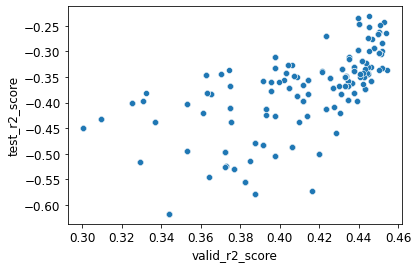

In [7]:
sns.scatterplot(results_df['valid_r2_score'],results_df['test_r2_score'])

/scratch/brown/kamstut/tdm/apps/jupyter/kernels/llnl/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratch/brown/kamstut/tdm/apps/jupyter/kernels/llnl/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratch/brown/kamstut/tdm/apps/jupyter/kernels/llnl/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future v

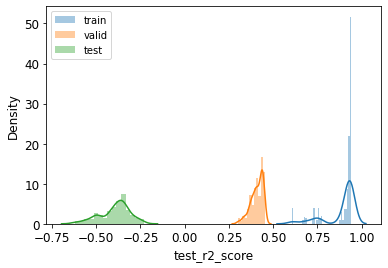

In [8]:
sns.distplot(results_df['train_r2_score'],label='train')
sns.distplot(results_df['valid_r2_score'],label='valid')
sns.distplot(results_df['test_r2_score'],label='test')
plt.legend()